# APPLICATIONS OF MACHINE LEARNING TO THE STUDY OF BRAIN METASTASES
THIS PROJECT HAS BEEN DEVELOPED INSIDE THE CONTEXT OF [SATURDAYS AI ASTURIAS](https://cursos.saturdays.ai/courses/aisatudays-asturias-ml), WE ARE:
* [Adrián Aguado](https://www.linkedin.com/in/adrianaguado/)
* [Raquel Martínez](https://www.linkedin.com/in/rakelmarmar/)
* [Arturo Linares](https://github.com/afouteza)
* [Olumayowa Onabanjo](https://www.linkedin.com/in/olumayowa-onabanjo-452b8143)
* [Mateo Rodríguez](http://www.linkedin.com/in/mateo-r-6az)

FOR ENQUIRIES ABOUT THE CODE: mateorsuarez@gmail.com

WE MUST THANK EVERY PERSON THAT HAS MADE THIS PROJECT POSSIBLE: [Sofía González](https://www.linkedin.com/in/sof%C3%ADa-gonz%C3%A1lez-arias/), every mentor we've had troughout the sesions, and finally Juan Belmonte and Beatriz Ocaña, from MOLAB.

UNFORTUNATELY, WE HAVE NOT BEEN ABLE TO ACHIEVE GREAT PREDICTION RESULTS, EVEN THOUGH SOME OF THEM ARE QUITE PROMISING. HOWEVER, THIS PROJECT IS, WITHOUT A SHADOW OF DOUBT, INCOMPLETE. AS TIME IS NOT UNLIMITED, WE LEAVE IT HERE FOR NOW. MUCH MORE CAN BE DONE FOLLOWING OUR STEPS, AS THIS IS JUST AN INTRODUCTION.

AN ULTIMATE REMARK HAS TO BE MADE. THE MOST IMPORTANT (AND TIME-CONSUMING) TASK HAS BEEN STUDYING THE DATA AND UNDERSTANDING WHAT CAN BE EXPECTED TO ACHIEVE FROM IT. THERE ARE TWO EXCELS WITH DIFFERENT FORMATS, AND BEFORE ANY MACHINE LEARNING MODEL COULD BE APPLIED IT WAS NECESSARY TO DO AN EXHAUSTIVE MANIPULATION IN ORDER TO OBTAIN A CLEAN DATAFRAME.

PD: BE CAREFUL WHEN RUNNING THE WHOLE CODE, AS IT TAKES A GREAT AMOUNT OF RAM MEMORY (AROUND 45-50 GB).

# INFORMATION ABOUT THE DATA

+ DATA FROM MOLAB: https://molab.es/datasets-brain-metastasis-1/?type=metasrd

**MORPHOLOGICAL MEASURES**

IMAGE PARAMETERS:
*   SBS = SPACE BETWEEN SLICES (mm)
*   SCS = SLICE THICKNESS (mm)
*   REPTIME = REPETITION TIME (msec)
* CEVOLUME = CONTRAST-ENHANCING VOLUME $V_{CE}$
* NECVOLUME = NECROTIC (NON-ENHANCING) VOLUME $V_{N}$
* TOTALVOLUME $V = V_{CE}+V_{N}$
*CERIMWIDTH = CONTRAST-ENHANCING (CE) SPHERICAL RIM WIDTH, function of volume
* SURFACEREGULARITY = the tumor's shape is more espherical as this parameter approaches 1.
*MAXDIAMETER3D = Max. longitudinal length
---
CLINICAL DATA

* PRIMARY TUMOR (naranja):
    * EGFR,ALK... molecular markers
    * TNM: tumor classification.
        * T: size.
        * N: expansion to the lymph glands.
        * M : metastasis to distant organs.

* GPA (yellow): GPA index, survival estimator for patients with brain metastasis.

# 0. IMPORTS

In [ ]:
pip install shap

In [ ]:
##################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import linregress

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.model_selection import train_test_split
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


import xgboost as xgb
from xgboost import DMatrix

import shap

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Activation

from keras.callbacks import EarlyStopping
# Some data preprocessing:
from sklearn.preprocessing import MinMaxScaler # Values between 0 and 1
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Reduction of dimensionality

import joblib


# Save models
import pickle


import nibabel as nib
##################################################
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# 1. FUNCTIONS

In [ ]:
##################################################
# NANS
def columnas_nulas(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores faltantes', 1 : '% del Total de Valores'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% del Total de Valores', ascending=False).round(1)
        print ("El dataframe seleccionado tiene " + str(df.shape[1]) + " columnas.\n"
            "Hay " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas que tienen Valores nulos.")
        return mis_val_table_ren_columns



###############################################
# FUNCTION THAT PLOTS AN MRI IMAGE
def plot_mri_image(nii_file):
    # Cargar la imagen .nii
    nii_img = nib.load(nii_file)
    # Obtener los datos de la imagen
    nii_data = nii_img.get_fdata()

    # Calcular el punto medio del cerebro para cortes axiales
    mid_slice = nii_data.shape[2] // 2

    # Plotear las imágenes
    fig, axes = plt.subplots(1, 3, figsize=(15, 15))

    # Cortes Axiales
    axes[0].imshow(nii_data[:, :, mid_slice], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("Axial")

    # Cortes Sagitales
    sagittal_slice = nii_data.shape[0] // 2
    axes[1].imshow(nii_data[sagittal_slice, :, :].T, cmap='gray', origin='lower')
    axes[1].axis('off')
    axes[1].set_title("Sagittal")

    # Cortes Coronal
    coronal_slice = nii_data.shape[1] // 2
    axes[2].imshow(nii_data[:, coronal_slice, :].T, cmap='gray', origin='lower')
    axes[2].axis('off')
    axes[2].set_title("Coronal")

    plt.show()

####################################################
#DATE DIFFERENCE IN DAYS
def datesdiff(dfa,dfb):
  'FUNCIÓN QUE CALCULA LA DIFERENCIA DE FECHAS (EN DÍAS) ENTRE DOS ELEMENTOS DE UN DATAFRAME b-a'
  a = pd.to_datetime(dfa,format = "%Y%m%d") # Fecha 1
  b = pd.to_datetime(dfb,format = "%Y%m%d") # Fecha 2
  dif = (b-a).days
  return dif

# EXAMPLE OF USE: datesdiff(df['TIME POINT'][0],df['TIME POINT'][1])

# 2. OBTAIN THE DATASETS

##MORPHOLOGICAL MEASURES

In [ ]:
#DATAFRAME CONTAINING MORPHOLOGICAL MEASURES
df_MM = pd.read_excel(r'/content/OpenBTAI_MORPHOLOGICAL_MEASUREMENTS.xlsx')
df_MM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PATIENT            499 non-null    int64  
 1   TIME POINT         499 non-null    int64  
 2   PIXELSPACING       499 non-null    float64
 3   SBS                499 non-null    float64
 4   STH                499 non-null    float64
 5   STATION NAME       499 non-null    object 
 6   REPTIME            499 non-null    float64
 7   ECHOTIME           499 non-null    float64
 8   MAGNETIC FIELD     499 non-null    float64
 9   LESION             499 non-null    int64  
 10  TOTALVOLUME        499 non-null    float64
 11  CEVOLUME           499 non-null    float64
 12  NECVOLUME          499 non-null    float64
 13  CERIMWIDTH         499 non-null    float64
 14  MAXDIAMETER3D      499 non-null    float64
 15  TOTALSURFACE       499 non-null    float64
 16  RENDVOLUME         499 non

In [ ]:
df_MM.head(1)

PATIENT  TIME POINT  PIXELSPACING  SBS  STH             STATION NAME  \
0    10005    19010618      0.976562  1.0  2.0  Philips Medical Systems   

   REPTIME  ECHOTIME  MAGNETIC FIELD  LESION  TOTALVOLUME  CEVOLUME  \
0     25.0     5.139             1.5       1     0.162125  0.162125   

   NECVOLUME  CERIMWIDTH  MAXDIAMETER3D  TOTALSURFACE  RENDVOLUME  \
0        0.0    0.338262       0.783567      1.665688    0.154416   

   SURFACEREGULARITY  
0           0.763884

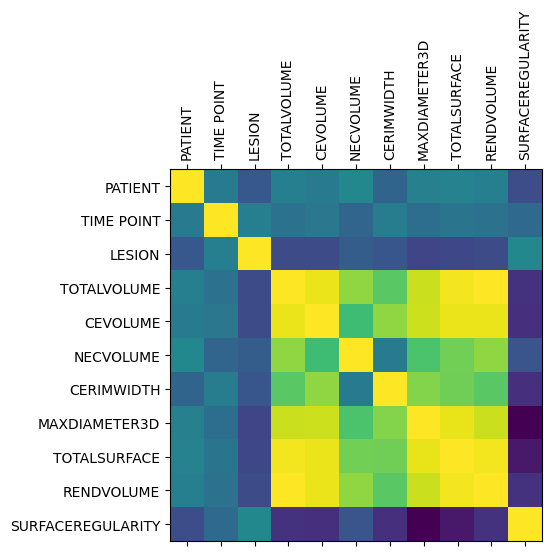

In [ ]:
#CORRELATION MATRIX
df_MM = df_MM.drop('STATION NAME',axis=1) # TIRAMOS DATOS IRRELEVANTES
df_MM = df_MM.drop(columns=['PIXELSPACING','SBS','STH','REPTIME','ECHOTIME','MAGNETIC FIELD'])
mat_MM = np.matrix(df_MM)
plt.matshow(df_MM.corr())
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],['PATIENT',	'TIME POINT',	'LESION',	'TOTALVOLUME',	'CEVOLUME',	'NECVOLUME',	'CERIMWIDTH',	'MAXDIAMETER3D',	'TOTALSURFACE',	'RENDVOLUME',	'SURFACEREGULARITY'],rotation = 90)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['PATIENT',	'TIME POINT',	'LESION',	'TOTALVOLUME',	'CEVOLUME',	'NECVOLUME',	'CERIMWIDTH',	'MAXDIAMETER3D',	'TOTALSURFACE',	'RENDVOLUME',	'SURFACEREGULARITY'],rotation = 0)
plt.show()

In [ ]:
df_MM.head(1)

PATIENT  TIME POINT  LESION  TOTALVOLUME  CEVOLUME  NECVOLUME  CERIMWIDTH  \
0    10005    19010618       1     0.162125  0.162125        0.0    0.338262   

   MAXDIAMETER3D  TOTALSURFACE  RENDVOLUME  SURFACEREGULARITY  
0       0.783567      1.665688    0.154416           0.763884

NEW CORRELATION MATRIX

In [ ]:
corr = df_MM.corr()
corr.style.background_gradient(cmap='coolwarm')

If we look at the TOTALVOLUME column, we can see there is important correlation for almost every other variable. CERIMWIDTH and SURFACEREGULARITY are the only variables that have an R low enough.

####TOTAL VALUES OF MORPHOLOGICAL MEASURES (COMMENTED BECAUSE IT'S PROBABLY USELESS)
AT FIRST, WE WANTED TO CONSIDER THE PATIENT AS A WHOLE, BUT WE WILL SEE THAT IT IS NOT POSSIBLE AS THE DIFFERENT LESIONS OF EACH PATIENT DON'T OCCUR AT THE SAME TIMES

In [ ]:
'''
d2 = pd.DataFrame() # Creamos un DataFrame vacío

# d.count nos da el número de elementos, y d.mean la media de esos elementos. Ergo, count*mean da la suma de todos los elementos.

# Hacemos la suma para cada columna.
d = df.groupby(['PATIENT','TIME POINT'])['TOTALVOLUME'].describe()
totvol = d['count']*d['mean']
d2['totvol'] = totvol

d = df.groupby(['PATIENT','TIME POINT'])['CEVOLUME'].describe()
totcevol = d['count']*d['mean']
d2['totcevol'] = totcevol

d = df.groupby(['PATIENT','TIME POINT'])['NECVOLUME'].describe()
totnecvol = d['count']*d['mean']
d2['totnecvol'] = totnecvol

d = df.groupby(['PATIENT','TIME POINT'])['CERIMWIDTH'].describe()
totwidth = d['count']*d['mean']
d2['totcerimwidth'] = totwidth

d = df.groupby(['PATIENT','TIME POINT'])['MAXDIAMETER3D'].describe()
totdiam = d['count']*d['mean']
d2['totmaxdiam'] = totdiam

d = df.groupby(['PATIENT','TIME POINT'])['TOTALSURFACE'].describe()
totsurf = d['count']*d['mean']
d2['totsurf'] = totsurf

d = df.groupby(['PATIENT','TIME POINT'])['RENDVOLUME'].describe()
totrend = d['count']*d['mean']
d2['totrendvol'] = totrend

#SURFACEREGULARITY NO ES SUSCEPTIBLE DE ESTE MODELO, SE PUEDE HACER LA MEDIA

d = df.groupby(['PATIENT','TIME POINT'])['SURFACEREGULARITY'].describe()
totreg = d['mean']
d2['surfacereg'] = totreg

#d2 tiene los valores totales
#d tiene las estadísticas

d2.head()
'''

"\nd2 = pd.DataFrame() # Creamos un DataFrame vacío\n\n# d.count nos da el número de elementos, y d.mean la media de esos elementos. Ergo, count*mean da la suma de todos los elementos.\n\n# Hacemos la suma para cada columna.\nd = df.groupby(['PATIENT','TIME POINT'])['TOTALVOLUME'].describe()\ntotvol = d['count']*d['mean']\nd2['totvol'] = totvol\n\nd = df.groupby(['PATIENT','TIME POINT'])['CEVOLUME'].describe()\ntotcevol = d['count']*d['mean']\nd2['totcevol'] = totcevol\n\nd = df.groupby(['PATIENT','TIME POINT'])['NECVOLUME'].describe()\ntotnecvol = d['count']*d['mean']\nd2['totnecvol'] = totnecvol\n\nd = df.groupby(['PATIENT','TIME POINT'])['CERIMWIDTH'].describe()\ntotwidth = d['count']*d['mean']\nd2['totcerimwidth'] = totwidth\n\nd = df.groupby(['PATIENT','TIME POINT'])['MAXDIAMETER3D'].describe()\ntotdiam = d['count']*d['mean']\nd2['totmaxdiam'] = totdiam\n\nd = df.groupby(['PATIENT','TIME POINT'])['TOTALSURFACE'].describe()\ntotsurf = d['count']*d['mean']\nd2['totsurf'] = totsurf\n

##CLINICAL DATA



In [ ]:
#DATAFRAME CONTAINING CLINICAL DATA

df_CD = pd.read_excel(r'/content/OpenBTAI_METS_ClinicalData_Nov2023.xlsx',header=14)
df_CD = df_CD.drop(index=[160,161,162,163])
df_CD.head(1)

Unnamed: 0  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0     010005        40.0         1.0         1.0         1.0         1.0   

   Unnamed: 6  EGFR  ALK  ROS1  KRAS  TTF1  Sinaptofisina  PDL1  BRCA1  RE  \
0         1.0   NaN  NaN   NaN   NaN   NaN            NaN   NaN    NaN NaN   

   RP  HER2  BRAF  NRAS  CKIT  TNM Stage  Dose/Frac  Nfrac Begin End  \
0 NaN   NaN   NaN   NaN   NaN  NaN   NaN        3.0   10.0     0  13   

   Dose/Frac.1  Nfrac.1 Begin.1 End.1  Dosis/Frac  Nfrac.2 Begin.2 End.2  \
0          NaN      NaN                       5.5      3.0     781   785   

   Dosis/Frac.1  Nfrac.3 Begin.3 End.3  Dosis/Frac.2  Nfrac.4 Begin.4 End.4  \
0           NaN      NaN                         NaN      NaN                 

  Time  Unnamed: 44 Unnamed: 45          Drug Begin.5 End.5  \
0               NaN              Capecitabine     -19   104   

                                  Drug.1 Begin.6 End.6  \
0  Cisplatin + Gemcitabine + bevacizumab     104   407   

                   Drug.2 Begin.7 End.7       Drug.3 Begin.8 End.8  \
0  bevacizumab + letrozol     424   531  Vinorelbine     538   658   

        Drug.4 Begin.9 End.9 Drug.5  Begin.10  End.10 Drug.6  Begin.11  \
0  Doxorubicin     676   732    NaN       NaN     NaN    NaN       NaN   

   End.11 Drug.7  Begin.12  End.12 Unnamed: 70  Unnamed: 71  Unnamed: 72  \
0     NaN    NaN       NaN     NaN         NaN          1.0       1084.0   

  Unnamed: 73        MR1        MR2        MR3        MR4  \
0           1 1900-01-01 1900-03-04 1900-03-11 1901-06-18   

                   MR5                  MR6                  MR7 MR8 MR9 MR10  \
0  1901-10-11 00:00:00  1902-01-28 00:00:00  1902-04-13 00:00:00                

  MR11 MR12 MR13 MR14 MR15 MR16 MR17 MR18 MR19  
0                           NaN  NaN

NOW WE RENAME UNNAMED COLUMNS

UNNAMEDS:
* 0 = ID
* 1 = AGE AT MR1
* 2 = SEX, 1= FEMALE,2 = MALE
* 3 = GPA
* 4 = LESION
* 5 = TYPE
* 6 = SUBTYPE
* 44 = SURGERY TYPE
* 45 = SURGERY TIME
* 70 = COMMENTS
* 71 = DEATH OCURRENCE (1 = YES,0=NO)
* 72 = DEATH TIME
* 73 = DEATH CAUSE (1 BRAIN PROGRESSION, 2 SYSTEMIC ILLNESS, 3 = 1+2, 4 OTHER)



In [ ]:
df_CD = df_CD.rename(columns={'Unnamed: 0':'ID','Unnamed: 1':'AGE','Unnamed: 2':'SEX','Unnamed: 3':'GPA','Unnamed: 4':'LESION','Unnamed: 5':'TYPE','Unnamed: 6':'SUBTYPE','Unnamed: 44':'SURGERY TYPE','Unnamed: 45':'SURGERY TIME','Unnamed: 70':'COMMENTS','Unnamed: 71':'DEATH','Unnamed: 72':'DEATH TIME','Unnamed: 73':'DEATH CAUSE'})
df_CD.head(1)

ID   AGE  SEX  GPA  LESION  TYPE  SUBTYPE  EGFR  ALK  ROS1  KRAS  TTF1  \
0  010005  40.0  1.0  1.0     1.0   1.0      1.0   NaN  NaN   NaN   NaN   NaN   

   Sinaptofisina  PDL1  BRCA1  RE  RP  HER2  BRAF  NRAS  CKIT  TNM Stage  \
0            NaN   NaN    NaN NaN NaN   NaN   NaN   NaN   NaN  NaN   NaN   

   Dose/Frac  Nfrac Begin End  Dose/Frac.1  Nfrac.1 Begin.1 End.1  Dosis/Frac  \
0        3.0   10.0     0  13          NaN      NaN                       5.5   

   Nfrac.2 Begin.2 End.2  Dosis/Frac.1  Nfrac.3 Begin.3 End.3  Dosis/Frac.2  \
0      3.0     781   785           NaN      NaN                         NaN   

   Nfrac.4 Begin.4 End.4 Time  SURGERY TYPE SURGERY TIME          Drug  \
0      NaN                              NaN               Capecitabine   

  Begin.5 End.5                                 Drug.1 Begin.6 End.6  \
0     -19   104  Cisplatin + Gemcitabine + bevacizumab     104   407   

                   Drug.2 Begin.7 End.7       Drug.3 Begin.8 End.8  \
0  bevacizumab + letrozol     424   531  Vinorelbine     538   658   

        Drug.4 Begin.9 End.9 Drug.5  Begin.10  End.10 Drug.6  Begin.11  \
0  Doxorubicin     676   732    NaN       NaN     NaN    NaN       NaN   

   End.11 Drug.7  Begin.12  End.12 COMMENTS  DEATH  DEATH TIME DEATH CAUSE  \
0     NaN    NaN       NaN     NaN      NaN    1.0      1084.0           1   

         MR1        MR2        MR3        MR4                  MR5  \
0 1900-01-01 1900-03-04 1900-03-11 1901-06-18  1901-10-11 00:00:00   

                   MR6                  MR7 MR8 MR9 MR10 MR11 MR12 MR13 MR14  \
0  1902-01-28 00:00:00  1902-04-13 00:00:00                                    

  MR15 MR16 MR17 MR18 MR19  
0       NaN  NaN

In [ ]:
columnas_nulas(df_CD)

El dataframe seleccionado tiene 93 columnas.
Hay 71 columnas que tienen Valores nulos.


Valores faltantes  % del Total de Valores
TTF1                         160                   100.0
HER2                         160                   100.0
Sinaptofisina                160                   100.0
Nfrac.4                      159                    99.4
PDL1                         159                    99.4
Dosis/Frac.2                 159                    99.4
RP                           158                    98.8
KRAS                         158                    98.8
COMMENTS                     158                    98.8
RE                           158                    98.8
CKIT                         157                    98.1
End.11                       156                    97.5
Begin.12                     156                    97.5
BRCA1                        156                    97.5
Drug.7                       156                    97.5
End.12                       156                    97.5
BRAF                         155                    96.9
ROS1                         155                    96.9
NRAS                         155                    96.9
Stage                        154                    96.2
Drug.6                       153                    95.6
Begin.11                     153                    95.6
End.10                       151                    94.4
SURGERY TYPE                 150                    93.8
Nfrac.3                      145                    90.6
Dosis/Frac.1                 145                    90.6
Nfrac.1                      144                    90.0
Dose/Frac.1                  144                    90.0
Begin.10                     143                    89.4
Drug.5                       143                    89.4
Drug.4                       131                    81.9
ALK                          123                    76.9
EGFR                         115                    71.9
Drug.3                       115                    71.9
Drug.2                        87                    54.4
TNM                           64                    40.0
Nfrac                         47                    29.4
Dose/Frac                     47                    29.4
Dosis/Frac                    43                    26.9
Nfrac.2                       42                    26.2
Drug.1                        37                    23.1
SUBTYPE                       31                    19.4
MR16                          22                    13.8
MR17                          21                    13.1
GPA                           20                    12.5
DEATH CAUSE                   20                    12.5
Drug                          18                    11.2
Time                          13                     8.1
End.2                         10                     6.2
MR7                           10                     6.2
MR15                          10                     6.2
MR10                           9                     5.6
MR8                            7                     4.4
MR12                           7                     4.4
MR5                            6                     3.8
MR9                            5                     3.1
MR13                           5                     3.1
Begin.2                        4                     2.5
MR6                            4                     2.5
Begin.6                        3                     1.9
End.6                          3                     1.9
Begin.3                        3                     1.9
Begin                          2                     1.2
MR14                           2                     1.2
End                            2                     1.2
Begin.5                        2                     1.2
Begin.1                        1                     0.6
End.7                          1                     0.6
SURGERY TIME                   1                     0.6
End.3                    

WE ASIGN A NUMERICAL VALUE TO EACH DRUG

In [ ]:
#PROBABLY EASIER TO USE LABELENCODER: from sklearn.preprocessing import LabelEncoder: ENCODING CATEGORIAL DATA AS A DUMMY VARIABLE

drugs = pd.unique(df_CD['Drug']) # With unique we eliminate the ones that are repeated
drugs1 = pd.unique(df_CD['Drug.1'])
drugs2 = pd.unique(df_CD['Drug.2'])
drugs3 = pd.unique(df_CD['Drug.3'])
drugs4 = pd.unique(df_CD['Drug.4'])
drugs5 = pd.unique(df_CD['Drug.5'])
drugs6 = pd.unique(df_CD['Drug.6'])
drugs7 = pd.unique(df_CD['Drug.7'])

dd = np.concatenate((drugs,drugs1,drugs2,drugs3,drugs4,drugs5,drugs6,drugs7)) # We concatenate the different drugs
dd = pd.unique(dd) # We eliminate again the repeated
dd = np.delete(dd,8) # We eliminate nan


df_CD = df_CD.replace(dd,np.arange(1,len(dd)+1)) # We replace in the original DataFrame

# We drop useless columns
df_CD= df_CD.drop(columns=['MR1','MR2','MR3','MR4','MR5','MR6','MR7','MR8','MR9','MR10','MR11','MR12','MR13','MR14','MR15','MR16','MR17','MR18','MR19']) # Tiramos las últimas columnas que contienen las fechas de los MRIs
df_CD = df_CD.drop(columns=['COMMENTS','EGFR',	'ALK',	'ROS1',	'KRAS',	'TTF1',	'Sinaptofisina',	'PDL1',	'BRCA1',	'RE',	'RP',	'HER2',	'BRAF',	'NRAS',	'CKIT','Stage']) # Tiramos columnas con muchos valores nulos (e.g. marcadores moleculares)


df_CD.head()

ID   AGE  SEX  GPA  LESION  TYPE  SUBTYPE  TNM  Dose/Frac  Nfrac Begin  \
0  010005  40.0  1.0  1.0     1.0   1.0      1.0  NaN        3.0   10.0     0   
1  010005  40.0  1.0  1.0     3.0   1.0      1.0  NaN        3.0   10.0     0   
2  010020  44.0  1.0  NaN     1.0   1.0      4.0  NaN        3.0   10.0     3   
3  010020  44.0  1.0  NaN     2.0   1.0      4.0  NaN        3.0   10.0     3   
4  010020  44.0  1.0  NaN     3.0   1.0      4.0  NaN        3.0   10.0     3   

  End  Dose/Frac.1  Nfrac.1 Begin.1 End.1  Dosis/Frac  Nfrac.2 Begin.2 End.2  \
0  13          NaN      NaN                       5.5      3.0     781   785   
1  13          NaN      NaN                       NaN      NaN                 
2  16          NaN      NaN                       NaN      NaN                 
3  16          NaN      NaN                       NaN      NaN                 
4  16          NaN      NaN                       NaN      NaN                 

   Dosis/Frac.1  Nfrac.3 Begin.3 End.3  Dosis/Frac.2  Nfrac.4 Begin.4 End.4  \
0           NaN      NaN                         NaN      NaN                 
1           NaN      NaN                         NaN      NaN                 
2           NaN      NaN                         NaN      NaN                 
3           NaN      NaN                         NaN      NaN                 
4           NaN      NaN                         NaN      NaN                 

  Time  SURGERY TYPE SURGERY TIME  Drug Begin.5 End.5  Drug.1 Begin.6 End.6  \
0                NaN                1.0     -19   104    63.0     104   407   
1                NaN                1.0     -19   104    63.0     104   407   
2                NaN                2.0      23   129     4.0     150   591   
3                NaN                2.0      23   129     4.0     150   591   
4                NaN                2.0      23   129     4.0     150   591   

   Drug.2 Begin.7 End.7  Drug.3 Begin.8 End.8  Drug.4 Begin.9 End.9  Drug.5  \
0    99.0     424   531    66.0     538   658   125.0     676   732     NaN   
1    99.0     424   531    66.0     538   658   125.0     676   732     NaN   
2   100.0     612   696   123.0     725  1062     NaN                   NaN   
3   100.0     612   696   123.0     725  1062     NaN                   NaN   
4   100.0     612   696   123.0     725  1062     NaN                   NaN   

   Begin.10  End.10  Drug.6  Begin.11  End.11  Drug.7  Begin.12  End.12  \
0       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
1       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
2       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
3       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
4       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   

   DEATH  DEATH TIME DEATH CAUSE  
0    1.0      1084.0           1  
1    1.0      1084.0           1  
2    1.0      1625.0         NaN  
3    1.0      1625.0         NaN  
4    1.0      1625.0         NaN

THERE ARE SOME LESIONS OF WHICH WE DON'T HAVE MORPHOLOGICAL INFORMATION, BUT APPEAR IN THE CLINICAL DATA EXCEL

In [ ]:
# PATIENT 40156 1
# PATIENT 40109 2
# PATIENT 40084 2
# PATIENT 40058 2
# PATIENT 40011 1
# PATIENT 40001 2

# THEREFORE, WE ACTUALLY HAVE 160 - 6 = 154 LESIONS(TUMORS)

df_CD = df_CD.drop([65,73,90,105,115,145])

mat_CD = np.matrix(df_CD)

In [ ]:
#WE'LL USE THIS FOR OBJECTIVE 2
df_CD2 = df_CD[['ID','LESION','GPA','SEX','AGE']]
df_CD2['ID'] = df_CD2['ID'].astype(int)

## -RADIOMIC DATA

PROBABLY WE CAN'T DO ANYTHING WITH IT, JUST TRYING WITH PCA (THERE ARE MORE THAN 1000 COLUMNS)

In [ ]:
# df_R = pd.read_excel(r'/content/OpenBTAI_RADIOMICS.xlsx')
# df_R = df_R[df_R['Segment']=='Total']
# df_R.head()

# 3. FIRST APPROACH TO THE DATA

## PATIENT DATA

###NOT REALLY IMPORTANT INFO

DAYS BETWEEN FIRST AND LAST MRI

In [ ]:
a = np.array(df_MM['TIME POINT']) # DATES ARRAY
b = np.array(df_MM['PATIENT'])    # PATIENTS ARRAY

c = np.column_stack((a,b))

days_MRI0 = np.zeros_like(b) # DAYS BETWEEN CONSECUTIVE MRIS

days_MRI = np.zeros(75) # DAYS BETWEEN FIRST AND LAST MRI
j = 0
k = 0
for i in range(1,len(c)):
  if c[i][1] == c[i-1][1]:
    days_MRI[j] +=  datesdiff(c[i-1][0],c[i][0])
    days_MRI0[k] = datesdiff(c[i-1][0],c[i][0])
  elif c[i][1] != c[i-1][1]:
    j += 1
  k += 1


Mean = 281.4533333333333
Desviation = 225.01106896229695


Text(0, 0.5, '# of patients')

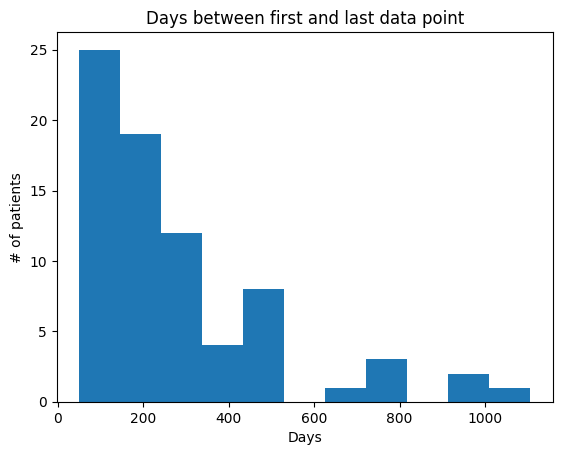

In [ ]:
plt.hist(days_MRI,bins='auto')

print('Mean = ' + str(np.mean(days_MRI)))
print('Desviation = ' + str(np.sqrt(np.var(days_MRI))))
plt.title('Days between first and last data point')
plt.xlabel('Days')
plt.ylabel('# of patients')

Text(0, 0.5, '#')

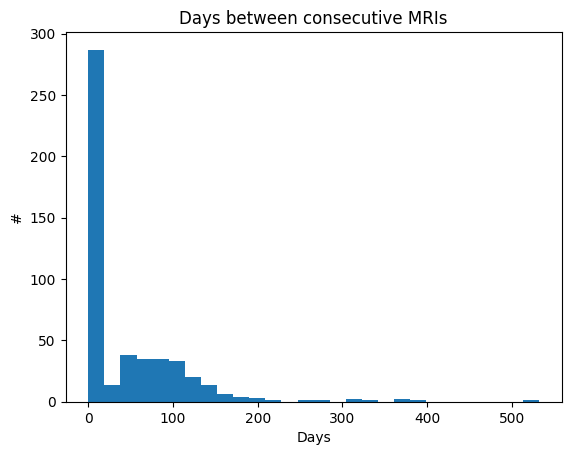

In [ ]:
plt.hist(days_MRI0,bins='auto')
plt.title('Days between consecutive MRIs')
plt.xlabel('Days')
plt.ylabel('#')

### MORE INTERESTING INFO

DAYS UNTIL DEATH

Text(0.5, 1.0, 'SURVIVAL DISTRIBUTION')

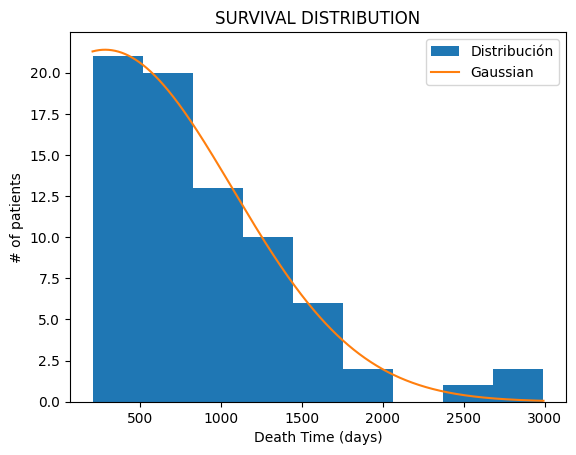

In [ ]:
# Array with survival days, but repeated for every tumor of the different patients:
deaths = np.array(df_CD['DEATH TIME'])
patients = np.array(df_CD['ID'])

death_matrix = np.column_stack((deaths,patients))

death_array = np.zeros(75)

j = 0

for i in range(1,len(death_matrix)):
  if death_matrix[i][1] != death_matrix[i-1][1]:
    death_array[j] = death_matrix[i-1][0]
    j += 1
death_array[-1] = deaths[-1]


# We define gaussian distribution
def gaussian(x,mu,sigma2,A):
    return A*norm.pdf(x,mu,sigma2)


x = death_array

mu = np.mean(x) # Mean of the distribution
sigma2 = np.var(x) # Variance


bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='Distribución') # We divide in bins
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2 # We calc. the centres
popt, _ = curve_fit(gaussian, bin_centers, bin_heights,maxfev=10000,p0=[mu, sigma2,1000]) # We fit with curve_fit

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000) # Interval
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian') # We plot the fit
plt.legend()

plt.xlabel('Death Time (days)')
plt.ylabel('# of patients')
plt.title('SURVIVAL DISTRIBUTION')

LOGNORMAL SURVIVAL DISTRIBUTION

In [ ]:
'''
deaths2 = np.log(x)
mu = np.mean(deaths2)
sigma = np.var(deaths2)

bin_heights, bin_borders, _ = plt.hist(deaths2, bins='auto', label='Distribution')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, maxfev=10000)

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='LogNormal')
plt.legend()

plt.xlabel(r'Death Time ( $log(days)$ )')
plt.ylabel('# of patients')
'''

"\ndeaths2 = np.log(x)\nmu = np.mean(deaths2)\nsigma = np.var(deaths2)\n\nbin_heights, bin_borders, _ = plt.hist(deaths2, bins='auto', label='Distribution')\nbin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2\npopt, _ = curve_fit(gaussian, bin_centers, bin_heights, maxfev=10000)\n\nx_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)\nplt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='LogNormal')\nplt.legend()\n\nplt.xlabel(r'Death Time ( $log(days)$ )')\nplt.ylabel('# of patients')\n"

OBTAINING 75 LENGTH ARRAYS WITH THE INFO FOR THE PATIENTS

In [ ]:
'''
RIGHT NOW THE INFORMATION WE'VE GOT FROM CLINICAL DATA IS, IN FACT, USELESS DUE TO ITS FORMAT
WE HAVE EVERY PATIENT'S PIECE OF DATA REPEATED FOR EACH OF ITS LESIONS, SO NOW WE WANT ARRAYS
WITH JUST 75 POINTS, 1 FOR EACH PATIENT.
'''
# FIRST WE GET THE ARRAYS FROM CD
patients = np.array(df_CD['ID'])
age = np.array(df_CD['AGE'])
sex = np.array(df_CD['SEX'])
gpa = np.array(df_CD['GPA'])
lesion = np.array(df_CD['LESION'])
type_array0 = np.array(df_CD['TYPE'])
tnm = np.array(df_CD['TNM'])
dc = np.array(df_CD['DEATH CAUSE'])

########## A MATRIX TO COMPARE

age_matrix = np.column_stack((age,patients))

age_array = np.zeros(75)

sex_array = np.zeros(75)

gpa_array = np.zeros(75)

type_array = np.zeros(75)

patient_array = np.zeros(75)

dc_array=np.zeros(75) #DEATH CAUSE

j = 0

for i in range(1,len(age_matrix)):
  if age_matrix[i][1] != age_matrix[i-1][1]:
    age_array[j] = age_matrix[i-1][0]
    sex_array[j] = sex[i-1]
    gpa_array[j] = gpa[i-1]
    type_array[j] = type_array0[i-1]
    patient_array[j] = patients[i-1]
    if type(dc[i-1]) != str:
      dc_array[j]= dc[i-1]
    else:
      dc_array[j]=1

    j += 1

#NOW WE GOT THE ARRAYS WITH JUST ONE PIECE OF DATA FOR EACH PATIENT
age_array[-1] = age[-1]
sex_array[-1] = sex[-1]
gpa_array[-1] = gpa[-1]
type_array[-1] = type_array0[-1]
patient_array[-1] = patients[-1]
dc_array[-1] = dc[-1]

LET'S SEE WHAT WE'VE GOT

AGE DISTRIBUTION

Text(0.5, 1.0, 'Age distribution')

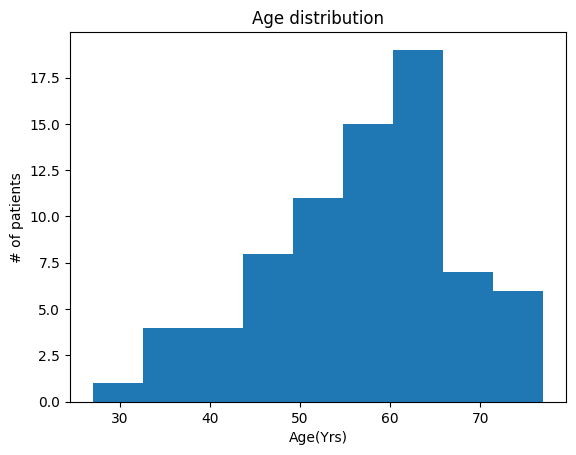

In [ ]:
plt.hist(age_array,bins='auto')
plt.xlabel('Age(Yrs)')
plt.ylabel('# of patients')
plt.title('Age distribution')

SEX DISTRIBUTION

array([47., 28.])

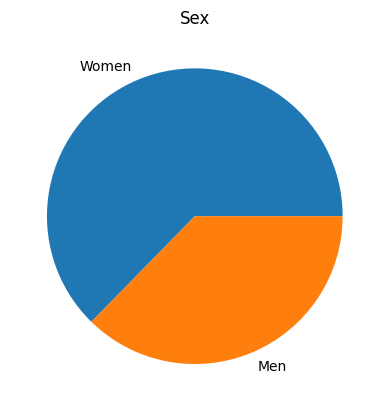

In [ ]:
sex_pie = np.zeros(2)
for i in sex_array:
  if i ==1:
    sex_pie[0] += 1
  else:
    sex_pie[1] += 1
plt.pie(sex_pie,labels=['Women','Men'])
plt.title('Sex')
sex_pie

PRIMARY TYPE TUMORS

Text(0.5, 1.0, 'PRIMARY TUMORS')

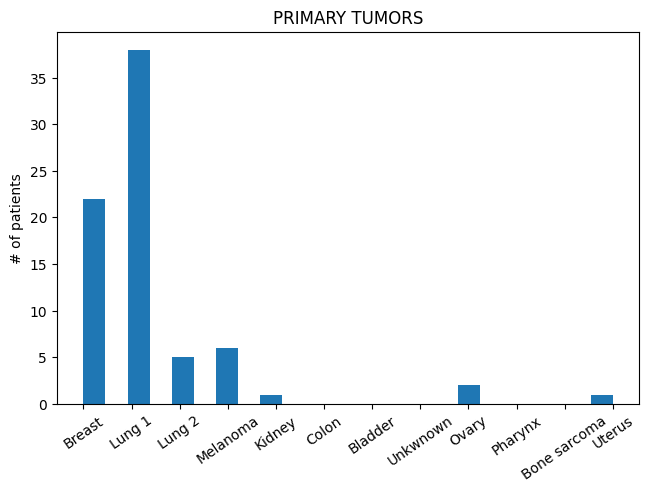

In [ ]:
plt.hist(type_array,bins='auto')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],['Breast','Lung 1','Lung 2','Melanoma','Kidney','Colon','Bladder','Unkwnown','Ovary','Pharynx','Bone sarcoma','Uterus',],rotation=35)
plt.tight_layout()
plt.ylabel('# of patients')
plt.title('PRIMARY TUMORS')

GPA DISTRIBUTION

Text(0.5, 1.0, 'GPA distribution')

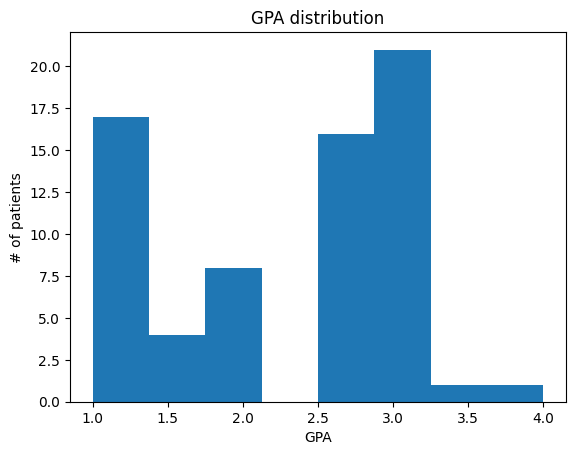

In [ ]:
plt.hist(gpa_array,bins='auto')
plt.xlabel('GPA')
plt.ylabel('# of patients')
plt.title('GPA distribution')

NUMBER OF LESIONS

Text(0.5, 1.0, '# Lesion distribution ')

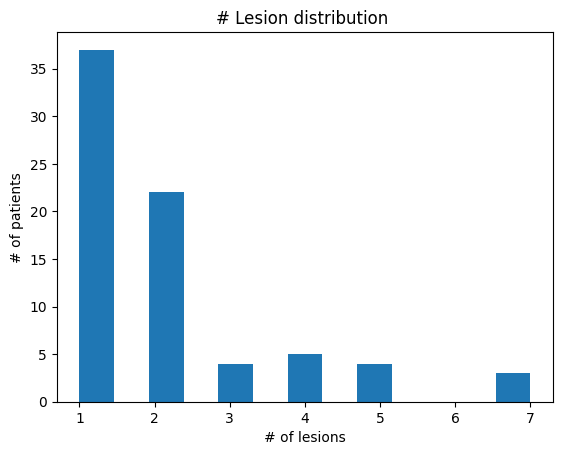

In [ ]:
nlesions = np.ones(75) #ARRAY CON EL NÚMERO DE LESIONES


j = 0
for u in range(1,len(mat_CD)):
  if mat_CD[u,0]== mat_CD[u-1,0]:
    nlesions[j] +=1
    nlesions[j] = int(nlesions[j])
  else:
    j +=1

plt.hist(nlesions,bins='auto')
plt.xlabel('# of lesions')
plt.ylabel('# of patients')
plt.title('# Lesion distribution ')

CAUSE OF DEATH

([<matplotlib.axis.XTick at 0x7b400d4c7fa0>,
 [Text(1, 0, 'Brain progression'),
  Text(2, 0, 'Systemic Illness'),
  Text(3, 0, 'Systemic+Brain Progr'),
  Text(4, 0, 'Other')])

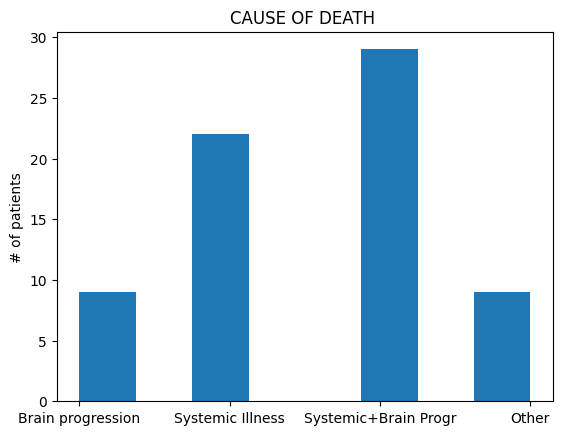

In [ ]:
plt.hist(dc_array,bins = 'auto')
plt.ylabel('# of patients')
plt.title('CAUSE OF DEATH ')
plt.xticks([1,2,3,4],['Brain progression','Systemic Illness','Systemic+Brain Progr','Other'],rotation=0)

SURVIVAL TIME VS AGE

Text(0, 0.5, 'Survival (Days)')

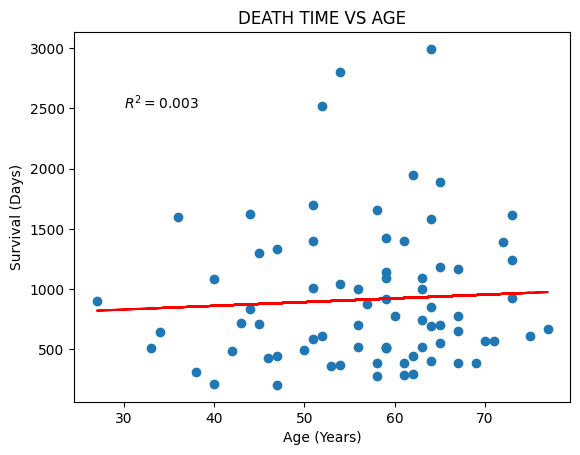

In [ ]:
# THERE'S NO CORRELATION BETWEEN SURVIVAL TIME AND AGE
age_time_corr = pearsonr(x = age_array,y = death_array)
r2 = round(age_time_corr[0]**2,3)

ajuste_age_time = linregress(age_array,death_array)
slope = ajuste_age_time[0]
intercept = ajuste_age_time[1]

plt.scatter(age_array,death_array)
plt.title('DEATH TIME VS AGE')

plt.text(30,2500,r'$R^2 = $'+ str(r2))
plt.plot(age_array,intercept + slope*age_array,'r')
plt.xlabel('Age (Years)')
plt.ylabel('Survival (Days)')

## LESIONS DATA

### SOME MANIPULATIONS (NOT ESSENTIAL)

HERE WE OBTAIN MATRICES FOR THE EVOLUTION OF THE DATA FOR EACH LESION\
BUT IN THE END WE WILL ONLY USE ONE OF THEM (PROBABLY) MAYBE USE MORE OF THEM FOR PREDICTING SURVIVAL/CAUSE OF DEATH, ADDING COLUMNS LIKE A TIME SERIES

In [ ]:
# MORPHOLOGICAL MEASURES MATRIX: mat_MM
# CLINICAL DATA MATRIX: mat_CD
'''
WE HAVE A MATRIX THAT CONTAINS THE SAME INFORMATION
AS THE DATAFRAME. TO PICK AN ELEMENT OF THE MATRIX,
mat_MM[i,j], i IS DE ROW INDEX, j IS THE COLUMN
INDEX. IF WE WANT THE LESION THAT CORRESPONDS TO THE
2ND ROW, WE PICK mat_MM[2,2].
'''
# PATIENT IDS IN CLINICAL DATA ARE STRS, WE CHANGE THEM TO NUMERICAL VALUES

for i in range(mat_CD.shape[0]):
  mat_CD[i,0] = int(mat_CD[i,0])


#OUR START MATRIX
mat = mat_CD[:,[0,4]]

mat = np.column_stack((mat,mat_CD[:,[1,2,3]])) #WE ADD COLUMNS TO OUR MATRIX

# FOR NOW WE HAVE IN THE MATRIX mat AGE, GPA & SEX


mat2 = mat[:,:2]

vol = np.zeros((154,6)) #TOTALVOLUME

times = np.zeros((154,6)) #DATES

width = np.zeros((154,6)) #CERIMWIDTH

totsurf = np.zeros((154,6)) #TOTALSURFACE

surfreg = np.zeros((154,6)) #SURFACE REGULARITY

#ROW INDEX
i = 0
#COLUMN INDEX
j = 0
#IF mat2[i,1]==mat_MM[k,1] & mat2[i,0]==mat_MM[k,0] WE ARE TALKING ABOUT THE SAME LESION FROM THE SAME PATIENT

for u in range(154):
  for k in range(1,len(mat_MM)+1):
    if mat2[u,0] == mat_MM[k-1,0]:
      if mat2[u,1] == mat_MM[k-1,2]:
        vol[u,j] = mat_MM[k-1,3]
        times[u,j] = mat_MM[k-1,1]
        width[u,j] = mat_MM[k-1,6]
        totsurf[u,j] = mat_MM[k-1,8]
        surfreg[u,j] = mat_MM[k-1,10]
        j = j+1

  j = 0

Text(0.5, 1.0, 'VOLUME EVOLUTION OF THE LESIONS')

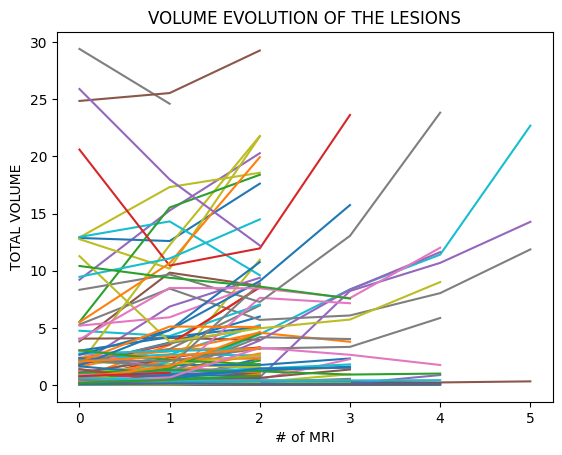

In [ ]:
for i in vol:
  plt.plot(np.delete(i,np.where(i==0)))

plt.xlabel('# of MRI')
plt.ylabel('TOTAL VOLUME')
plt.title('VOLUME EVOLUTION OF THE LESIONS')

Text(0.5, 1.0, 'WIDTH EVOLUTION OF THE LESIONS')

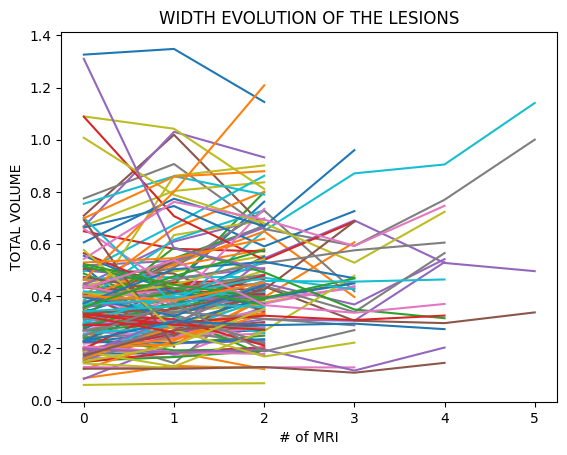

In [ ]:
for i in width:
  plt.plot(np.delete(i,np.where(i==0)))

plt.xlabel('# of MRI')
plt.ylabel('TOTAL VOLUME')
plt.title('WIDTH EVOLUTION OF THE LESIONS')

Text(0.5, 1.0, 'SURFACE REGULARITY EVOLUTION OF THE LESIONS')

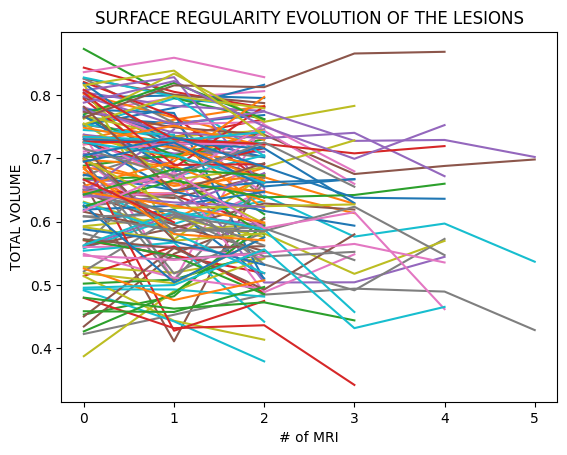

In [ ]:
for i in surfreg:
  plt.plot(np.delete(i,np.where(i==0)))

plt.xlabel('# of MRI')
plt.ylabel('TOTAL VOLUME')
plt.title('SURFACE REGULARITY EVOLUTION OF THE LESIONS')

### MORE IMPORTANT MANIPULATIONS

**TIMES**\
RIGHT NOW OUR CLINCAL DATA IS NOT COMPATIBLE WITH MORPHOLOGICAL MEASURES
AS CD HAS ITS DATES IN RELATIVE DAYS SINCE MR1 AND MM HAS ABSOLUTE DAYS. NOW WE WILL CHANGE OUR MRIS' DATES TO DAYS  

In [ ]:
times_new = np.zeros_like(times)
times_new0 = np.zeros_like(times)

for u in range(len(times)):
  if mat_CD[u-1,0]!= mat_CD[u,0]:
    fecha0 = times[u,0]

    arr11 = np.delete(times[u],np.where(times[u]==0))
    arr2 = np.zeros_like(arr11)

    for i in range(1,len(arr11)):
      arr2[i] = datesdiff(arr11[i-1],arr11[i])+arr2[i-1]
    l = len(arr2)
    times_new0[u,:l] = arr2

  else:
    arr12 = np.delete(times[u],np.where(times[u]==0))

    arr2 = np.zeros_like(arr12)
    for i in range(1,len(arr12)):
      arr2[i] = datesdiff(arr12[i-1],arr12[i])+ arr2[i-1]

    arr2 = arr2 + datesdiff(fecha0,arr12[0])

    l = len(arr2)
    times_new0[u,:l] = arr2

NOW WE WANT THE DAYS BETWEEN CONSECUTIVE MRIS, AS WE WILL NEED IT FOR THE MODEL

In [ ]:
times_rel = [] #DAYS BETWEEN CONSECUTIVE MRIS

for i in times_new0:
  for j in range(len(i)-1):
    if i[j+1]!=0:
      times_rel.append(i[j+1]-i[j])

#### VOLUME EVOLUTION FOR EVERY LESION

AN EXAMPLE OF A PATIENT, ITS LESIONS AND ITS TREATMENTS

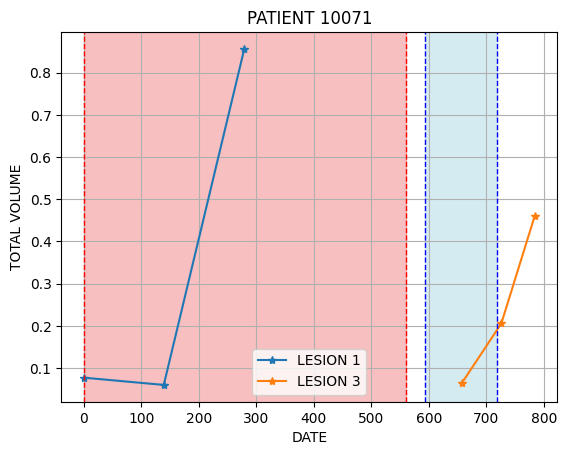

In [ ]:
u = 46

arr11 = np.delete(times[u],np.where(times[u]==0))

arr2 = np.zeros_like(arr11)
for i in range(1,len(arr11)):
  arr2[i] = datesdiff(arr11[i-1],arr11[i])+arr2[i-1]
times_new[u,:3] = arr2

plt.plot(arr2,np.delete(vol[u],np.where(vol[u]==0)),'*-',label='LESION 1')

u = 47

arr12 = np.delete(times[u],np.where(times[u]==0))

arr2 = np.zeros_like(arr12)
for i in range(1,len(arr12)):
  arr2[i] = datesdiff(arr12[i-1],arr12[i])+ arr2[i-1]

arr2 = arr2 + datesdiff(arr11[0],arr12[0])

times_new[u,:3] = arr2

plt.plot(arr2,np.delete(vol[u],np.where(vol[u]==0)),'*-',label='LESION 3')


plt.title('PATIENT 10071')
plt.grid()
plt.legend()
plt.xlabel('DATE')
plt.ylabel('TOTAL VOLUME')


# VERTICAL LINES
plt.axvline(0, color = "red", linewidth = 1, linestyle = "dashed"); # BEGIN TREATMENT 1
plt.axvline(561, color = "red", linewidth = 1, linestyle = "dashed"); # END TREATMENT 1
plt.axvline(594, color = "blue", linewidth = 1, linestyle = "dashed"); # BEGIN TREATMENT 2
plt.axvline(718, color = "blue", linewidth = 1, linestyle = "dashed"); # END TREATMENT 2

# FRANJAS DE COLOR
plt.axvspan(0, 561, alpha=0.5, color='lightcoral') # TREATMENT 1
plt.axvspan(594, 718, alpha=0.5, color='lightblue') # TREATMENT 2


NOW WE WILL PLOT, FOR EACH PATIENT, HOW THE LESIONS EVOLVE

WE CAN SEE 2 IMPORTANT FEATURES OF OUR DATASET:
* REGARDING THE TOTAL VOLUME (SUMMING EVERY LESION) OF EACH PATIENT, WE CANNOT TREAT THE PATIENT AS A WHOLE. WE MUST TREAT THE EVOLUTION OF EACH LESION INDEPENDENTLY.  
* CHAOS & VARIABILITY: SOME LESIONS APPEAR, OTHERS DISAPPEAR... NOT ENOUGH DATA

<ipython-input-41-bee2f214f5c7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


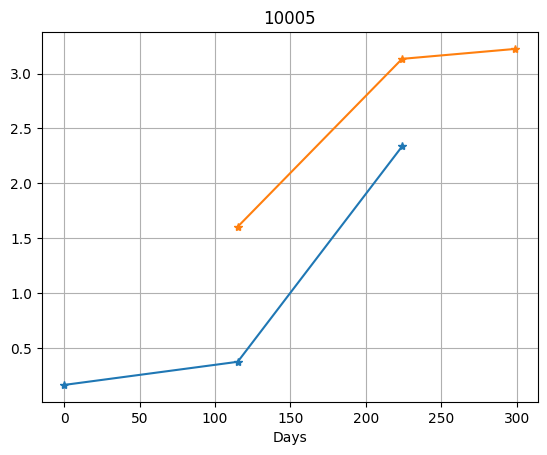

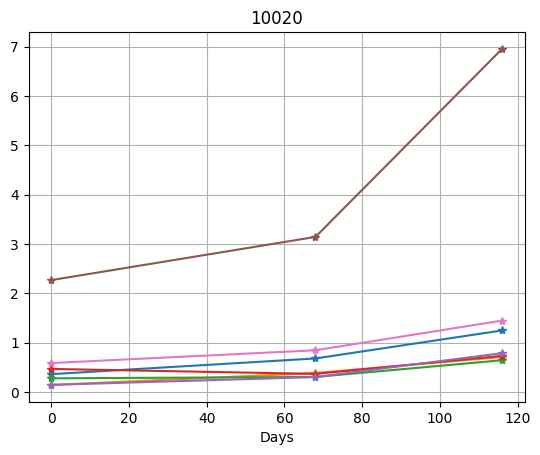

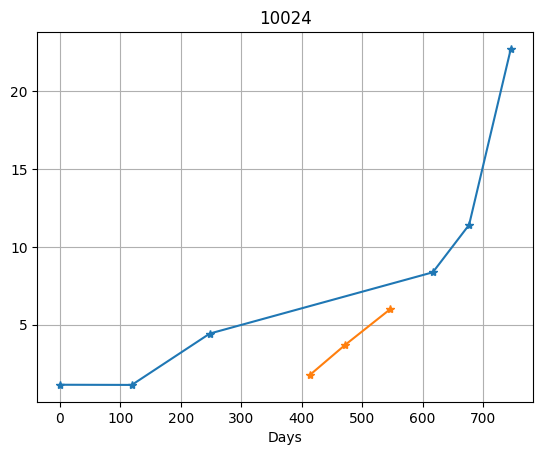

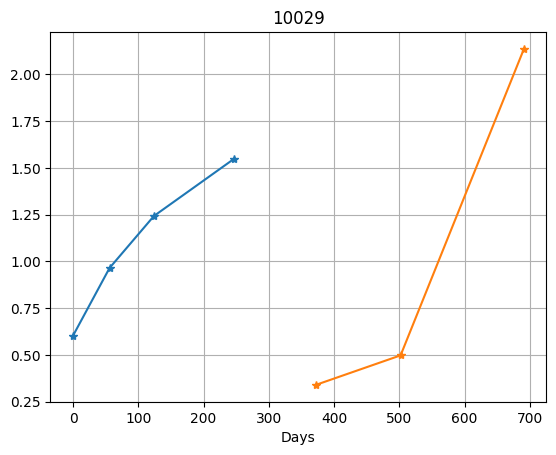

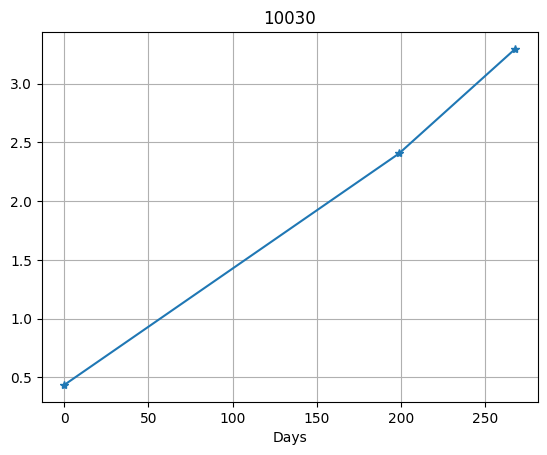

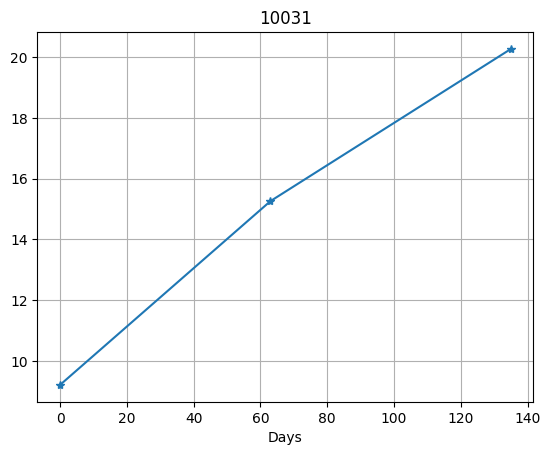

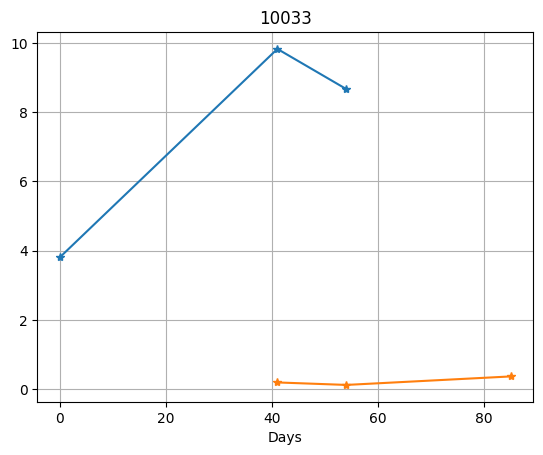

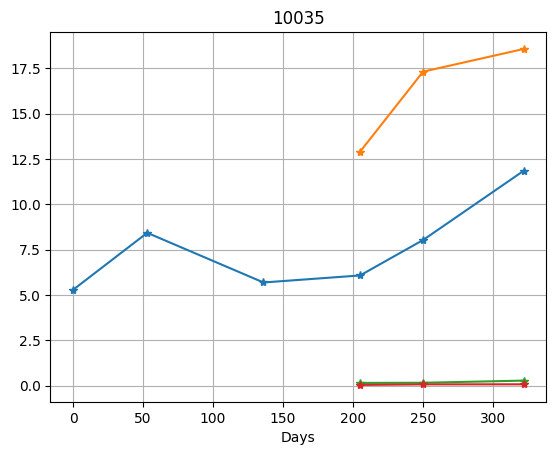

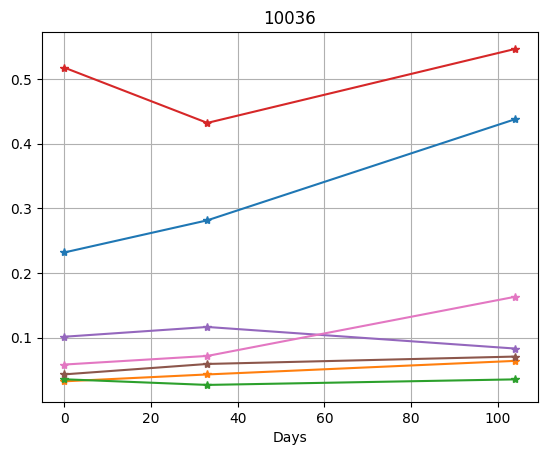

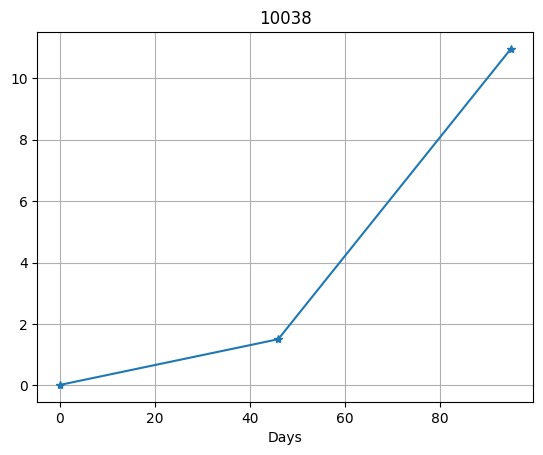

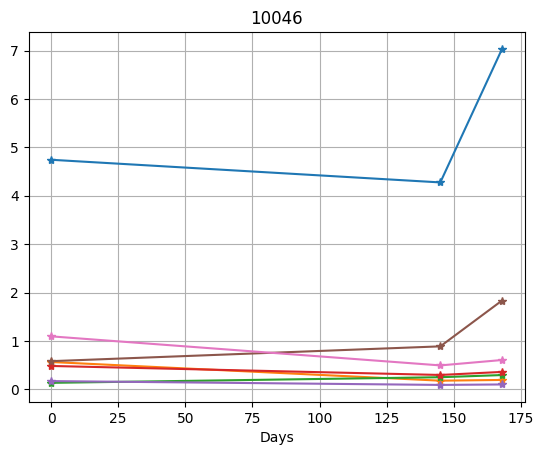

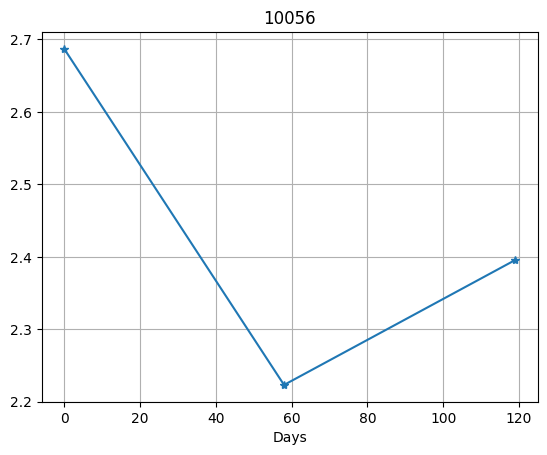

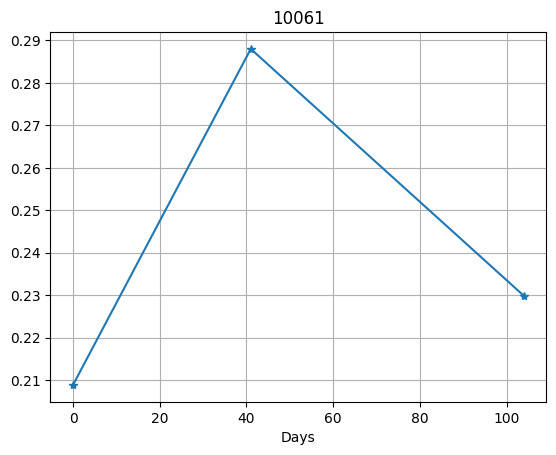

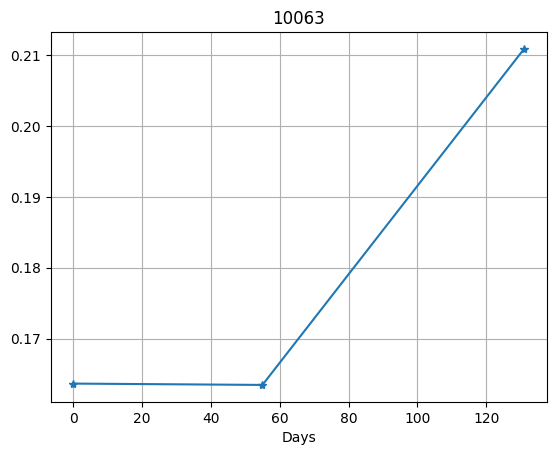

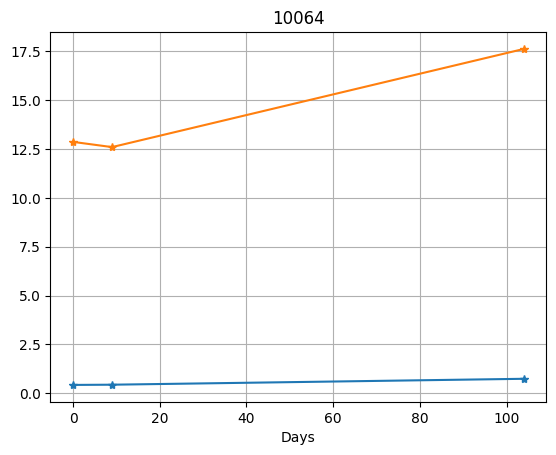

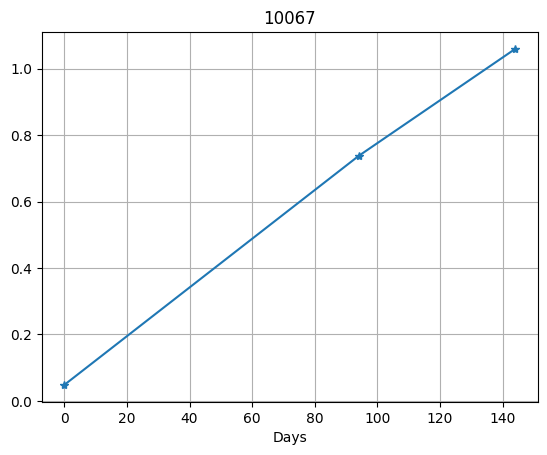

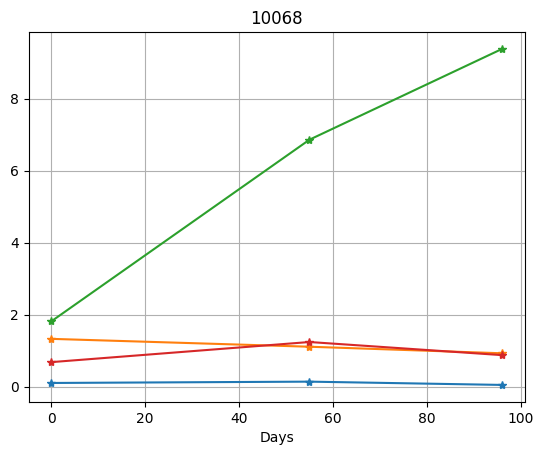

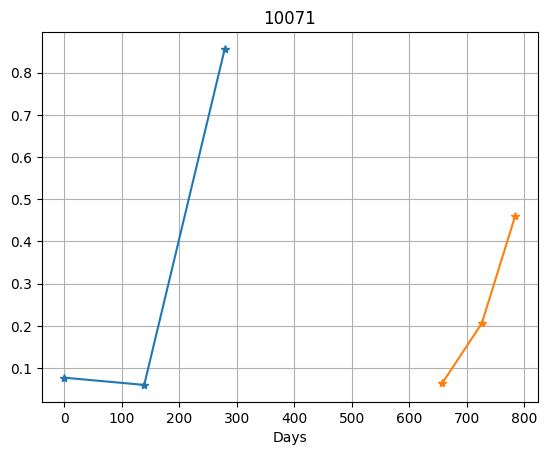

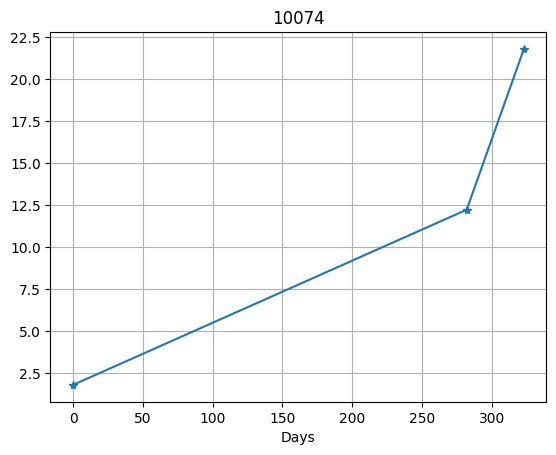

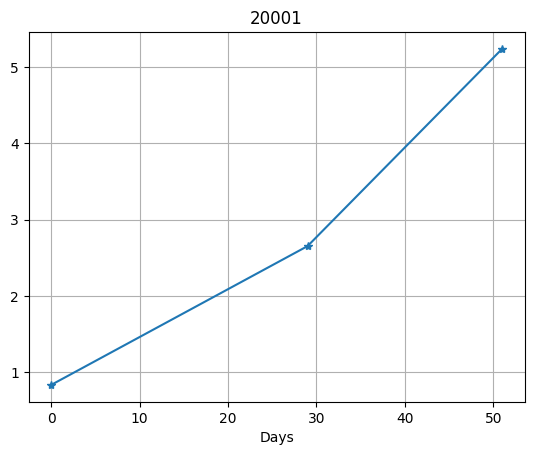

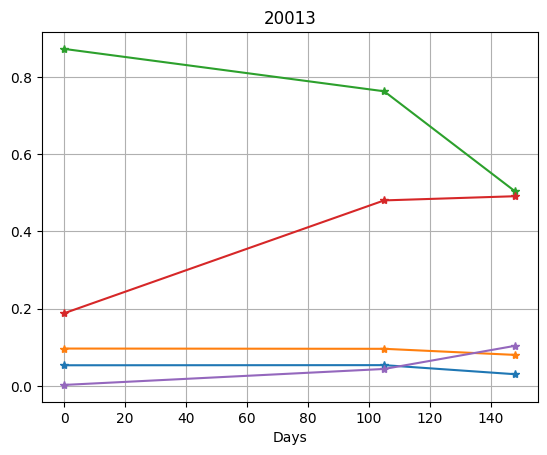

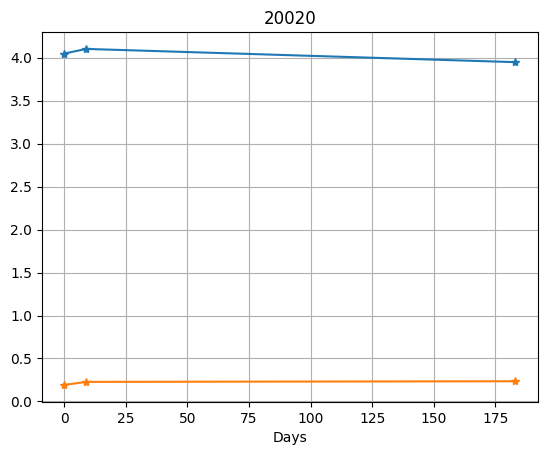

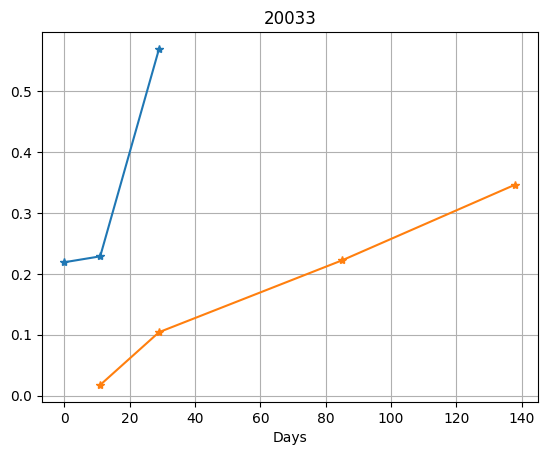

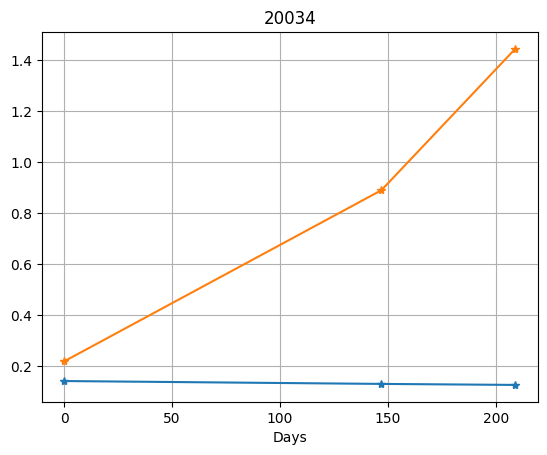

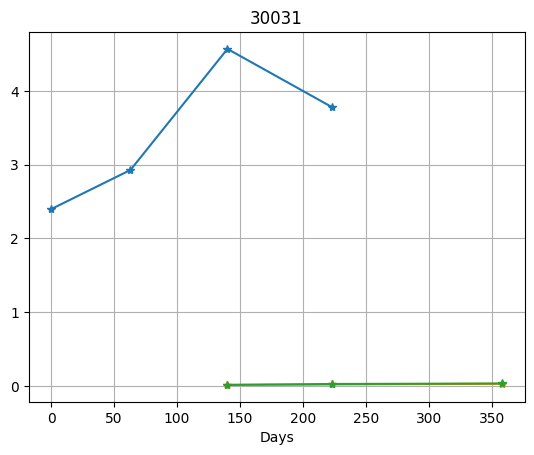

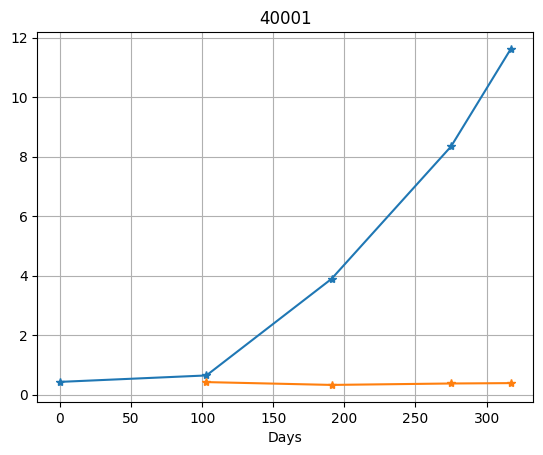

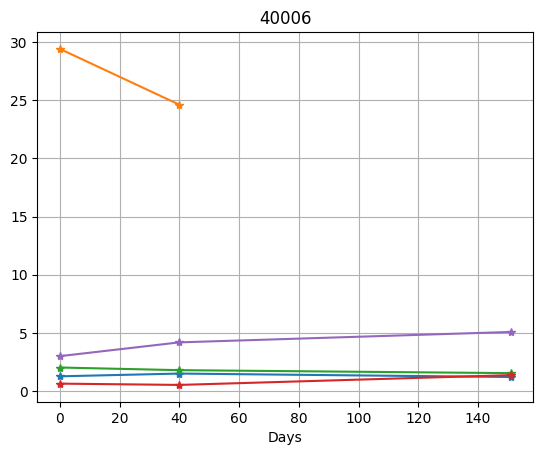

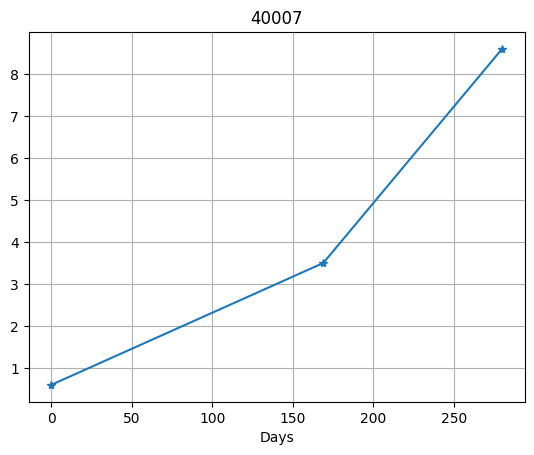

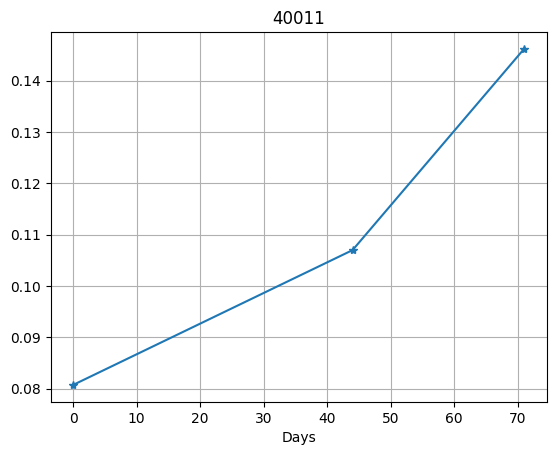

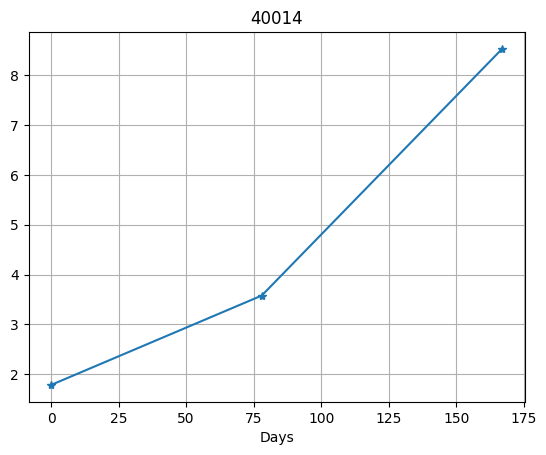

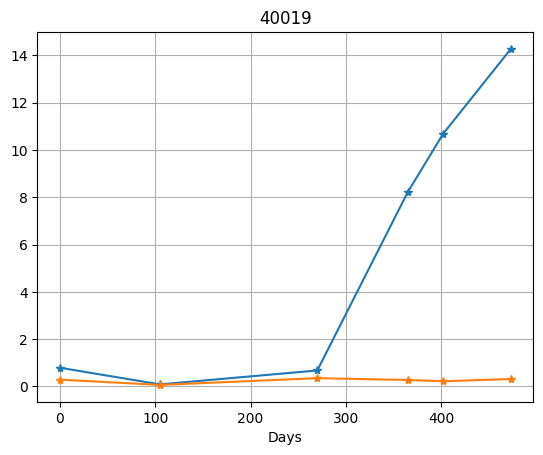

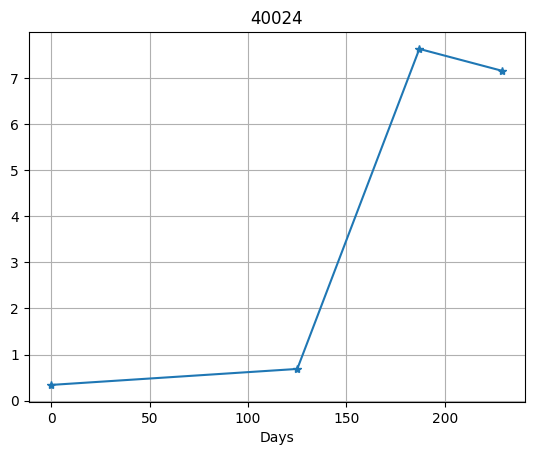

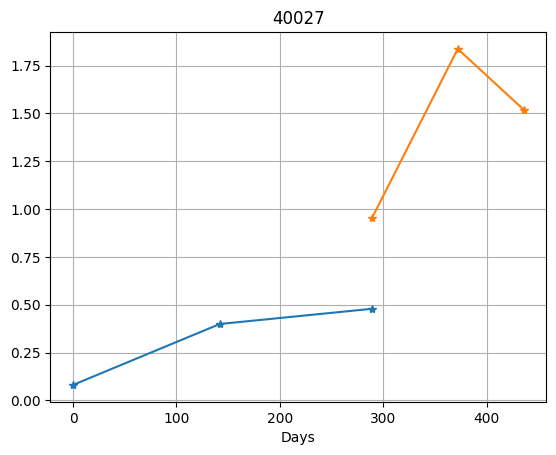

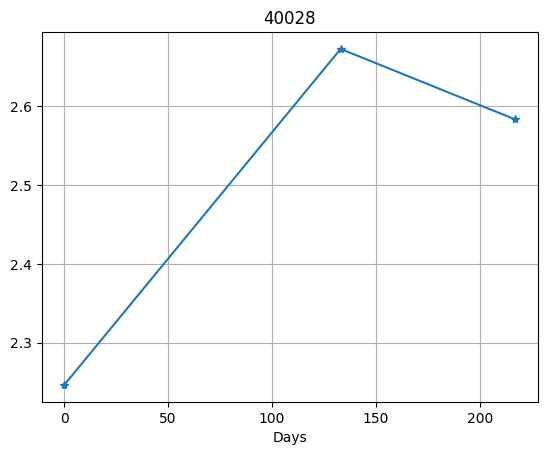

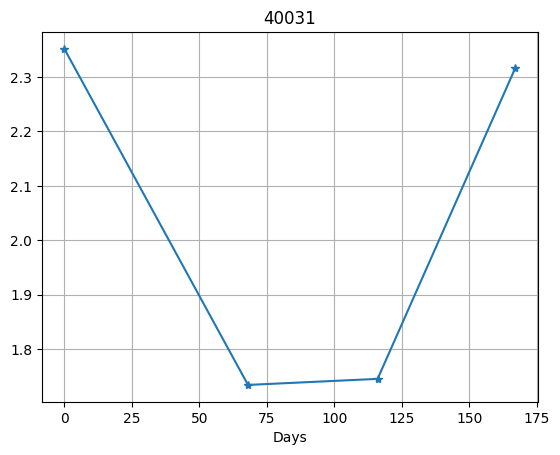

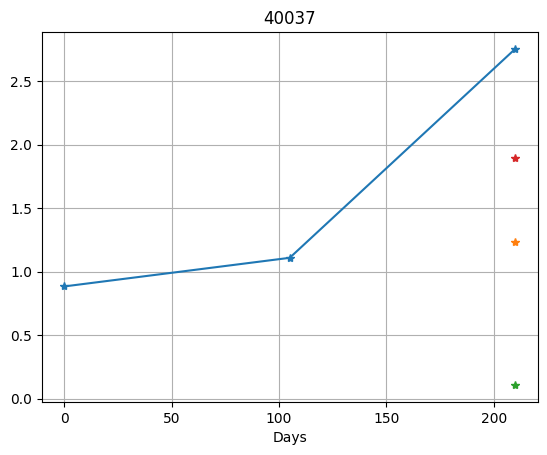

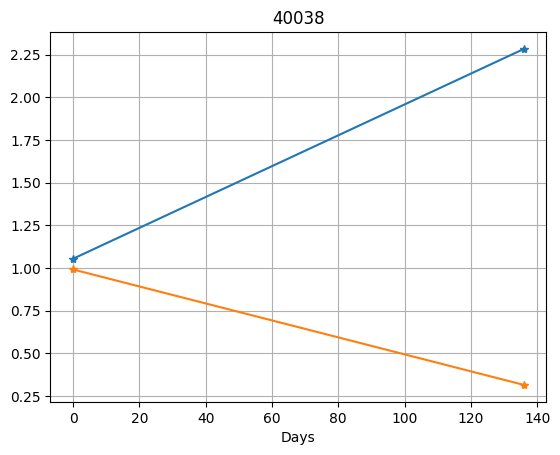

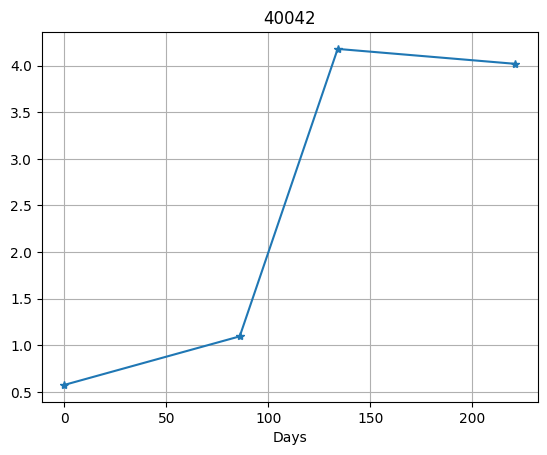

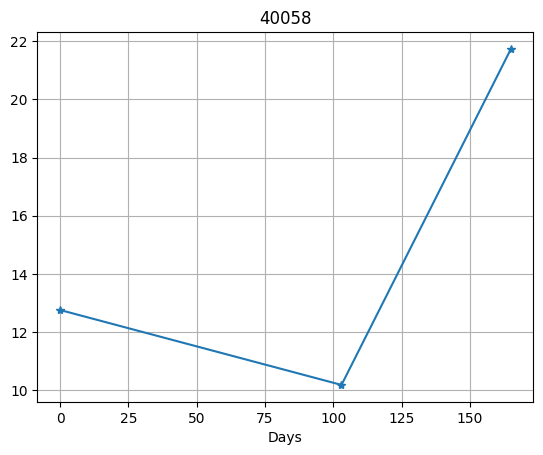

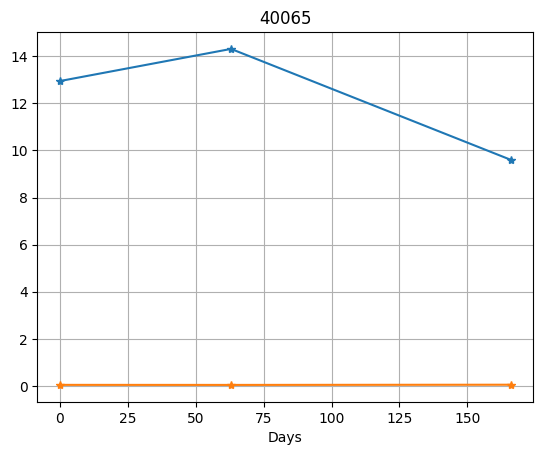

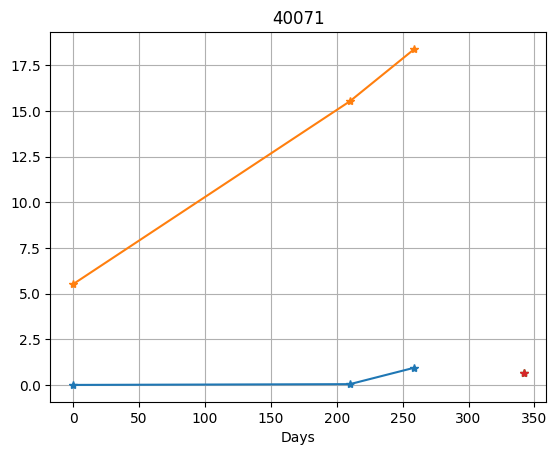

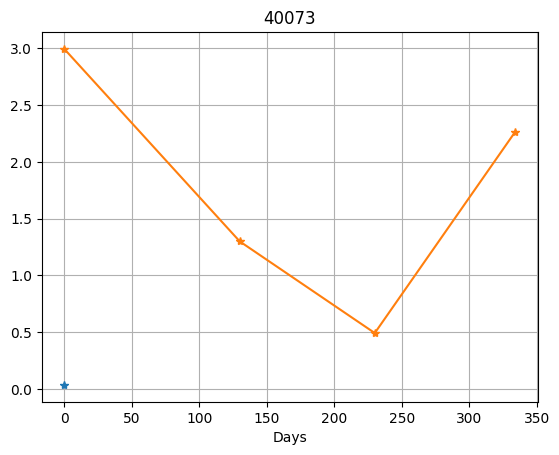

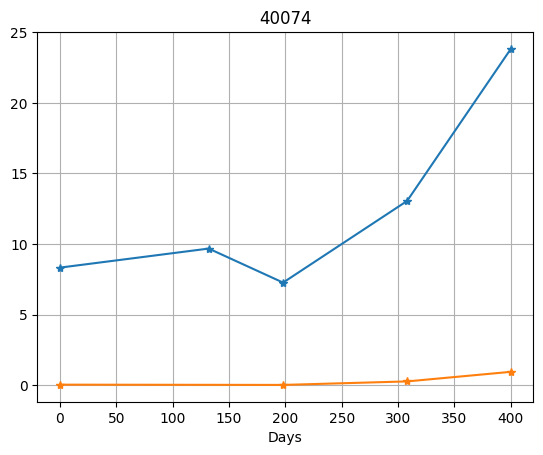

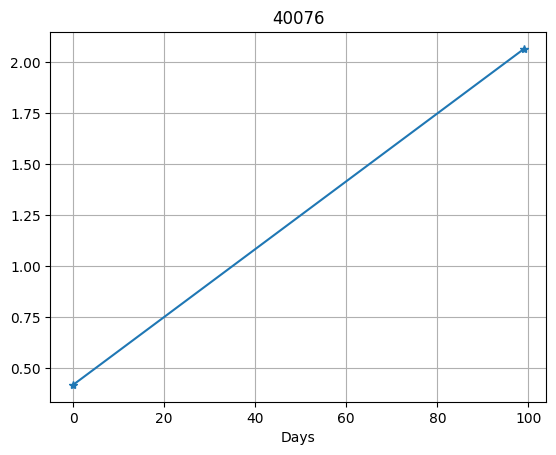

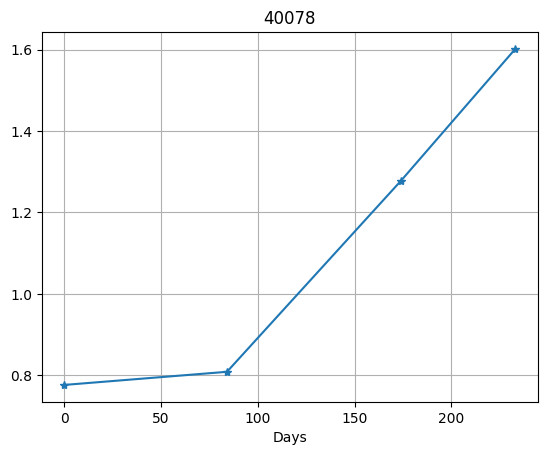

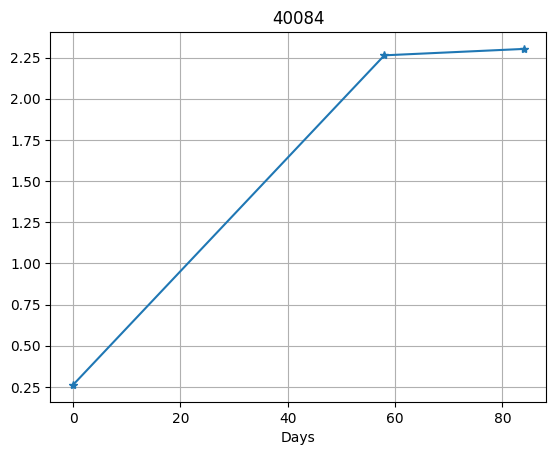

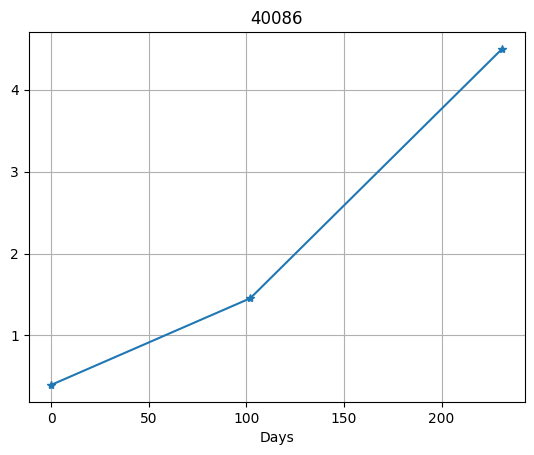

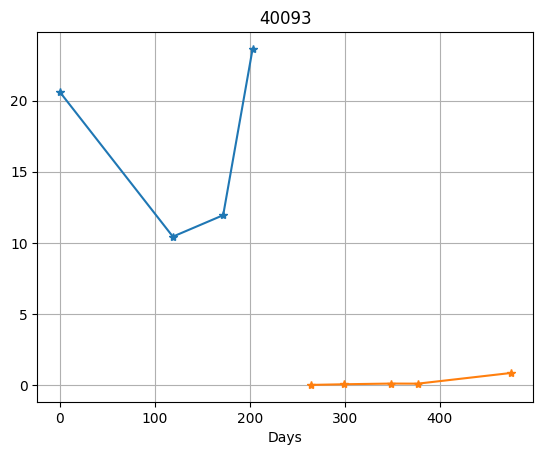

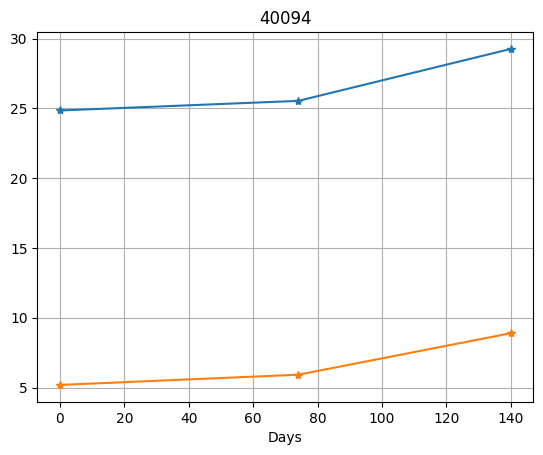

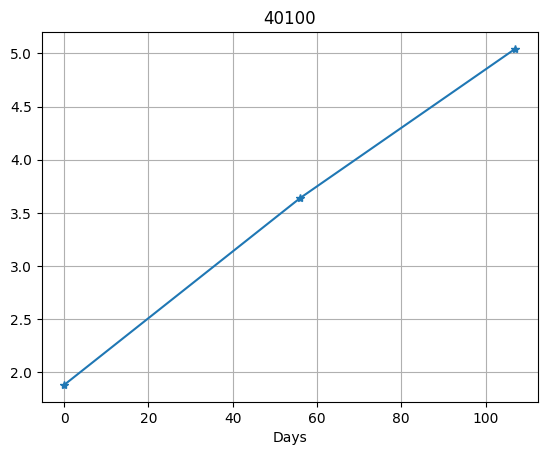

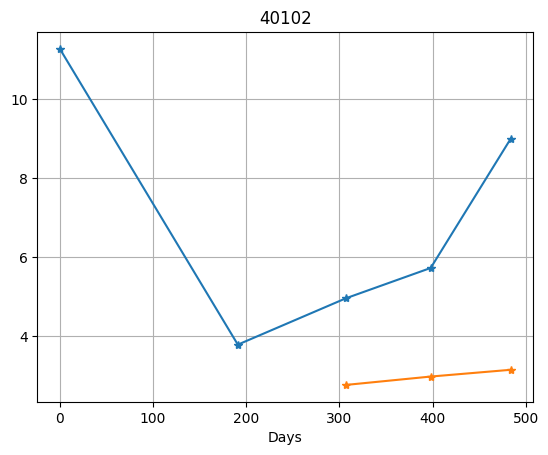

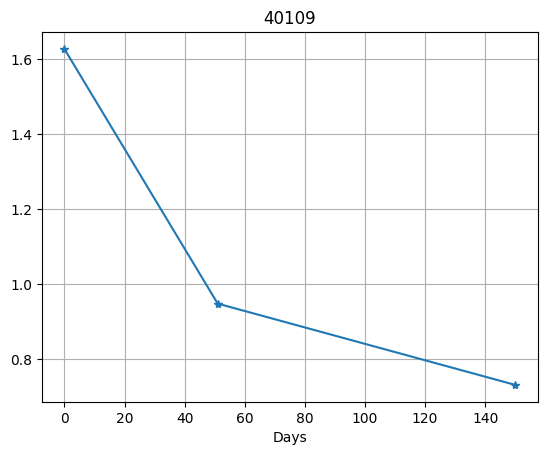

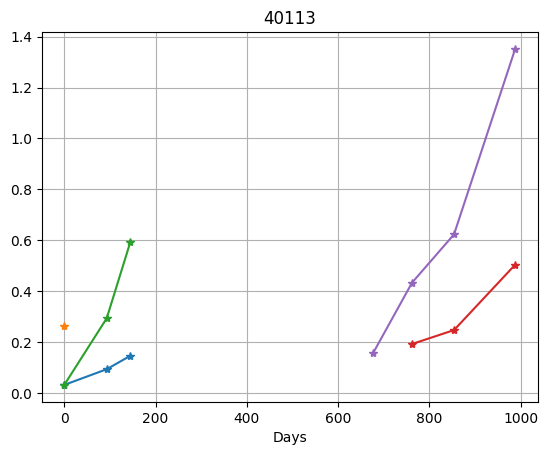

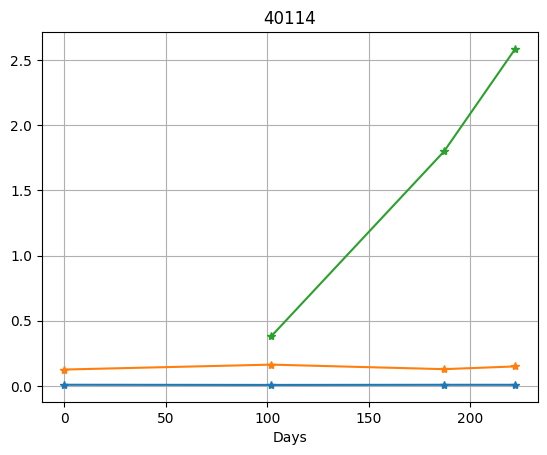

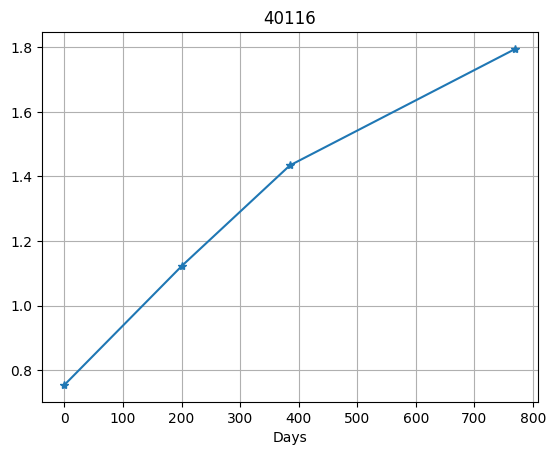

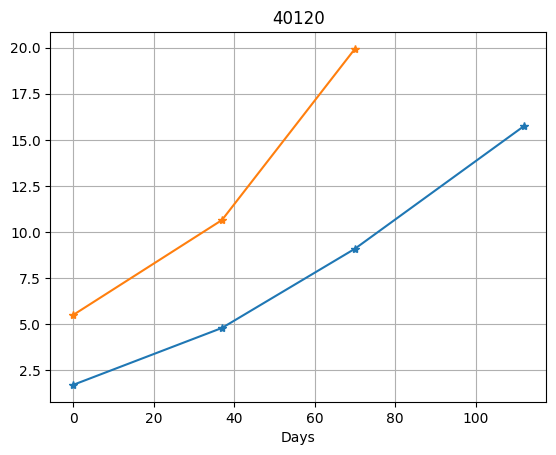

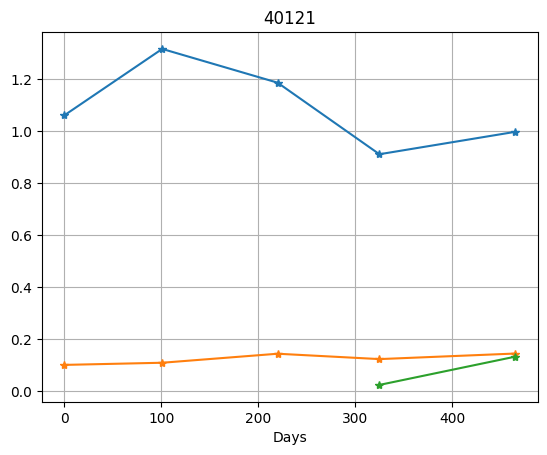

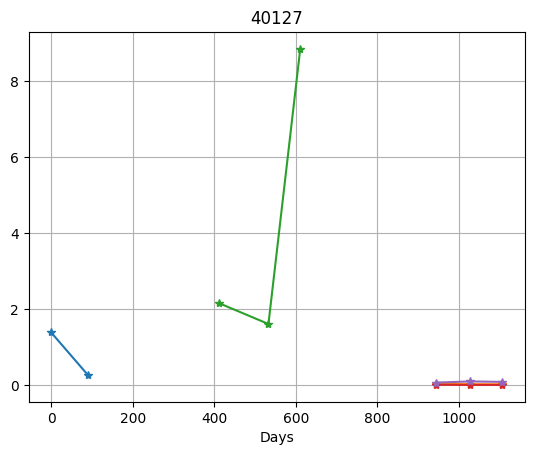

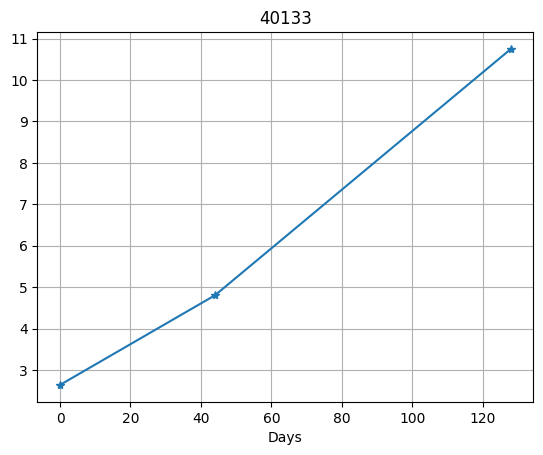

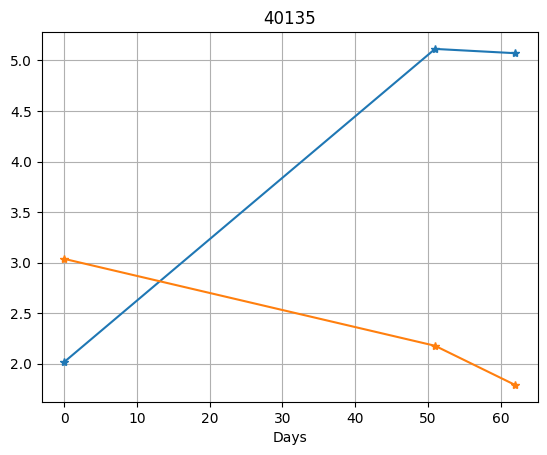

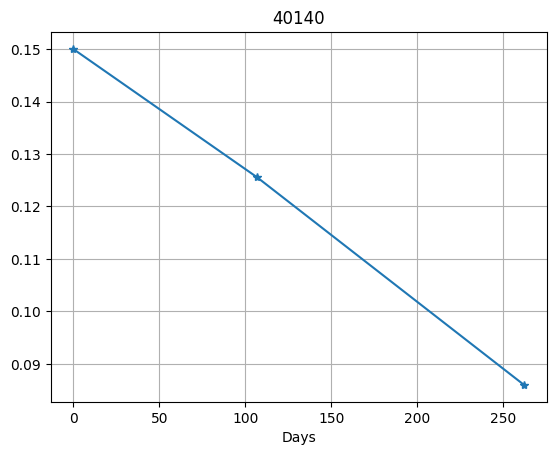

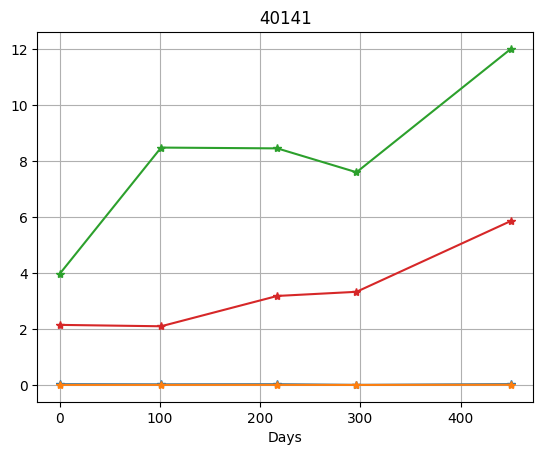

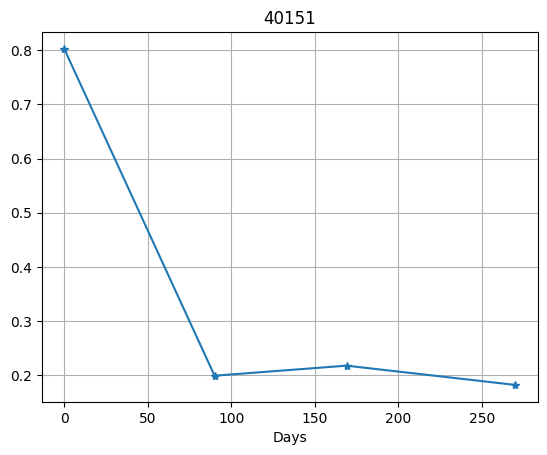

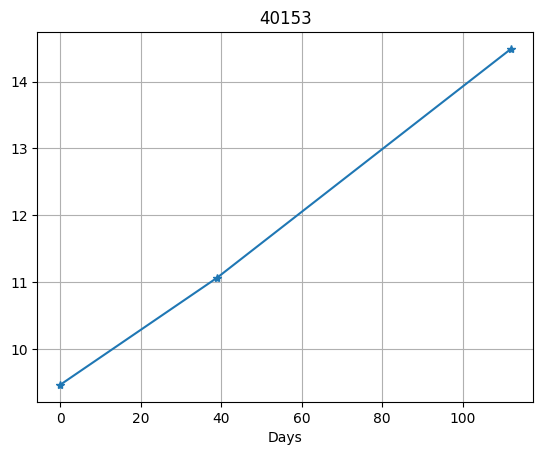

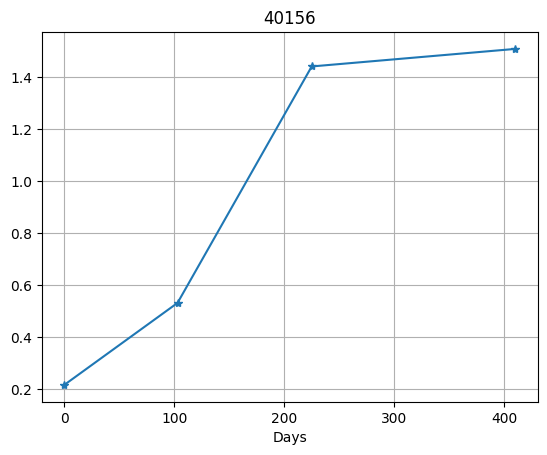

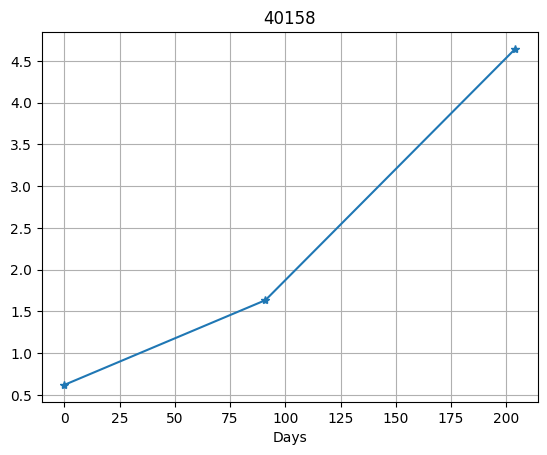

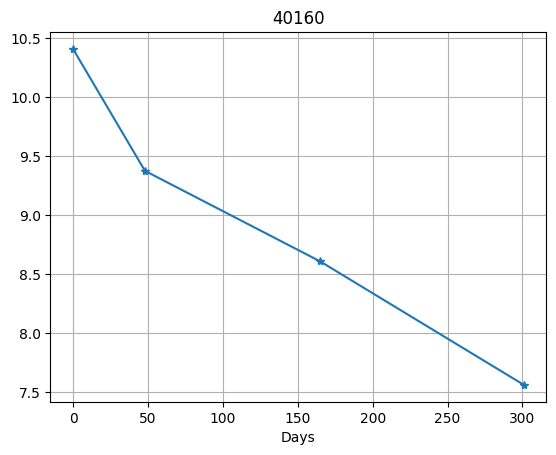

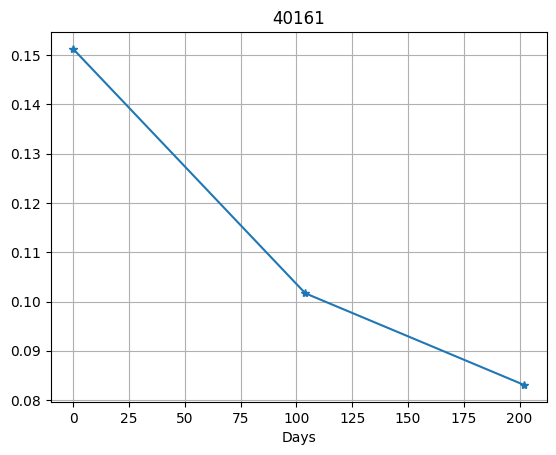

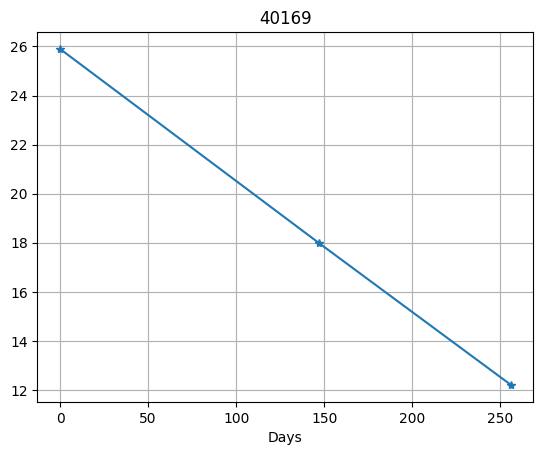

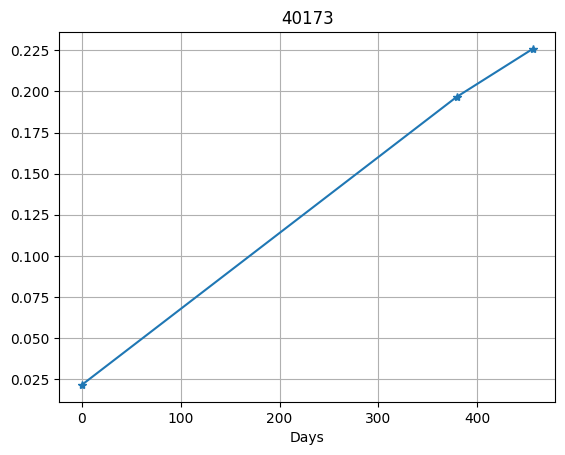

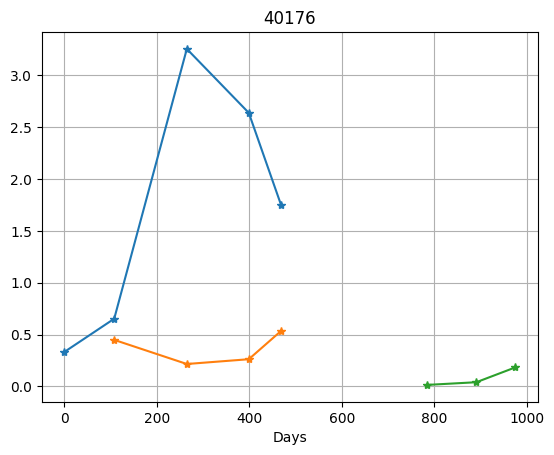

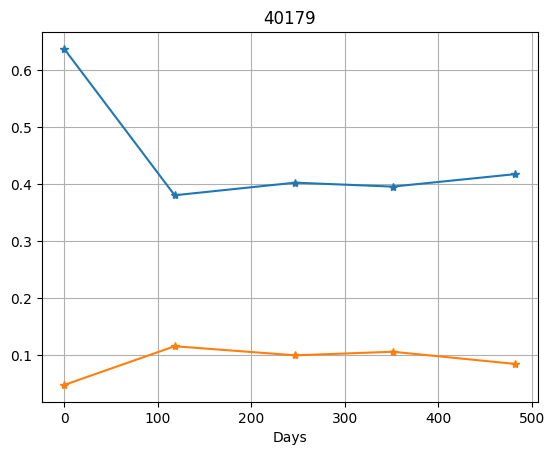

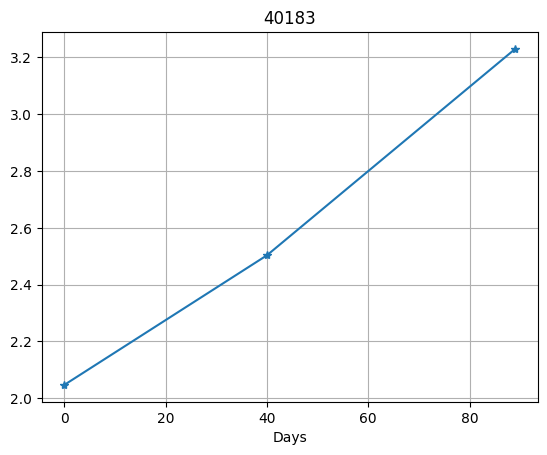

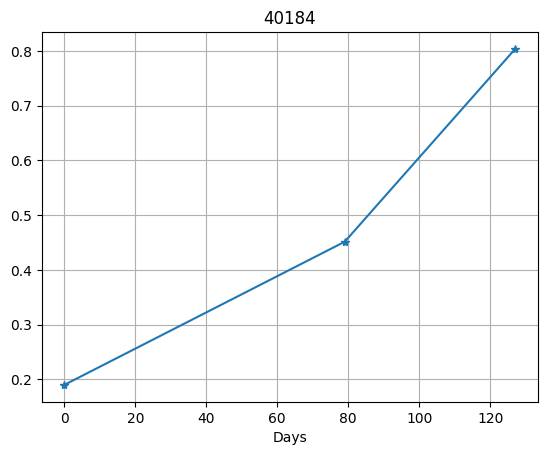

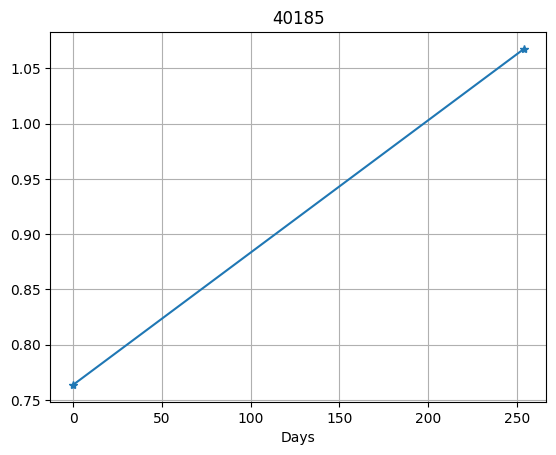

In [ ]:
u = 0
for i in range(len(patient_array)):
  plt.figure()
  plt.title('%i'%patient_array[i])
  plt.xlabel('Days')
  plt.grid()
  for j in range(int(nlesions[i])):
    plt.plot(times_new0[u,:len(np.delete(vol[u],np.where(vol[u]==0)))],np.delete(vol[u],np.where(vol[u]==0)),'*-')

    u = u+1


# 4. OBTAINING NEW VARIABLES FOR THE MODELS

NOW WE WILL OBTAIN NEW VARIABLES FOR THE SECTION 6: OBJECTIVE 2. OUR GOAL IS TO PREDICT IF, FROM THE DATA OF ONE MRI, THE VOLUME OF A LESION WILL GROW MORE THAN 30%. THEREFORE, NOW WE HAVE 499 ROWS, FOR EACH DATA POINT FROM EACH LESION

## STEREOTACTIC RADIOSURGERY & DAYS SINCE SURGERY

In [ ]:
df_MM2 = df_MM.sort_values(by=['PATIENT', 'LESION', 'TIME POINT'])

mat_MM2 = np.matrix(df_MM2)

array_times = []
for i in times_new0:
  array_times.append(0)
  for j in range(1,len(i)):
    if i[j] != 0:
      array_times.append(i[j])


df_srs = df_CD[['ID','LESION','Dosis/Frac','Nfrac.2','Begin.2','End.2']]
df_srs = df_srs.fillna(0)
mat_srs = np.matrix(df_srs)

# IF THERE HAS BEEN SRS BEFORE THE MRI
srs=np.zeros(499)

# DAYS SINCE SURGERY (0 IF NO SURGERY) ----> PROBLEM!!!

srsd = np.zeros(499)

for i in mat_srs:
  if i[0,3]!= 0:
    for k in range(len(mat_MM2)):
      if int(i[0,0]) == mat_MM2[k,0] and i[0,1] == mat_MM2[k,2]:
        if i[0,5]== ' ' and i[0,4]!= ' ':
          if i[0,4]< array_times[k]:
            srs[k] = 1
            srsd[k] = array_times[k]-i[0,4]
        elif i[0,5]!=' ':
          if i[0,5]< array_times[k]:
            srs[k] = 1
            srsd[k] = array_times[k]-i[0,5]

## WHOLE BRAIN RADIATION THERAPY

In [ ]:
df_wbrt = df_CD[['ID','LESION','Dose/Frac','Nfrac','Begin','End']]
df_wbrt = df_wbrt.fillna(0)
df_wbrt.head()

mat_wbrt = np.matrix(df_wbrt)


# IF THERE HAS BEEN WBRT BEFORE THE MRI
wbrt=np.zeros(499)

# DAYS SINCE THERAPY (0 IF NO THERAPY) ----> PROBLEM!!!
wbrtd = np.zeros(499)


for i in mat_wbrt:
  if i[0,3]!= 0:
    for k in range(len(mat_MM2)):
      if int(i[0,0]) == mat_MM2[k,0] and i[0,1] == mat_MM2[k,2]:
        if i[0,5]== ' ' and i[0,4]!= ' ':
          if i[0,4]< array_times[k]:
            wbrt[k] = 1
            wbrtd[k] = array_times[k]-i[0,4]
        elif i[0,5]!=' ':
          if i[0,5]< array_times[k]:
            wbrt[k] = 1
            wbrtd[k] = array_times[k]-i[0,5]

## SYSTEMIC TREATMENT 1

In [ ]:
df_med1 = df_CD[['ID','LESION','Drug','Begin.5','End.5']]
df_med1= df_med1.fillna(0) # NAN -> 0


#HERE WE WILL NEED TO USE TIMES_NEW0
mat_st1 = np.matrix(df_med1)
mat_st1[mat_st1 == ' ']=0 # NO_DATA -> 0
len(mat_st1)==len(times_new0)

True

In [ ]:
mat_st1[0]

matrix([['010005', 1.0, 1.0, -19, 104]], dtype=object)

In [ ]:
times_new0[0]

array([  0., 115., 224.,   0.,   0.,   0.])

A LITTLE FIGURE THAT SHOWS VISUALLY THE CODE BELOW

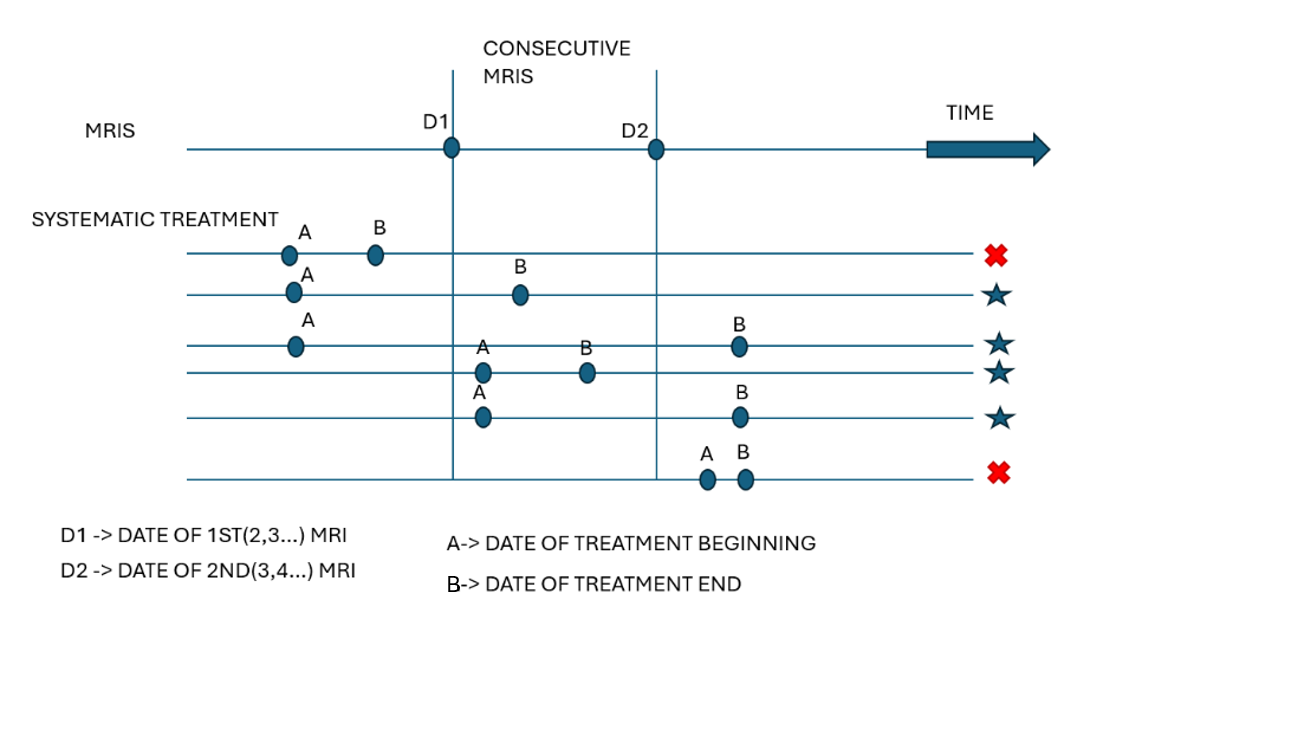

In [ ]:
# TREATMENT BETWEEN CONSECUTIVE MRIS

drug = []

#DURATION OF THE TREATMENT

drug_days = []


for i in range(len(mat_st1)):
  A = mat_st1[i,3]
  B = mat_st1[i,4]
  d = mat_st1[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug.append(0)
        drug_days.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug.append(d)
          drug_days.append(B-D1)
        elif B>= D2:
          drug.append(d)
          drug_days.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug.append(d)
          drug_days.append(D2-A)
        elif B< D2:
          drug.append(d)
          drug_days.append(B-A)
      else:
        drug.append(0)
        drug_days.append(0)

Text(0.5, 1.0, 'Distribution of Sys. Treatment 1 between consecutive MRIs')

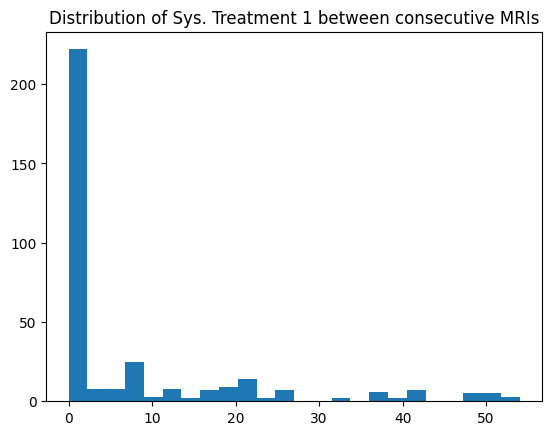

In [ ]:
plt.hist(drug,bins='auto')
plt.title('Distribution of Sys. Treatment 1 between consecutive MRIs')

WE SEE THAT MOST OF THE TIMES THERE IS NOT TREATMENT, AT LEAST TREATMENT 1

## MORE TREATMENTS

THIS DATA IS NOT APPLIED IN THIS CODE, BECAUSE IT DID NOT HAVE MUCH INFLUENCE ON THE RESULTS. FOR THE SAKE OF SIMPLICITY, WE WILL ONLY CONSIDER SYSTEMATIC TREATMENT 1. HOWEVER, THE FOLLOWING INFORMATION WOULD BE ESSENTIAL FOR A MORE EXHAUSTIVE STUDY, AS CONTAINS IMPORTANT FEATURES OF THE DATA.




HERE WE REPEAT THE SAME FOR OTHER SYSTEMATIC TREATMENTS

In [ ]:
df_med2 = df_CD[['ID','LESION','Drug.1','Begin.6','End.6']]
df_med2= df_med2.fillna(0)
mat_st2 = np.matrix(df_med2)
mat_st2[mat_st2 == ' ']=0

In [ ]:
drug2 = []

#DURATION OF THE TREATMENT

drug_days2 = []


for i in range(len(mat_st2)):
  A = mat_st2[i,3]
  B = mat_st2[i,4]
  d = mat_st2[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug2.append(0)
        drug_days2.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug2.append(d)
          drug_days2.append(B-D1)
        elif B>= D2:
          drug2.append(d)
          drug_days2.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug2.append(d)
          drug_days2.append(D2-A)
        elif B< D2:
          drug2.append(d)
          drug_days2.append(B-A)
      else:
        drug2.append(0)
        drug_days2.append(0)


In [ ]:
df_med3 = df_CD[['ID','LESION','Drug.2','Begin.7','End.7']]
df_med3= df_med3.fillna(0)
mat_st3 = np.matrix(df_med3)
mat_st3[mat_st3 == ' ']=0


drug3 = []

#DURATION OF THE TREATMENT

drug_days3 = []


for i in range(len(mat_st3)):
  A = mat_st3[i,3]
  B = mat_st3[i,4]
  d = mat_st3[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug3.append(0)
        drug_days3.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug3.append(d)
          drug_days3.append(B-D1)
        elif B>= D2:
          drug3.append(d)
          drug_days3.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug3.append(d)
          drug_days3.append(D2-A)
        elif B< D2:
          drug3.append(d)
          drug_days3.append(B-A)
      else:
        drug3.append(0)
        drug_days3.append(0)



In [ ]:
df_med4 = df_CD[['ID','LESION','Drug.3','Begin.8','End.8']]
df_med4= df_med4.fillna(0)
mat_st4 = np.matrix(df_med4)
mat_st4[mat_st4 == ' ']=0


drug4 = []

#DURATION OF THE TREATMENT

drug_days4 = []


for i in range(len(mat_st4)):
  A = mat_st4[i,3]
  B = mat_st4[i,4]
  d = mat_st4[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug4.append(0)
        drug_days4.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug4.append(d)
          drug_days4.append(B-D1)
        elif B>= D2:
          drug4.append(d)
          drug_days4.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug4.append(d)
          drug_days4.append(D2-A)
        elif B< D2:
          drug4.append(d)
          drug_days4.append(B-A)
      else:
        drug4.append(0)
        drug_days4.append(0)


In [ ]:
df_med5 = df_CD[['ID','LESION','Drug.4','Begin.9','End.9']]
df_med5= df_med5.fillna(0)
mat_st5 = np.matrix(df_med5)
mat_st5[mat_st5 == ' ']=0


drug5 = []

#DURATION OF THE TREATMENT

drug_days5 = []


for i in range(len(mat_st5)):
  A = mat_st5[i,3]
  B = mat_st5[i,4]
  d = mat_st5[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug5.append(0)
        drug_days5.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug5.append(d)
          drug_days5.append(B-D1)
        elif B>= D2:
          drug5.append(d)
          drug_days5.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug5.append(d)
          drug_days5.append(D2-A)
        elif B< D2:
          drug5.append(d)
          drug_days5.append(B-A)
      else:
        drug5.append(0)
        drug_days5.append(0)


In [ ]:
df_med6 = df_CD[['ID','LESION','Drug.5','Begin.10','End.10']]
df_med6= df_med6.fillna(0)
mat_st6 = np.matrix(df_med6)
mat_st6[mat_st6 == ' ']=0


drug6 = []

#DURATION OF THE TREATMENT

drug_days6 = []


for i in range(len(mat_st6)):
  A = mat_st6[i,3]
  B = mat_st6[i,4]
  d = mat_st6[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug6.append(0)
        drug_days6.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug6.append(d)
          drug_days6.append(B-D1)
        elif B>= D2:
          drug6.append(d)
          drug_days6.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug6.append(d)
          drug_days6.append(D2-A)
        elif B< D2:
          drug6.append(d)
          drug_days6.append(B-A)
      else:
        drug6.append(0)
        drug_days6.append(0)


In [ ]:
drugs = np.column_stack((drug,drug2,drug3,drug4,drug5,drug6))
drugs_total = np.zeros((345,2))
for i in range(len(drugs)):
  if np.sum(drugs[i])!= 0:
    k = 0
    for j in drugs[i]:
      if j!=0:
        drugs_total[i,k]= j
        k +=1

In [ ]:
# IN DRUGSD WE HAVE EVERY TREATMENT WE HAVE CONSIDERED
drugsd = np.column_stack((drug_days,drug_days2,drug_days3,drug_days4,drug_days5,drug_days6,))

drugs_totald = np.zeros((345,2)) #THE MAX IS 2 DIFFERENT TREATMENTS BETWEEN CONSECUTIVE MRIS

for i in range(len(drugsd)):
  if np.sum(drugsd[i])!= 0:
    k = 0
    for j in drugsd[i]:
      if j!=0:
        drugs_totald[i,k]= j
        k +=1

In [ ]:
drugs_total_days = np.zeros(345)

for i in range(len(drugs_totald)):
  drugs_total_days[i] = np.sum(drugs_totald[i])

drugs_total_days # DAYS OF TREATMENT BETWEEN CONSECUTIVE MRIS

array([115., 109., 109.,  75.,  45.,  48.,  45.,  48.,  45.,  48.,  45.,
        48.,  45.,  48.,  45.,  48.,  45.,  48.,   0.,   0., 272.,   0.,
         0.,  58.,  65.,  56.,  68., 123., 130., 189., 166.,  69.,  63.,
        72.,  41.,  13.,  13.,  31.,  30.,  83.,  69.,  45.,  72.,  45.,
        72.,  45.,  72.,  45.,  72.,  26.,  71.,  26.,  71.,  26.,  71.,
        26.,  71.,  26.,  71.,  26.,  71.,  26.,  71.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  21.,  61.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,  44.,  41.,  44.,  41.,  44.,  41.,  44.,  41.,
         0.,   0.,  69.,  58.,  94.,  41.,  22.,   8.,   7.,   0.,   7.,
         0.,   7.,   0.,   7.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,  28., 147.,  62., 147.,  62.,  63.,  77.,
        83.,  83., 135.,  83., 135., 103.,  88.,  20.,   0.,  88.,  20.,
         0.,  40., 111.,  40.,  40., 111.,  40., 11

In [ ]:
drugs_total2 = np.zeros(149)
drugs_total2 = list(drugs_total2)

for i in drugs_total:
  for j in i:
    drugs_total2[int(j)] +=1

# The most repeated meds are:
# 0 = no med, 247 times
# 8 , 22 times
# 2 , 14 times
# 7 , 11 times
# WE ARE GOING TO CONSIDER ONLY THESE



# 0 = no med
# 1 = 8
# 2 = 2
# 3 = 7
# 4 = other


# RN IN drugs_total_days we have for the period between two consecutive mris the time of treatment,
# if there have been two treaments the time is sumed,
# if it is 0 there has been no treatment


drugs_ult = np.zeros(345)


for i in range(len(drugs_total)):
  d = np.sum(drugs_total[i])
  if d != 0:
    if d == 8:
      drugs_ult[i] = 1
    elif d == 2:
      drugs_ult[i] = 2
    elif d == 7:
      drugs_ult[i] = 3
    else:
      drugs_ult[i] = 4

([<matplotlib.axis.XTick at 0x7b4008e57a30>,
 [Text(0, 0, 'None'),
  Text(1, 0, 'Med #8'),
  Text(2, 0, 'Med #2'),
  Text(3, 0, 'Med #7'),
  Text(4, 0, 'Other med')])

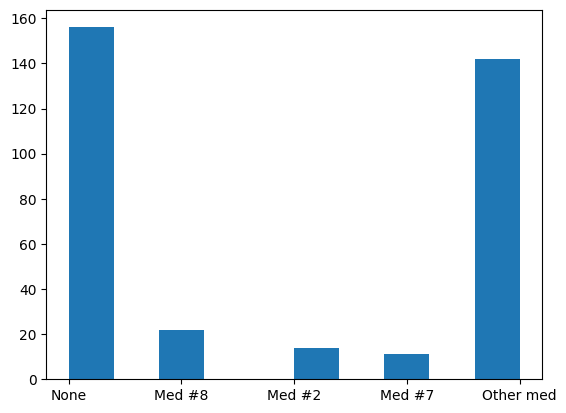

In [ ]:
plt.hist(drugs_ult,bins='auto')
plt.xticks([0,1,2,3,4],['None','Med #8','Med #2','Med #7','Other med'],rotation=0)


#6. OBJECTIVE 2: PREDICTING LESION RELAPSE

In [ ]:
df_MM.head(5)

PATIENT  TIME POINT  LESION  TOTALVOLUME  CEVOLUME  NECVOLUME  CERIMWIDTH  \
0    10005    19010618       1     0.162125  0.162125   0.000000    0.338262   
1    10005    19011011       1     0.372887  0.372887   0.000000    0.446508   
2    10005    19011011       3     1.604080  0.498772   1.105309    0.084779   
3    10005    19020128       1     2.336502  2.335548   0.000954    0.762114   
4    10005    19020128       3     3.134727  1.180649   1.954079    0.132334   

   MAXDIAMETER3D  TOTALSURFACE  RENDVOLUME  SURFACEREGULARITY  
0       0.783567      1.665688    0.154416           0.763884  
1       1.103769      2.967784    0.362992           0.755049  
2       2.214020      8.795319    1.586278           0.646738  
3       1.980714     10.094219    2.316435           0.768135  
4       2.564806     13.813849    3.109892           0.644168

In [ ]:
len(df_MM)

499

In [ ]:
df_Relapse = df_MM[['PATIENT', 'LESION', 'TIME POINT', 'CERIMWIDTH', 'SURFACEREGULARITY', 'TOTALVOLUME']]
df_Relapse = df_Relapse.sort_values(by=['PATIENT', 'LESION', 'TIME POINT'])
df_Relapse.head()

PATIENT  LESION  TIME POINT  CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME
0    10005       1    19010618    0.338262           0.763884     0.162125
1    10005       1    19011011    0.446508           0.755049     0.372887
3    10005       1    19020128    0.762114           0.768135     2.336502
2    10005       3    19011011    0.084779           0.646738     1.604080
4    10005       3    19020128    0.132334           0.644168     3.134727

In [ ]:
df_Relapse['SRS'] = srs
df_Relapse['DAYS_SINCE_SRS']=srsd
df_Relapse['WBRT'] = wbrt
df_Relapse['DAYS_SINCE_WBRT']=wbrtd
df_Relapse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PATIENT            499 non-null    int64  
 1   LESION             499 non-null    int64  
 2   TIME POINT         499 non-null    int64  
 3   CERIMWIDTH         499 non-null    float64
 4   SURFACEREGULARITY  499 non-null    float64
 5   TOTALVOLUME        499 non-null    float64
 6   SRS                499 non-null    float64
 7   DAYS_SINCE_SRS     499 non-null    float64
 8   WBRT               499 non-null    float64
 9   DAYS_SINCE_WBRT    499 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 42.9 KB


In [ ]:
# FOR EACH MRI, FUTURE_TOTALVOLUME IS THE TOTAL_VOLUME OF THE NEXT MRI

# Create a new column FUTURE_TOTALVOLUME by shifting the TOTALVOLUME column
df_Relapse['FUTURE_TOTALVOLUME'] = df_Relapse.groupby(['PATIENT', 'LESION'])['TOTALVOLUME'].shift(-1).fillna(0)


# df_Relapse['TIME_POINT_NUMDAYS'] = df_Relapse['TIME POINT'].map(lambda tp: daysFromDateString(tp))
# df_final['TIME_TO_NEXT_ANALYSIS'] = df_final.sort_values(['PATIENT', 'LESION', 'TIME_POINT_NUMDAYS']).groupby(['PATIENT', 'LESION'])['TIME_POINT_NUMDAYS'].diff().shift(-1)

# CANNOT USE THE LAST MRI FOR EACH LESION:
df_Relapse.drop(df_Relapse.loc[df_Relapse['FUTURE_TOTALVOLUME'] == 0].index, inplace=True)

df_Relapse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345 entries, 0 to 497
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PATIENT             345 non-null    int64  
 1   LESION              345 non-null    int64  
 2   TIME POINT          345 non-null    int64  
 3   CERIMWIDTH          345 non-null    float64
 4   SURFACEREGULARITY   345 non-null    float64
 5   TOTALVOLUME         345 non-null    float64
 6   SRS                 345 non-null    float64
 7   DAYS_SINCE_SRS      345 non-null    float64
 8   WBRT                345 non-null    float64
 9   DAYS_SINCE_WBRT     345 non-null    float64
 10  FUTURE_TOTALVOLUME  345 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 32.3 KB


In [ ]:
df_Relapse['TIME_TO_NEXT_ANALYSIS'] = times_rel
df_Relapse['TS1']=drug
df_Relapse['TS1_DAYS']= drug_days
df_Relapse.head()

# df_Relapse['DRUG']=drugs_ult
# df_Relapse['DRUG_DAYS']= drugs_total_days

PATIENT  LESION  TIME POINT  CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  \
0    10005       1    19010618    0.338262           0.763884     0.162125   
1    10005       1    19011011    0.446508           0.755049     0.372887   
2    10005       3    19011011    0.084779           0.646738     1.604080   
4    10005       3    19020128    0.132334           0.644168     3.134727   
6    10020       1    19010822    0.368203           0.702189     0.359200   

   SRS  DAYS_SINCE_SRS  WBRT  DAYS_SINCE_WBRT  FUTURE_TOTALVOLUME  \
0  0.0             0.0   0.0              0.0            0.372887   
1  0.0             0.0   1.0            102.0            2.336502   
2  0.0             0.0   0.0              0.0            3.134727   
4  0.0             0.0   1.0            211.0            3.225327   
6  0.0             0.0   0.0              0.0            0.677434   

   TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  
0                  115.0  1.0     104.0  
1                  109.0  0.0       0.0  
2                  109.0  0.0       0.0  
4                   75.0  0.0       0.0  
6                   68.0  2.0      45.0

## WITH THE WHOLE DATASET

### BINARY: RELAPSE OR NOT

In [ ]:
df_Relapse1 = df_Relapse.copy()
df_Relapse1['CRECIMIENTO_VOLUMEN'] = 100 * (df_Relapse1['FUTURE_TOTALVOLUME'] - df_Relapse1['TOTALVOLUME']) / df_Relapse1['TOTALVOLUME']
df_Relapse1['RECAIDA'] = df_Relapse1['CRECIMIENTO_VOLUMEN'] > 30 # WE DEFINE RELAPSE AS 30% GROWTH OF THE LESION
df_Relapse1.head()

PATIENT  LESION  TIME POINT  CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  \
0    10005       1    19010618    0.338262           0.763884     0.162125   
1    10005       1    19011011    0.446508           0.755049     0.372887   
2    10005       3    19011011    0.084779           0.646738     1.604080   
4    10005       3    19020128    0.132334           0.644168     3.134727   
6    10020       1    19010822    0.368203           0.702189     0.359200   

   SRS  DAYS_SINCE_SRS  WBRT  DAYS_SINCE_WBRT  FUTURE_TOTALVOLUME  \
0  0.0             0.0   0.0              0.0            0.372887   
1  0.0             0.0   1.0            102.0            2.336502   
2  0.0             0.0   0.0              0.0            3.134727   
4  0.0             0.0   1.0            211.0            3.225327   
6  0.0             0.0   0.0              0.0            0.677434   

   TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  CRECIMIENTO_VOLUMEN  RECAIDA  
0                  115.0  1.0     104.0           130.000000     True  
1                  109.0  0.0       0.0           526.598465     True  
2                  109.0  0.0       0.0            95.422117     True  
4                   75.0  0.0       0.0             2.890173    False  
6                   68.0  2.0      45.0            88.595506     True

In [ ]:
# we drop CRECIMIENTO_VOLUMEN and FUTURE_TOTALVOLUME
df_Relapse1 = df_Relapse1.drop('FUTURE_TOTALVOLUME', axis='columns')
df_Relapse1 = df_Relapse1.drop('CRECIMIENTO_VOLUMEN', axis='columns')

df_Relapse1.head()

PATIENT  LESION  TIME POINT  CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  \
0    10005       1    19010618    0.338262           0.763884     0.162125   
1    10005       1    19011011    0.446508           0.755049     0.372887   
2    10005       3    19011011    0.084779           0.646738     1.604080   
4    10005       3    19020128    0.132334           0.644168     3.134727   
6    10020       1    19010822    0.368203           0.702189     0.359200   

   SRS  DAYS_SINCE_SRS  WBRT  DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS  TS1  \
0  0.0             0.0   0.0              0.0                  115.0  1.0   
1  0.0             0.0   1.0            102.0                  109.0  0.0   
2  0.0             0.0   0.0              0.0                  109.0  0.0   
4  0.0             0.0   1.0            211.0                   75.0  0.0   
6  0.0             0.0   0.0              0.0                   68.0  2.0   

   TS1_DAYS  RECAIDA  
0     104.0     True  
1       0.0     True  
2       0.0     True  
4       0.0    False  
6      45.0     True

In [ ]:
for index, row in df_Relapse1.iterrows():
    patient = row['PATIENT']
    rows_for_this_patient = df_CD2.loc[df_CD2['ID'] == patient]
    # select the rows for this patient in CC so we can extract his patient data
    row_for_this_patient = rows_for_this_patient.iloc[0]

    df_Relapse1.loc[index, 'GPA'] = row_for_this_patient['GPA']
    df_Relapse1.loc[index, 'SEX'] = row_for_this_patient['SEX']
    df_Relapse1.loc[index, 'AGE'] = row_for_this_patient['AGE']

In [ ]:
# drop colums which contain no useful information for training (IDs, dates etc)
df_Relapse1 = df_Relapse1.drop('PATIENT', axis='columns')
df_Relapse1=df_Relapse1.drop('LESION', axis='columns')
df_Relapse1 = df_Relapse1.drop('TIME POINT', axis='columns')
# df_Relapse1= df_Relapse1.drop('TIME_POINT_NUMDAYS', axis='columns')

df_Relapse1.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  SRS  DAYS_SINCE_SRS  WBRT  \
0    0.338262           0.763884     0.162125  0.0             0.0   0.0   
1    0.446508           0.755049     0.372887  0.0             0.0   1.0   
2    0.084779           0.646738     1.604080  0.0             0.0   0.0   
4    0.132334           0.644168     3.134727  0.0             0.0   1.0   
6    0.368203           0.702189     0.359200  0.0             0.0   0.0   

   DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  RECAIDA  GPA  SEX  \
0              0.0                  115.0  1.0     104.0     True  1.0  1.0   
1            102.0                  109.0  0.0       0.0     True  1.0  1.0   
2              0.0                  109.0  0.0       0.0     True  1.0  1.0   
4            211.0                   75.0  0.0       0.0    False  1.0  1.0   
6              0.0                   68.0  2.0      45.0     True  NaN  1.0   

    AGE  
0  40.0  
1  40.0  
2  40.0  
4  40.0  
6  44.0

In [ ]:
columnas_nulas(df_Relapse1)

El dataframe seleccionado tiene 14 columnas.
Hay 1 columnas que tienen Valores nulos.


Valores faltantes  % del Total de Valores
GPA                 41                    11.9

In [ ]:
df_Relapse1 = df_Relapse1.fillna(media_gpa)

In [ ]:
df_Relapse1.head(1)

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  SRS  DAYS_SINCE_SRS  WBRT  \
0    0.338262           0.763884     0.162125  0.0             0.0   0.0   

   DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  RECAIDA  GPA  SEX  \
0              0.0                  115.0  1.0     104.0     True  1.0  1.0   

    AGE  
0  40.0

#### LOGISTIC REGRESSION

In [ ]:
y = df_Relapse1['RECAIDA']
X = df_Relapse1.drop(['RECAIDA'], axis=1)
X = X / 255.0 if X.max().max() > 1 else X


In [ ]:
X.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  SRS  DAYS_SINCE_SRS      WBRT  \
0    0.001327           0.002996     0.000636  0.0             0.0  0.000000   
1    0.001751           0.002961     0.001462  0.0             0.0  0.003922   
2    0.000332           0.002536     0.006291  0.0             0.0  0.000000   
4    0.000519           0.002526     0.012293  0.0             0.0  0.003922   
6    0.001444           0.002754     0.001409  0.0             0.0  0.000000   

   DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS       TS1  TS1_DAYS       GPA  \
0         0.000000               0.450980  0.003922  0.407843  0.003922   
1         0.400000               0.427451  0.000000  0.000000  0.003922   
2         0.000000               0.427451  0.000000  0.000000  0.003922   
4         0.827451               0.294118  0.000000  0.000000  0.003922   
6         0.000000               0.266667  0.007843  0.176471  0.007843   

        SEX       AGE  
0  0.003922  0.156863  
1  0.003922  0.156863  
2  0.003922  0.156863  
4  0.003922  0.156863  
6  0.003922  0.172549

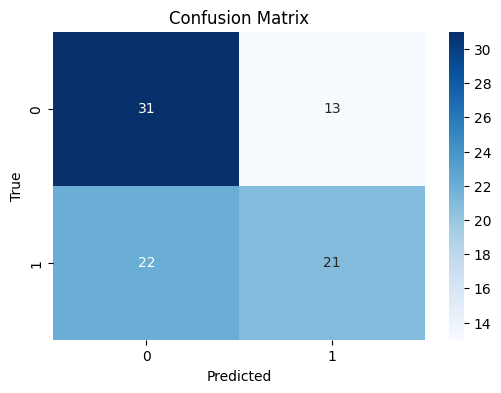

Accuracy (proporcion de aciertos) 0.5977
Precision (proporcion de verdaderos positivos entre todos los positivos) 0.6176
Recall (proporcion de verdaderos positivos) 0.4884
Especificidad (proporcion de verdaderos negativos) 0.7045


In [ ]:
# A FIRST EXAMPLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.25, stratify=y, random_state=1)


logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
logreg.fit(xtrain, ytrain)


# Create the confusion matrix from true values and predictions on test dataset
predictions = logreg.predict(xtest)
cm = confusion_matrix(ytest, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Define the values of the confusion matrix
TN = cm[0,0]
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]


print("Accuracy (proporcion de aciertos)", round((TP+TN)/(TP+TN+FN+FP),4))
print("Precision (proporcion de verdaderos positivos entre todos los positivos)", round((TP)/(TP+FP),4))
print("Recall (proporcion de verdaderos positivos)", round((TP)/(TP+FN),4))
print("Especificidad (proporcion de verdaderos negativos)", round((TN)/(TN+FP),4))


0.5666805199999999
0.053237921226599365


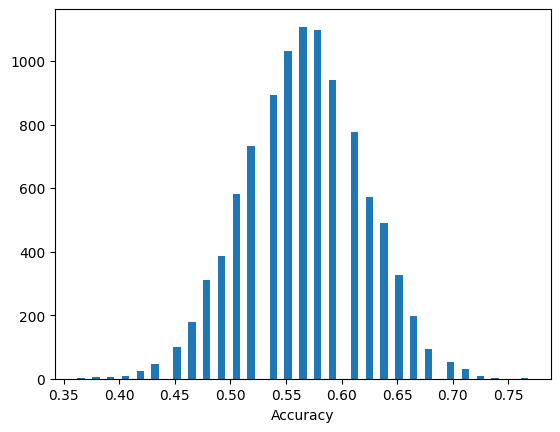

In [ ]:
LogReg2C(X,y,10000)

BAD: ACCURACY OF $ 0.57 \pm 0.05$

#### DECISION TREE CLASSIFIER

In [ ]:
X.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  SRS  DAYS_SINCE_SRS      WBRT  \
0    0.001327           0.002996     0.000636  0.0             0.0  0.000000   
1    0.001751           0.002961     0.001462  0.0             0.0  0.003922   
2    0.000332           0.002536     0.006291  0.0             0.0  0.000000   
4    0.000519           0.002526     0.012293  0.0             0.0  0.003922   
6    0.001444           0.002754     0.001409  0.0             0.0  0.000000   

   DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS       TS1  TS1_DAYS       GPA  \
0         0.000000               0.450980  0.003922  0.407843  0.003922   
1         0.400000               0.427451  0.000000  0.000000  0.003922   
2         0.000000               0.427451  0.000000  0.000000  0.003922   
4         0.827451               0.294118  0.000000  0.000000  0.003922   
6         0.000000               0.266667  0.007843  0.176471  0.007843   

        SEX       AGE  
0  0.003922  0.156863  
1  0.003922  0.156863  
2  0.003922  0.156863  
4  0.003922  0.156863  
6  0.003922  0.172549

1
0.5677731092436974
-------
2
0.577718487394958
-------
3
0.5973151260504201
-------
4
0.5822941176470587
-------
5
0.568172268907563
-------


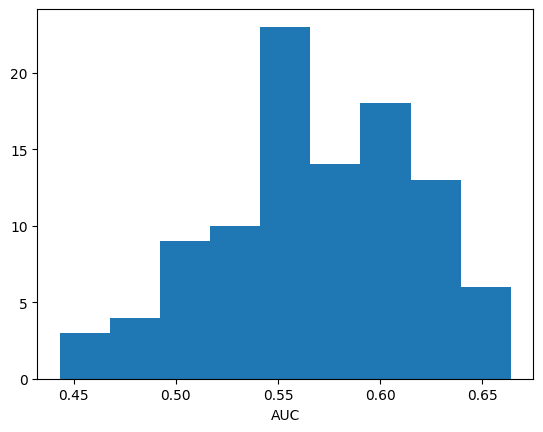

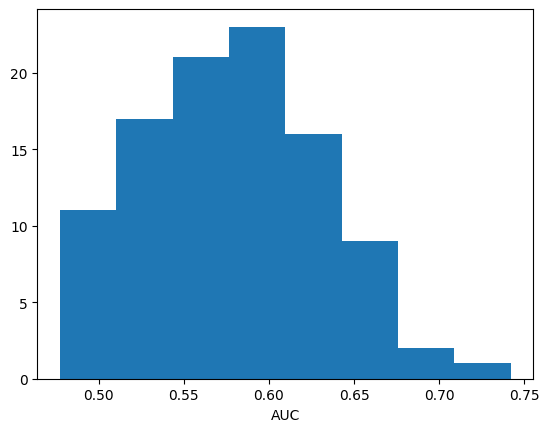

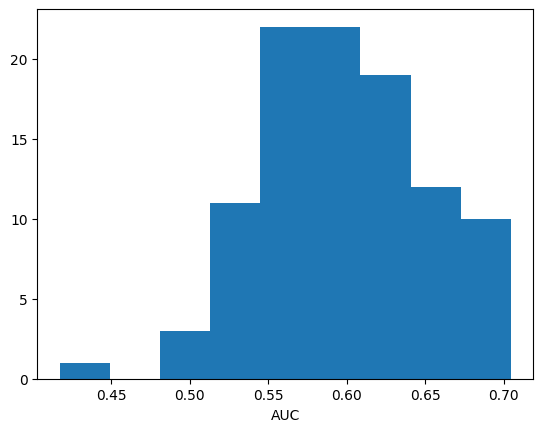

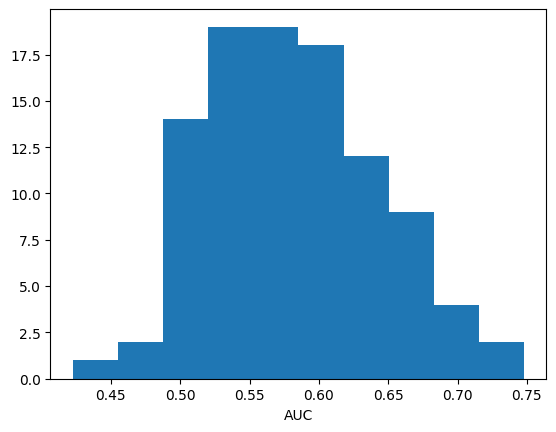

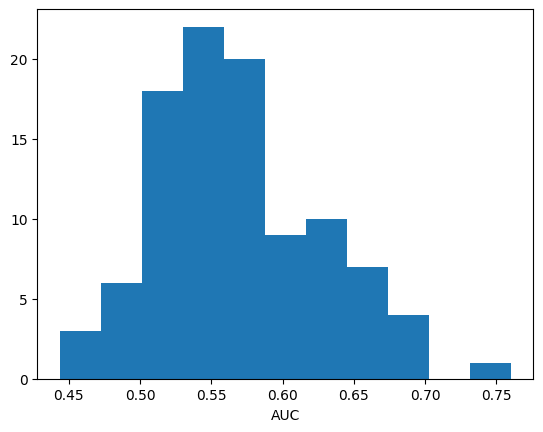

In [ ]:
# NOW WE WANT TO FIND THE OPTIMUM DEPTH OF THE TREE
# THIS WILL TAKE SOME TIME, YOU CAN GO MAKE YOURSELF A SANDWICH (OR REDUCE THE NUMBER OF SEEDS)
for i in range(1,6):
  aucs = DecisionTreeClass(X,y,0.2,100,i)
  print(i)
  print(np.mean(aucs))
  print('-------')
  plt.figure()
  plt.hist(aucs,bins='auto')
  plt.xlabel('AUC')

ACCURACY:
0.5786463768115943
0.05429507089780361
-----
AUC:
0.5884421008403362
0.0631777145640302


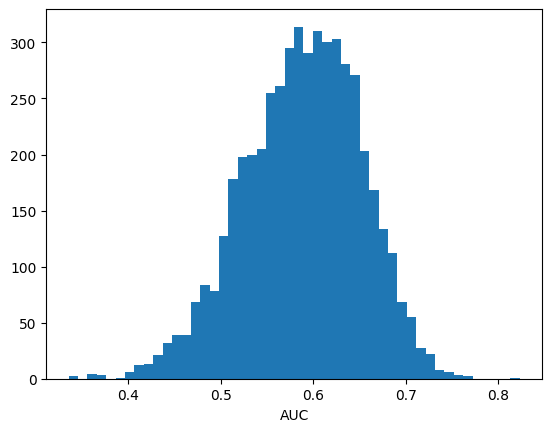

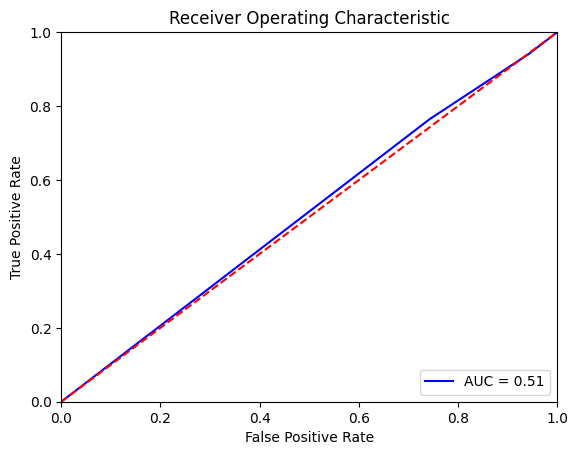

In [ ]:
#THE BEST RESULT CORRESPONDS TO MAX_DEPTH = 3
DecisionTreeClass2(X,y,0.2,5000,3)

A LITTLE BETTER $0.58 \pm 0.05 $ BUT STILL BAD

####RANDOM FOREST

In [ ]:
Random_Tree_2C2(X, y)

0.5657942028985506

Text(0.5, 1.0, 'MEAN ACCURACY')

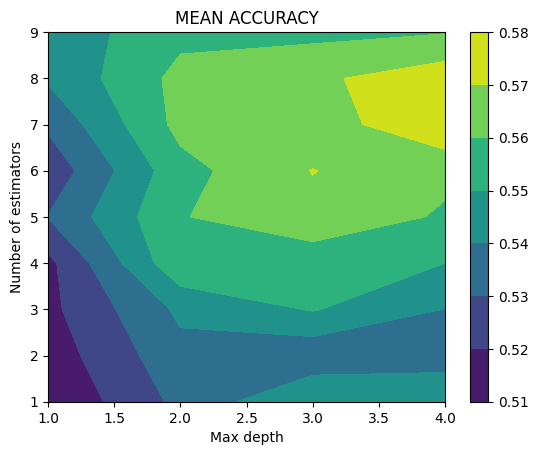

In [ ]:
#NOW LET'S OPTIMIZE THE PARAMETERS OF RANDOM FOREST

mne = 10
mmd = 5
nr0 = 20
matriz = Optimize_RT(X,y,test_size = 0.2, max_ne = mne,max_md = mmd, nr=nr0)
plt.contourf(range(1,mmd),range(1,mne),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')

0.5555942028985507
0.05912102795308775


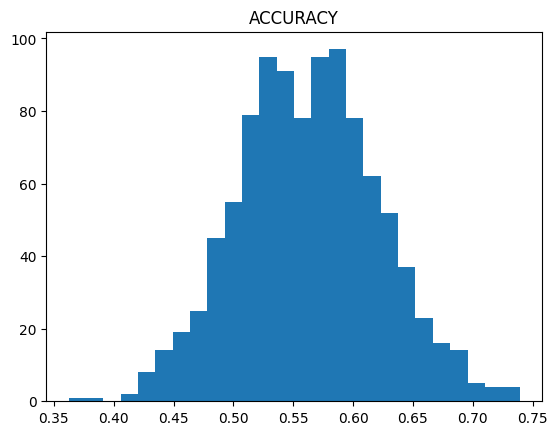

In [ ]:
# SO LET'S TRY AGAIN
Random_Tree_2C(X, y,test_size=0.2,ne = 5,md = 8, nr = 1000)

SIMILAR RESULTS

#### XGB

In [ ]:
# A FIRST TRY
train_errors = {}
test_errors = {}
val_errors = {}
# Split train-test


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Model training
xgb_model = xgb.XGBClassifier(n_estimators=500, eval_metric= 'auc', seed= 123, booster= 'gbtree', eta= 0.2, gamma= 0, max_depth=3, scale_pos_weight=2,  objective="binary:logistic")

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=20,
              verbose=True)

# Train estimations
preds_xgb_train = xgb_model.predict(X_train)
probs_xgb_train = xgb_model.predict_proba(X_train)
probs_xgb_train = [x[1] for x in probs_xgb_train]

accuracy_xgb_train = accuracy_score(y_train, preds_xgb_train)
precision_xgb_train = precision_score(y_train, preds_xgb_train)
recall_xgb_train = recall_score(y_train, preds_xgb_train)
f1_xgb_train = f1_score(y_train, preds_xgb_train)
auc_xgb_train = roc_auc_score(y_train, probs_xgb_train)

# Test estimations
preds_xgb_test = xgb_model.predict(X_test)
probs_xgb_test = xgb_model.predict_proba(X_test)
probs_xgb_test = [x[1] for x in probs_xgb_test]

accuracy_xgb_test = accuracy_score(y_test, preds_xgb_test)
precision_xgb_test = precision_score(y_test, preds_xgb_test)
recall_xgb_test = recall_score(y_test, preds_xgb_test)
f1_xgb_test = f1_score(y_test, preds_xgb_test)
auc_xgb_test = roc_auc_score(y_test, probs_xgb_test)


aux_error_train = {'accuracy': accuracy_xgb_train, 'precision': precision_xgb_train, 'recall': recall_xgb_train, 'f1': f1_xgb_train, 'auc': auc_xgb_train}
aux_error_test = {'accuracy': accuracy_xgb_test, 'precision': precision_xgb_test, 'recall': recall_xgb_test, 'f1': f1_xgb_test, 'auc': auc_xgb_test}

train_errors['xgb'] = aux_error_train
test_errors['xgb'] = aux_error_test

[0]	validation_0-auc:0.69795	validation_1-auc:0.57647
[1]	validation_0-auc:0.73602	validation_1-auc:0.61429
[2]	validation_0-auc:0.77569	validation_1-auc:0.64286
[3]	validation_0-auc:0.78423	validation_1-auc:0.63529
[4]	validation_0-auc:0.79019	validation_1-auc:0.64622
[5]	validation_0-auc:0.80203	validation_1-auc:0.65672
[6]	validation_0-auc:0.80959	validation_1-auc:0.64244
[7]	validation_0-auc:0.82133	validation_1-auc:0.64664
[8]	validation_0-auc:0.83416	validation_1-auc:0.66008
[9]	validation_0-auc:0.83666	validation_1-auc:0.65000
[10]	validation_0-auc:0.84910	validation_1-auc:0.65504
[11]	validation_0-auc:0.87901	validation_1-auc:0.60210
[12]	validation_0-auc:0.88557	validation_1-auc:0.61218
[13]	validation_0-auc:0.89017	validation_1-auc:0.62227
[14]	validation_0-auc:0.89626	validation_1-auc:0.60546
[15]	validation_0-auc:0.90424	validation_1-auc:0.59706
[16]	validation_0-auc:0.90514	validation_1-auc:0.59958
[17]	validation_0-auc:0.90527	validation_1-auc:0.60126
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


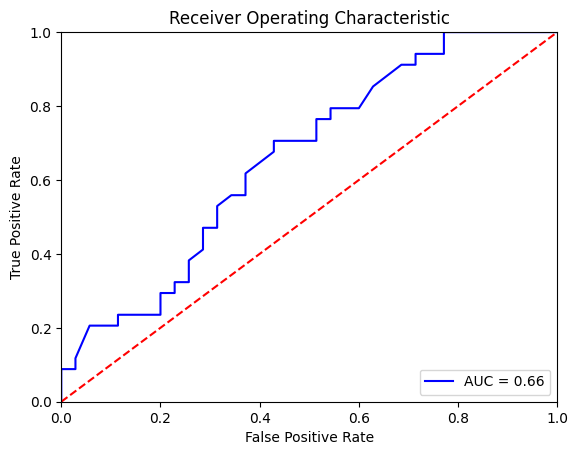

In [ ]:
xgb_fpr_test, xgb_tpr_test, xgb_threshold_test = roc_curve(y_test, probs_xgb_test)
xgb_roc_auc_test = auc(xgb_fpr_test, xgb_tpr_test)

plt.title('Receiver Operating Characteristic')
plt.plot(xgb_fpr_test, xgb_tpr_test, 'b', label = 'AUC = %0.2f' % xgb_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
accs,aucs = XGB_2C(X,y,ts = 0.2,ne = 10, md = 5, nr = 5000)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with s

0.5246695652173913
0.04088630338711101


Text(0.5, 0, 'ACCURACY')

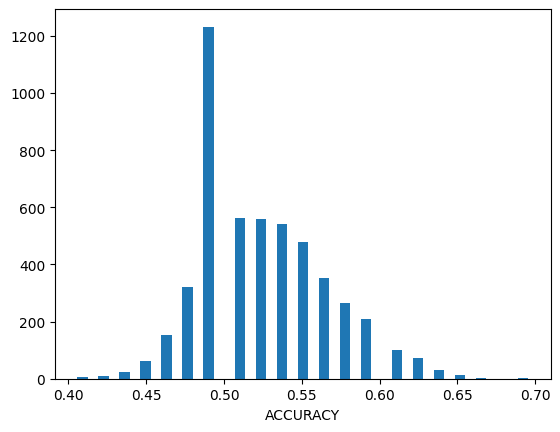

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')
plt.xlabel('ACCURACY')

0.6135640336134454
0.05722333533643718


Text(0.5, 0, 'AUC')

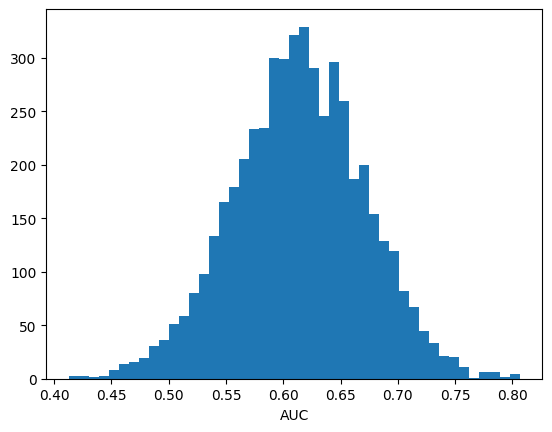

In [ ]:
print(np.mean(aucs))
print(np.sqrt(np.var(aucs)))
plt.hist(aucs,bins='auto')
plt.xlabel('AUC')

In [ ]:
#NOT A VERY GOOD RESULT

mne = 10
mmd = 10
nr0 = 10
matriz_acc, matriz_auc = Optimize_XGB(X,y,test_size=0.2,max_ne=mne,max_md = mmd, nr = nr0)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

Text(0.5, 1.0, 'MEAN ACCURACY')

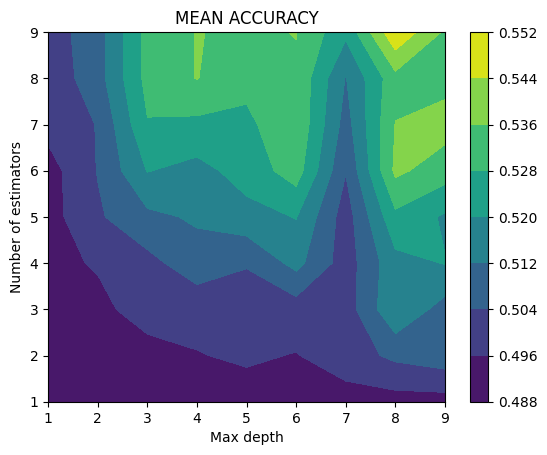

In [ ]:
plt.contourf(range(1,mmd),range(1,mne),matriz_acc)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')

Text(0.5, 1.0, 'MEAN AUC')

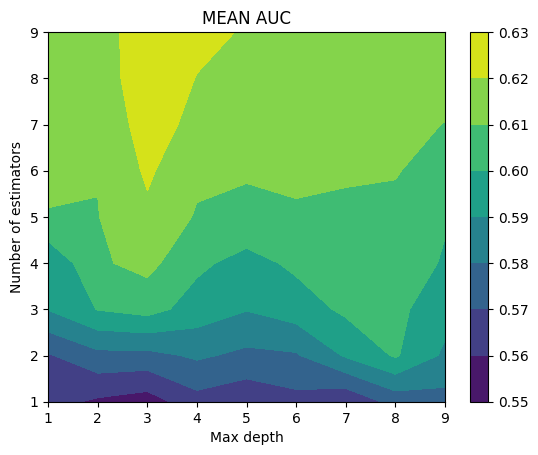

In [ ]:
plt.contourf(range(1,mmd),range(1,mne),matriz_auc)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN AUC')

SAME, MAX ACCURACY OF 0.55

#### NN

In [ ]:
X.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  SRS  DAYS_SINCE_SRS      WBRT  \
0    0.001327           0.002996     0.000636  0.0             0.0  0.000000   
1    0.001751           0.002961     0.001462  0.0             0.0  0.003922   
2    0.000332           0.002536     0.006291  0.0             0.0  0.000000   
4    0.000519           0.002526     0.012293  0.0             0.0  0.003922   
6    0.001444           0.002754     0.001409  0.0             0.0  0.000000   

   DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS       TS1  TS1_DAYS       GPA  \
0         0.000000               0.450980  0.003922  0.407843  0.003922   
1         0.400000               0.427451  0.000000  0.000000  0.003922   
2         0.000000               0.427451  0.000000  0.000000  0.003922   
4         0.827451               0.294118  0.000000  0.000000  0.003922   
6         0.000000               0.266667  0.007843  0.176471  0.007843   

        SEX       AGE  
0  0.003922  0.156863  
1  0.003922  0.156863  
2  0.003922  0.156863  
4  0.003922  0.156863  
6  0.003922  0.172549

Epoch 1/3
4/4 [==============================] - 1s 64ms/step - loss: 0.6933 - accuracy: 0.4637 - val_loss: 0.6935 - val_accuracy: 0.4643
Epoch 2/3
4/4 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.5242 - val_loss: 0.6932 - val_accuracy: 0.4643
Epoch 3/3
3/3 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5362
Test Accuracy: 0.5362318754196167
3/3 [==============================] - 0s 2ms/step


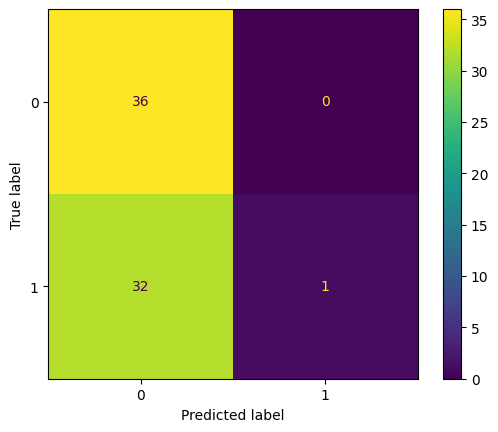

In [ ]:
# Normalize the data if needed
X = X / 255.0 if X.max().max() > 1 else X



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

# Check the shape of your input data
input_shape = X_train.shape[1]

# Build the model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Output the accuracy
print(f'Test Accuracy: {test_accuracy}')


y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

In [ ]:
accs = NN_2C(X,y,test_size=0.2,nr = 100,epochs=5)

Epoch 1/5
4/4 [==============================] - 1s 63ms/step - loss: 0.6933 - accuracy: 0.5081 - val_loss: 0.6927 - val_accuracy: 0.5357
Epoch 2/5
4/4 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5081 - val_loss: 0.6929 - val_accuracy: 0.5357
Epoch 3/5
4/4 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.5081 - val_loss: 0.6928 - val_accuracy: 0.5357
Epoch 4/5
4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 0.6928 - val_accuracy: 0.5357
Epoch 5/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4783
Epoch 1/5
4/4 [==============================] - 1s 62ms/step - loss: 0.6932 - accuracy: 0.4718 - val_loss: 0.6931 - val_accuracy: 0.5357
Epoch 2/5
4/4 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.4677 - val_loss: 0.6929 - val_accuracy: 0.5357
Epoch 3/5
4/4 [==============================] - 0s 12ms/step - loss: 0.6932 

0.47043478161096575
0.04167366015518167


(array([ 8., 19., 11., 31., 16.,  6.,  8.,  0.,  1.]),
 array([0.39130434, 0.41545893, 0.43961352, 0.4637681 , 0.48792269,
        0.51207728, 0.53623187, 0.56038645, 0.58454104, 0.60869563]),
 <BarContainer object of 9 artists>)

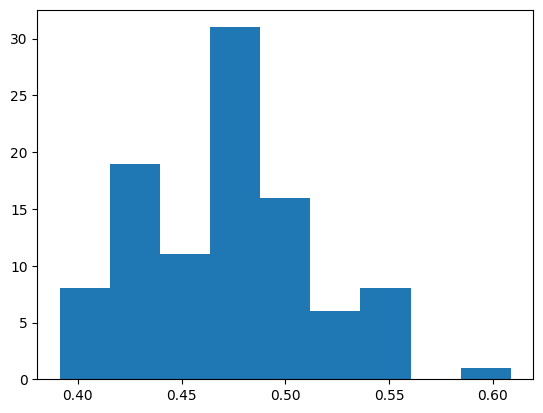

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

ACTUALLY WORSE. SHOULD HAVE TRIED WITH 3 EPOCHS AND 500/1000 SEEDS

### MULTICLASS: RELAPSE OR NOT, OR IMPROVEMENT

In [ ]:
df_Relapse2 = df_Relapse.copy()
df_Relapse2['CRECIMIENTO_VOLUMEN'] = 100 * (df_Relapse2['FUTURE_TOTALVOLUME'] - df_Relapse2['TOTALVOLUME']) / df_Relapse2['TOTALVOLUME']

In [ ]:
df_Relapse2.head(1)

PATIENT  LESION  TIME POINT  CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  \
0    10005       1    19010618    0.338262           0.763884     0.162125   

   SRS  DAYS_SINCE_SRS  WBRT  DAYS_SINCE_WBRT  FUTURE_TOTALVOLUME  \
0  0.0             0.0   0.0              0.0            0.372887   

   TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  CRECIMIENTO_VOLUMEN  
0                  115.0  1.0     104.0                130.0

In [ ]:
for index, row in df_Relapse2.iterrows():
    patient = row['PATIENT']
    rows_for_this_patient = df_CD2.loc[df_CD2['ID'] == patient]
    # select the rows for this patient in CC so we can extract his patient data
    row_for_this_patient = rows_for_this_patient.iloc[0]

    df_Relapse2.loc[index, 'GPA'] = row_for_this_patient['GPA']
    df_Relapse2.loc[index, 'SEX'] = row_for_this_patient['SEX']
    df_Relapse2.loc[index, 'AGE'] = row_for_this_patient['AGE']

df_Relapse2 = df_Relapse2.fillna(media_gpa)

In [ ]:
X = df_Relapse2.drop(['PATIENT','LESION','TIME POINT','FUTURE_TOTALVOLUME','CRECIMIENTO_VOLUMEN'],axis=1)
X.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  SRS  DAYS_SINCE_SRS  WBRT  \
0    0.338262           0.763884     0.162125  0.0             0.0   0.0   
1    0.446508           0.755049     0.372887  0.0             0.0   1.0   
2    0.084779           0.646738     1.604080  0.0             0.0   0.0   
4    0.132334           0.644168     3.134727  0.0             0.0   1.0   
6    0.368203           0.702189     0.359200  0.0             0.0   0.0   

   DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  GPA  SEX   AGE  
0              0.0                  115.0  1.0     104.0  1.0  1.0  40.0  
1            102.0                  109.0  0.0       0.0  1.0  1.0  40.0  
2              0.0                  109.0  0.0       0.0  1.0  1.0  40.0  
4            211.0                   75.0  0.0       0.0  1.0  1.0  40.0  
6              0.0                   68.0  2.0      45.0  2.0  1.0  44.0

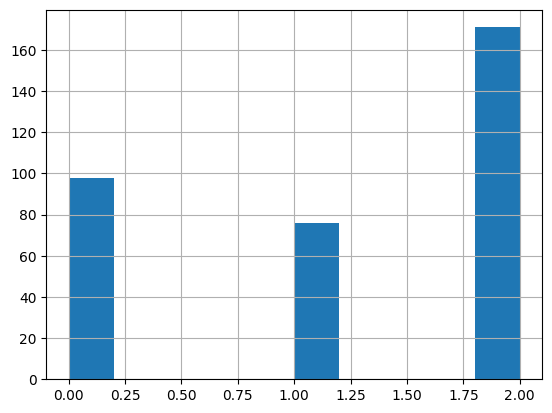

In [ ]:
y = df_Relapse2['CRECIMIENTO_VOLUMEN']


yy =[]

for i in y:
  if i<0:
    yy.append(0)
  elif i>=0 and i<30:
    yy.append(1)
  elif i>30:
    yy.append(2)
y = pd.DataFrame(yy)[0]
plt.hist(y,bins='auto')
plt.grid()

####LOGISTIC REGRESSION

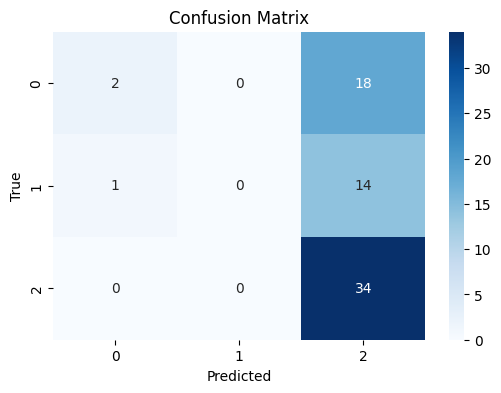

THE ACCURACY IS 0.5217391304347826


In [ ]:
# A FIRST EXAMPLE

xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.20, stratify=y, random_state=1)


logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
logreg.fit(xtrain, ytrain)


# Create the confusion matrix from true values and predictions on test dataset
predictions = logreg.predict(xtest)
cm = confusion_matrix(ytest, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('THE ACCURACY IS '+str(accuracy_score(ytest,predictions)))

0.4617217391304348
0.03726882129820827


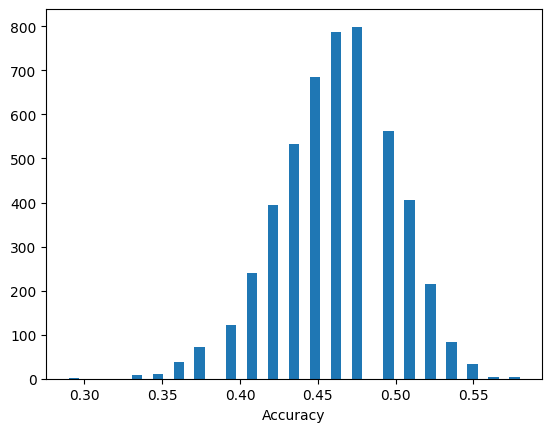

In [ ]:
#ACCURACY FOR MANY SEEDS

LogRegMC(X,y,5000)

FOR 10'000 SEEDS: ACCURACY OF $0.48 \pm 0.04 $ (0.33 IS COMPLETELY RANDOM)

#### DECISION TREE CLASSIFIER

Accuracy: 0.49
Confusion Matrix: 
 [[ 2  3 15]
 [ 1  2 12]
 [ 1  3 30]]
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        20
           1       0.25      0.13      0.17        15
           2       0.53      0.88      0.66        34

    accuracy                           0.49        69
   macro avg       0.43      0.37      0.33        69
weighted avg       0.46      0.49      0.41        69



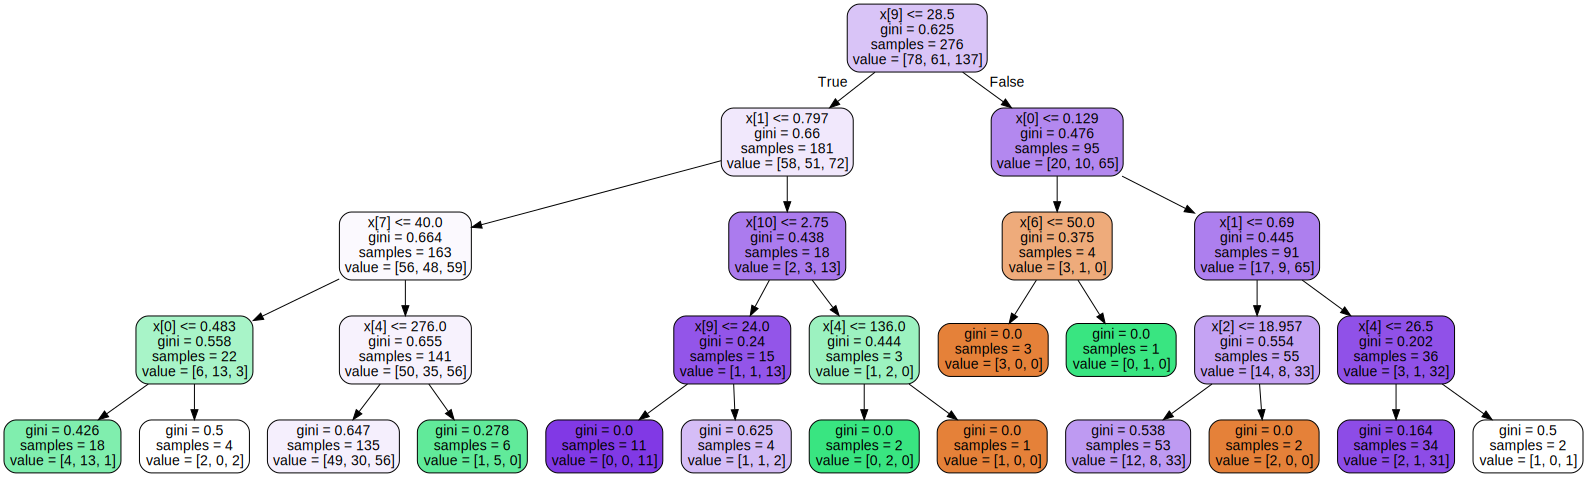

In [ ]:
#AN EXAMPLE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

classifier = DecisionTreeClassifier(max_depth=4, random_state=42)
classifier.fit(X_train, y_train)

y_pred_test =classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_test,y_pred_test)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred_test))

# Visualize the tree by graphiz
feature_names = ['SEX','AGE', 'GPA', 'NLESIONS', 'TYPE']
class_names = ['LESS THAN 500D','500-1500D','>1500D']
dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True)
graph = graphviz.Source(dot_data)
graph

2
-----------
0.4772753623188407
0.026830686504267377
-----------
3
-----------
0.463304347826087
0.040145126353298304
-----------
4
-----------
0.44927536231884063
0.046336032796385464
-----------
5
-----------
0.4471159420289856
0.051072922319414106
-----------
6
-----------
0.440840579710145
0.05092976329956829
-----------
7
-----------
0.436072463768116
0.053961095540843815
-----------


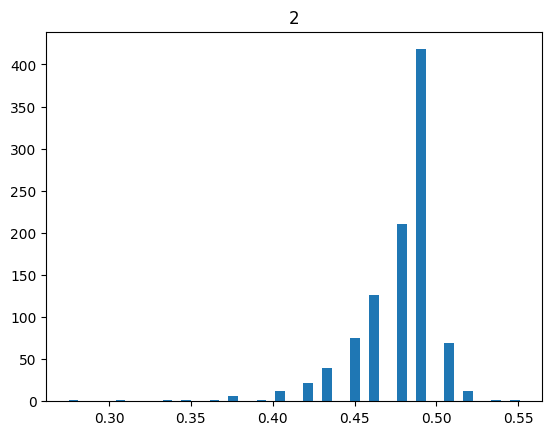

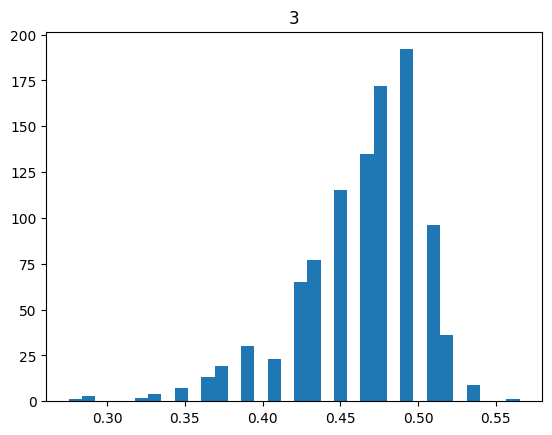

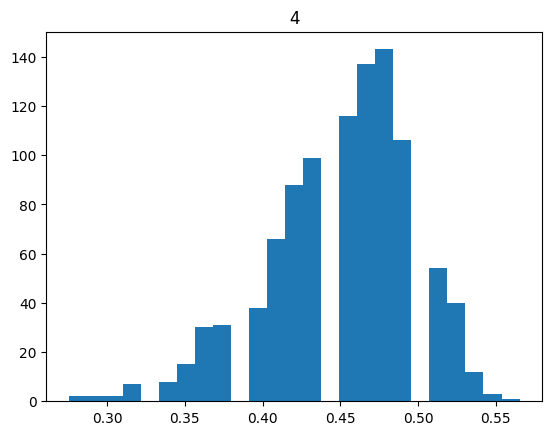

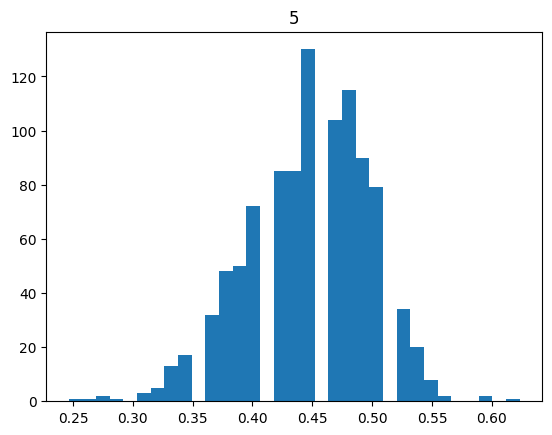

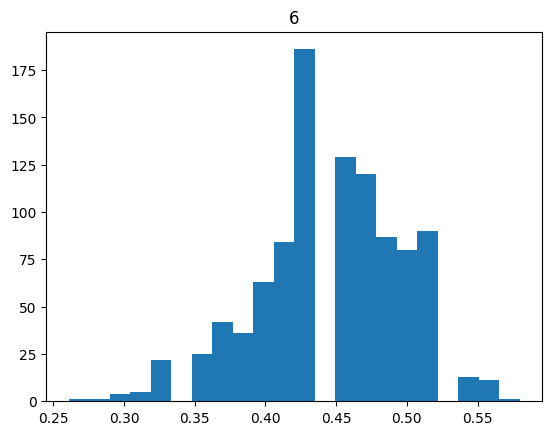

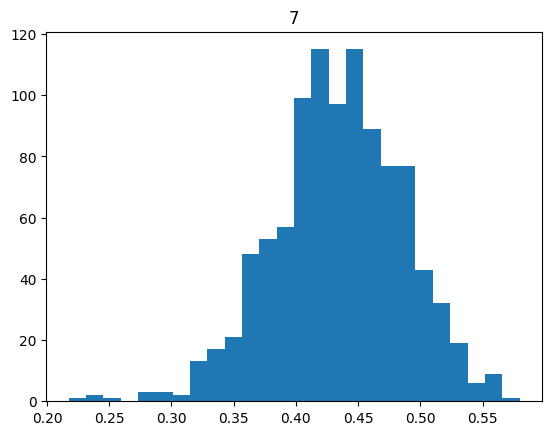

In [ ]:
#OPTIMIZE DEPTH TREE

for j in range(2,8):
  acc = []
  for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

    classifier = DecisionTreeClassifier(max_depth=j, random_state=i)
    classifier.fit(X_train, y_train)

    y_pred_test =classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    cm=confusion_matrix(y_test,y_pred_test)
    acc.append(accuracy)

  print(j)
  print('-----------')
  print(np.mean(acc))
  print(np.sqrt(np.var(acc)))
  print('-----------')
  plt.figure()
  plt.title(j)
  plt.hist(acc,bins='auto')

THE BEST WE CAN EXPECT IS AROUND 0.47

#### RANDOM FOREST

0.4775942028985508


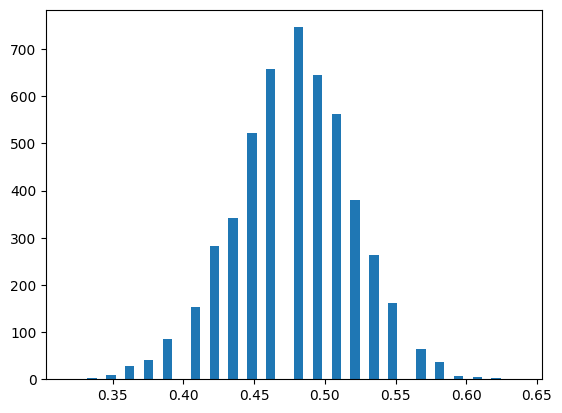

In [ ]:
Random_Tree_MC(X,y)

Text(0.5, 1.0, 'MEAN ACCURACY')

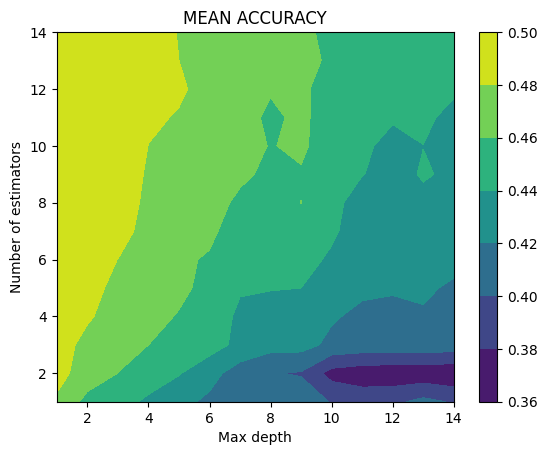

In [ ]:
mne = 15
mmd = 15
nr0 = 100
matriz = Optimize_RTMC(X,y,test_size = 0.2, max_ne = mne,max_md = mmd, nr=nr0)
plt.contourf(range(1,mmd),range(1,mne),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')

MAX ACCURACY OF 0.5

#### XGB

In [ ]:
# A FIRST TRY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

# Supongamos que ya tienes los conjuntos de datos divididos
# X_train, X_test, y_train, y_test

# Crear el DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configuración de los parámetros del modelo
param = {
    'objective': 'multi:softmax',  # Objetivo de clasificación multiclase
    'num_class': len(set(y_train)),  # Número de clases
    'eval_metric': 'mlogloss',  # Métrica de evaluación
    'max_depth': 6,  # Profundidad máxima de los árboles
    'eta': 0.3,  # Tasa de aprendizaje
    'seed': 42  # Semilla para reproducibilidad
}

# Número de rondas de boosting
num_round = 200

# Entrenar el modelo
bst = xgb.train(param, dtrain, num_round)

# Predecir en el conjunto de prueba
y_pred = bst.predict(dtest)

# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Mostrar un reporte de clasificación
print(classification_report(y_test, y_pred))

Accuracy: 0.4348
              precision    recall  f1-score   support

           0       0.38      0.40      0.39        20
           1       0.09      0.07      0.08        15
           2       0.57      0.62      0.59        34

    accuracy                           0.43        69
   macro avg       0.35      0.36      0.35        69
weighted avg       0.41      0.43      0.42        69



In [ ]:
accs = XGB_MC(X,y)

0.46443478260869575
0.054739427809777294


(array([  3.,   9.,   0.,  12.,  20.,  36.,  36.,  53., 176.,   0., 100.,
        102., 102.,  98.,  69.,  64.,  49.,  49.,   0.,   7.,   9.,   4.,
          1.,   0.,   1.]),
 array([0.30434783, 0.31884058, 0.33333333, 0.34782609, 0.36231884,
        0.37681159, 0.39130435, 0.4057971 , 0.42028986, 0.43478261,
        0.44927536, 0.46376812, 0.47826087, 0.49275362, 0.50724638,
        0.52173913, 0.53623188, 0.55072464, 0.56521739, 0.57971014,
        0.5942029 , 0.60869565, 0.62318841, 0.63768116, 0.65217391,
        0.66666667]),
 <BarContainer object of 25 artists>)

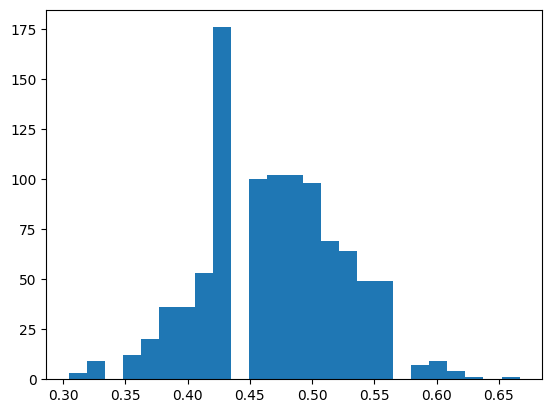

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

In [ ]:
mmd = 5
mnr = 10
nr0 = 20

matriz = Optimize_XGB_MC(X,y,test_size = 0.2, max_md = mmd, max_nround = mnr, nr = nr0)

Text(0.5, 1.0, 'MEAN ACCURACY')

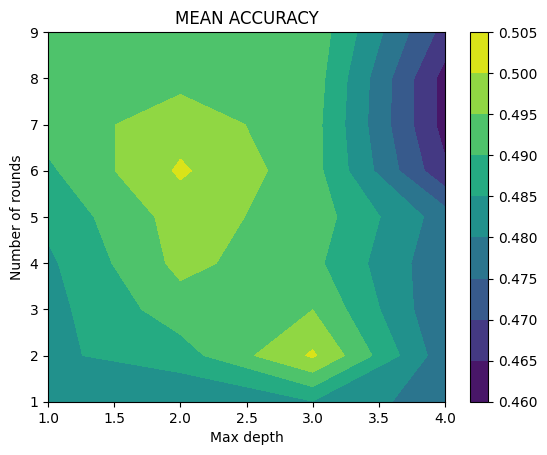

In [ ]:
plt.contourf(range(1,mmd),range(1,mnr),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of rounds')
plt.title('MEAN ACCURACY')

MAX ACCURACY OF 0.5

#### NN

In [ ]:
 # Normalize the data if needed
X = X / 255.0 if X.max().max() > 1 else X


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

# Check the shape of your input data
input_shape = X_train.shape[1]

# Determine the number of classes
num_classes = len(np.unique(y))

# Build the model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # For multiclass classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/3
4/4 [==============================] - 1s 64ms/step - loss: 1.0633 - accuracy: 0.4879 - val_loss: 1.0251 - val_accuracy: 0.5357
Epoch 2/3
4/4 [==============================] - 0s 13ms/step - loss: 1.0493 - accuracy: 0.4960 - val_loss: 1.0052 - val_accuracy: 0.5357
Epoch 3/3
3/3 [==============================] - 0s 4ms/step - loss: 1.0408 - accuracy: 0.4783
Test Accuracy: 0.47826087474823


In [ ]:
accs = NN_MC(X,y,test_size=0.2,nr = 500,epochs = 3)

Epoch 1/3
4/4 [==============================] - 1s 63ms/step - loss: 1.0969 - accuracy: 0.4315 - val_loss: 1.0937 - val_accuracy: 0.4643
Epoch 2/3
4/4 [==============================] - 0s 12ms/step - loss: 1.0912 - accuracy: 0.4919 - val_loss: 1.0897 - val_accuracy: 0.4643
Epoch 3/3
3/3 [==============================] - 0s 3ms/step - loss: 1.0787 - accuracy: 0.5217
Epoch 1/3
4/4 [==============================] - 1s 63ms/step - loss: 1.0971 - accuracy: 0.4194 - val_loss: 1.0938 - val_accuracy: 0.5357
Epoch 2/3
4/4 [==============================] - 0s 12ms/step - loss: 1.0929 - accuracy: 0.5040 - val_loss: 1.0887 - val_accuracy: 0.5357
Epoch 3/3
3/3 [==============================] - 0s 3ms/step - loss: 1.0894 - accuracy: 0.4493
Epoch 1/3
4/4 [==============================] - 1s 65ms/step - loss: 1.0966 - accuracy: 0.4597 - val_loss: 1.0871 - val_accuracy: 0.6071
Epoch 2/3
4/4 [==============================] - 0s 12ms/step - loss: 1.0912 - accuracy: 0.4597 - val_loss: 1.0753 - val

0.49695651870965957
0.05257873838031793


Text(0.5, 0, 'ACCURACY')

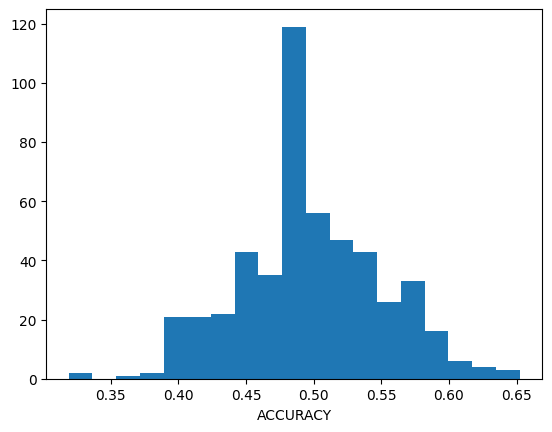

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')
plt.xlabel('ACCURACY')

SAME RESULTS, AROUND 0.5

## CONSIDERING ONLY PATIENTS TREATED WITH SRS

### BINARY: RELAPSE OR NOT

In [ ]:
df_Relapse.head()

PATIENT  LESION  TIME POINT  CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  \
0    10005       1    19010618    0.338262           0.763884     0.162125   
1    10005       1    19011011    0.446508           0.755049     0.372887   
2    10005       3    19011011    0.084779           0.646738     1.604080   
4    10005       3    19020128    0.132334           0.644168     3.134727   
6    10020       1    19010822    0.368203           0.702189     0.359200   

   SRS  DAYS_SINCE_SRS  WBRT  DAYS_SINCE_WBRT  FUTURE_TOTALVOLUME  \
0  0.0             0.0   0.0              0.0            0.372887   
1  0.0             0.0   1.0            102.0            2.336502   
2  0.0             0.0   0.0              0.0            3.134727   
4  0.0             0.0   1.0            211.0            3.225327   
6  0.0             0.0   0.0              0.0            0.677434   

   TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  
0                  115.0  1.0     104.0  
1                  109.0  0.0       0.0  
2                  109.0  0.0       0.0  
4                   75.0  0.0       0.0  
6                   68.0  2.0      45.0

In [ ]:
df_Relapse3 = df_Relapse.copy()
df_Relapse3['CRECIMIENTO_VOLUMEN'] = 100 * (df_Relapse3['FUTURE_TOTALVOLUME'] - df_Relapse3['TOTALVOLUME']) / df_Relapse3['TOTALVOLUME']
df_Relapse3['RECAIDA'] = df_Relapse3['CRECIMIENTO_VOLUMEN'] > 30 # si el tumo crece más de un 30% entre un análisis y el siguiente, hay recaida



In [ ]:
df_Relapse3.head()

PATIENT  LESION  TIME POINT  CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  \
0    10005       1    19010618    0.338262           0.763884     0.162125   
1    10005       1    19011011    0.446508           0.755049     0.372887   
2    10005       3    19011011    0.084779           0.646738     1.604080   
4    10005       3    19020128    0.132334           0.644168     3.134727   
6    10020       1    19010822    0.368203           0.702189     0.359200   

   SRS  DAYS_SINCE_SRS  WBRT  DAYS_SINCE_WBRT  FUTURE_TOTALVOLUME  \
0  0.0             0.0   0.0              0.0            0.372887   
1  0.0             0.0   1.0            102.0            2.336502   
2  0.0             0.0   0.0              0.0            3.134727   
4  0.0             0.0   1.0            211.0            3.225327   
6  0.0             0.0   0.0              0.0            0.677434   

   TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  CRECIMIENTO_VOLUMEN  RECAIDA  
0                  115.0  1.0     104.0           130.000000     True  
1                  109.0  0.0       0.0           526.598465     True  
2                  109.0  0.0       0.0            95.422117     True  
4                   75.0  0.0       0.0             2.890173    False  
6                   68.0  2.0      45.0            88.595506     True

In [ ]:
# after generating RECAIDA, we drop CRECIMIENTO_VOLUMEN and FUTURE_TOTALVOLUME
df_Relapse3 = df_Relapse3.drop('FUTURE_TOTALVOLUME', axis='columns')
df_Relapse3 = df_Relapse3.drop('CRECIMIENTO_VOLUMEN', axis='columns')


for index, row in df_Relapse3.iterrows():
    patient = row['PATIENT']
    rows_for_this_patient = df_CD2.loc[df_CD2['ID'] == patient]
    # select the rows for this patient in CC so we can extract his patient data
    row_for_this_patient = rows_for_this_patient.iloc[0]

    df_Relapse3.loc[index, 'GPA'] = row_for_this_patient['GPA']
    df_Relapse3.loc[index, 'SEX'] = row_for_this_patient['SEX']
    df_Relapse3.loc[index, 'AGE'] = row_for_this_patient['AGE']

df_Relapse3 = df_Relapse3.drop('PATIENT', axis=1)
df_Relapse3 = df_Relapse3.drop('LESION', axis=1)
df_Relapse3 = df_Relapse3.drop('TIME POINT', axis=1)

df_Relapse3 = df_Relapse3[df_Relapse3['SRS']!=0]
df_Relapse3 = df_Relapse3.drop('SRS',axis=1)

df_Relapse3 = df_Relapse3.fillna(media_gpa)
df_Relapse3.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  DAYS_SINCE_SRS  WBRT  \
34     0.904911           0.596867    11.407531            37.0   1.0   
58     0.592862           0.494146     6.080795             8.0   1.0   
62     0.769549           0.489527     8.034930            53.0   1.0   
63     0.803346           0.519313    17.315839            50.0   1.0   
116    0.280601           0.583214     2.223163            31.0   0.0   

     DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  RECAIDA  GPA  SEX  \
34             659.0                   69.0  0.0       0.0     True  1.0  2.0   
58             189.0                   45.0  7.0      45.0     True  1.0  2.0   
62             234.0                   72.0  7.0      72.0     True  1.0  2.0   
63             234.0                   72.0  7.0      72.0    False  1.0  2.0   
116              0.0                   61.0  9.0      61.0    False  2.0  1.0   

      AGE  
34   67.0  
58   64.0  
62   64.0  
63   64.0  
116  61.0

In [ ]:
df_Relapse3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 34 to 495
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CERIMWIDTH             105 non-null    float64
 1   SURFACEREGULARITY      105 non-null    float64
 2   TOTALVOLUME            105 non-null    float64
 3   DAYS_SINCE_SRS         105 non-null    float64
 4   WBRT                   105 non-null    float64
 5   DAYS_SINCE_WBRT        105 non-null    float64
 6   TIME_TO_NEXT_ANALYSIS  105 non-null    float64
 7   TS1                    105 non-null    float64
 8   TS1_DAYS               105 non-null    float64
 9   RECAIDA                105 non-null    bool   
 10  GPA                    105 non-null    float64
 11  SEX                    105 non-null    float64
 12  AGE                    105 non-null    float64
dtypes: bool(1), float64(12)
memory usage: 10.8 KB


In [ ]:
y = df_Relapse3['RECAIDA']
X = df_Relapse3.drop(['RECAIDA'], axis=1)
X = X / 255.0 if X.max().max() > 1 else X

In [ ]:
X.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  DAYS_SINCE_SRS      WBRT  \
34     0.003549           0.002341     0.044735        0.145098  0.003922   
58     0.002325           0.001938     0.023846        0.031373  0.003922   
62     0.003018           0.001920     0.031510        0.207843  0.003922   
63     0.003150           0.002037     0.067905        0.196078  0.003922   
116    0.001100           0.002287     0.008718        0.121569  0.000000   

     DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS       TS1  TS1_DAYS       GPA  \
34          2.584314               0.270588  0.000000  0.000000  0.003922   
58          0.741176               0.176471  0.027451  0.176471  0.003922   
62          0.917647               0.282353  0.027451  0.282353  0.003922   
63          0.917647               0.282353  0.027451  0.282353  0.003922   
116         0.000000               0.239216  0.035294  0.239216  0.007843   

          SEX       AGE  
34   0.007843  0.262745  
58   0.007843  0.250980  
62   0.007843  0.250980  
63   0.007843  0.250980  
116  0.003922  0.239216

#### LOGISTIC REGRESSION

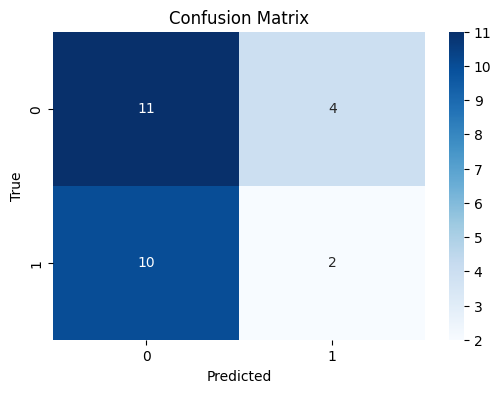

Accuracy (proporcion de aciertos) 0.4815
Precision (proporcion de verdaderos positivos entre todos los positivos) 0.3333
Recall (proporcion de verdaderos positivos) 0.1667
Especificidad (proporcion de verdaderos negativos) 0.7333


In [ ]:
# A FIRST EXAMPLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.25, stratify=y, random_state=1)


logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
logreg.fit(xtrain, ytrain)


# Create the confusion matrix from true values and predictions on test dataset
predictions = logreg.predict(xtest)
cm = confusion_matrix(ytest, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Define the values of the confusion matrix
TN = cm[0,0]
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]


print("Accuracy (proporcion de aciertos)", round((TP+TN)/(TP+TN+FN+FP),4))
print("Precision (proporcion de verdaderos positivos entre todos los positivos)", round((TP)/(TP+FP),4))
print("Recall (proporcion de verdaderos positivos)", round((TP)/(TP+FN),4))
print("Especificidad (proporcion de verdaderos negativos)", round((TN)/(TN+FP),4))

0.5967675399999999
0.08363519527297344


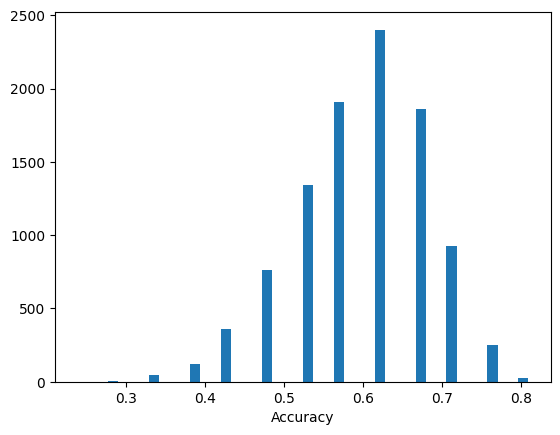

In [ ]:
LogReg2C(X,y,10000)

AN ACCURACY OF $ 0.6 \pm 0.1 $.  BETTER THAN WITH THE WHOLE DATASET

#### DECISION TREE CLASSIFIER

In [ ]:
# THIS DOES NOT WORK WELL
# WE WANT TO FIND THE OPTIMUM DEPTH OF THE TREE
# THIS WILL TAKE SOME TIME, YOU CAN GO MAKE YOURSELF A SANDWICH (OR REDUCE THE NUMBER OF SEEDS)
'''
for i in range(1,6):
  aucs = DecisionTreeClass(X,y,0.2,100,i)
  print(i)
  print(np.mean(aucs))
  print('-------')
  plt.figure()
  plt.hist(aucs,bins='auto')
  plt.xlabel('AUC')

'''

"\nfor i in range(1,6):\n  aucs = DecisionTreeClass(X,y,0.2,100,i)\n  print(i)\n  print(np.mean(aucs))\n  print('-------')\n  plt.figure()\n  plt.hist(aucs,bins='auto')\n  plt.xlabel('AUC')\n\n"

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

ACCURACY:
0.5242666666666667
0.09095995779958617
-----
AUC:
0.5177
0.09686304262237017


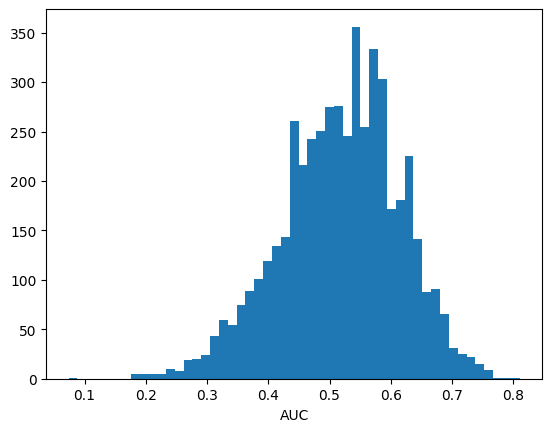

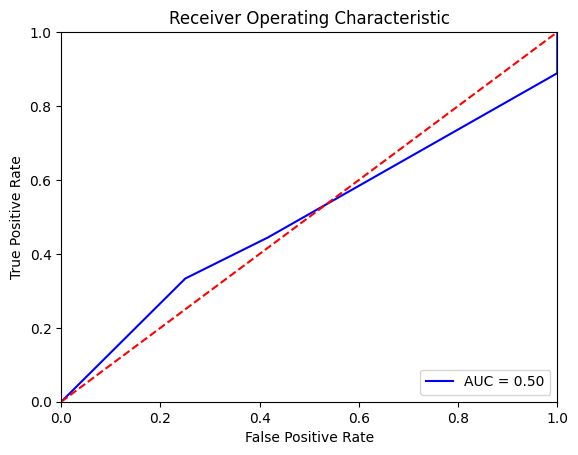

In [ ]:
DecisionTreeClass2(X,y,0.2,5000,3)

#### RANDOM FOREST

0.5735333333333333
0.0991236699790387


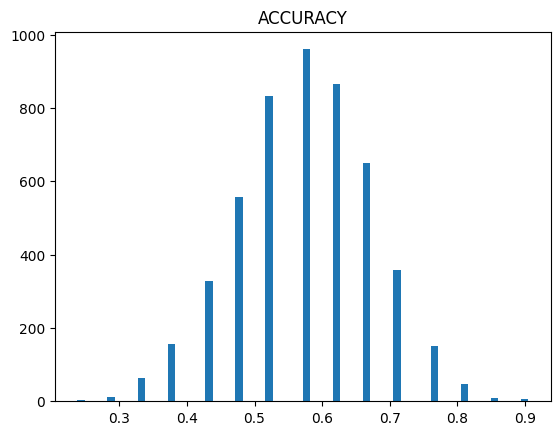

In [ ]:
Random_Tree_2C(X, y)

ACCURACY OF $0.574 \pm 0.099 $. OPTIMIZATION IS NOT GOING TO HELP MUCH

#### XGB

In [ ]:
# A FIRST TRY
train_errors = {}
test_errors = {}
val_errors = {}
# Split train-test


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Model training
xgb_model = xgb.XGBClassifier(n_estimators=500, eval_metric= 'auc', seed= 123, booster= 'gbtree', eta= 0.2, gamma= 0, max_depth=3, scale_pos_weight=2,  objective="binary:logistic")

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=20,
              verbose=True)

# Train estimations
preds_xgb_train = xgb_model.predict(X_train)
probs_xgb_train = xgb_model.predict_proba(X_train)
probs_xgb_train = [x[1] for x in probs_xgb_train]

accuracy_xgb_train = accuracy_score(y_train, preds_xgb_train)
precision_xgb_train = precision_score(y_train, preds_xgb_train)
recall_xgb_train = recall_score(y_train, preds_xgb_train)
f1_xgb_train = f1_score(y_train, preds_xgb_train)
auc_xgb_train = roc_auc_score(y_train, probs_xgb_train)

# Test estimations
preds_xgb_test = xgb_model.predict(X_test)
probs_xgb_test = xgb_model.predict_proba(X_test)
probs_xgb_test = [x[1] for x in probs_xgb_test]

accuracy_xgb_test = accuracy_score(y_test, preds_xgb_test)
precision_xgb_test = precision_score(y_test, preds_xgb_test)
recall_xgb_test = recall_score(y_test, preds_xgb_test)
f1_xgb_test = f1_score(y_test, preds_xgb_test)
auc_xgb_test = roc_auc_score(y_test, probs_xgb_test)


aux_error_train = {'accuracy': accuracy_xgb_train, 'precision': precision_xgb_train, 'recall': recall_xgb_train, 'f1': f1_xgb_train, 'auc': auc_xgb_train}
aux_error_test = {'accuracy': accuracy_xgb_test, 'precision': precision_xgb_test, 'recall': recall_xgb_test, 'f1': f1_xgb_test, 'auc': auc_xgb_test}

train_errors['xgb'] = aux_error_train
test_errors['xgb'] = aux_error_test

[0]	validation_0-auc:0.72743	validation_1-auc:0.51852
[1]	validation_0-auc:0.86630	validation_1-auc:0.58333
[2]	validation_0-auc:0.87780	validation_1-auc:0.51852
[3]	validation_0-auc:0.91288	validation_1-auc:0.45833
[4]	validation_0-auc:0.92639	validation_1-auc:0.53241


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.92524	validation_1-auc:0.52315
[6]	validation_0-auc:0.93042	validation_1-auc:0.52315
[7]	validation_0-auc:0.94365	validation_1-auc:0.52778
[8]	validation_0-auc:0.94911	validation_1-auc:0.55093
[9]	validation_0-auc:0.94767	validation_1-auc:0.56944
[10]	validation_0-auc:0.96233	validation_1-auc:0.60185
[11]	validation_0-auc:0.97412	validation_1-auc:0.57407
[12]	validation_0-auc:0.97757	validation_1-auc:0.58333
[13]	validation_0-auc:0.98016	validation_1-auc:0.58333
[14]	validation_0-auc:0.98189	validation_1-auc:0.62037
[15]	validation_0-auc:0.98074	validation_1-auc:0.61111
[16]	validation_0-auc:0.98361	validation_1-auc:0.62963
[17]	validation_0-auc:0.98246	validation_1-auc:0.61111
[18]	validation_0-auc:0.98419	validation_1-auc:0.61111
[19]	validation_0-auc:0.98246	validation_1-auc:0.62037
[20]	validation_0-auc:0.98620	validation_1-auc:0.63889
[21]	validation_0-auc:0.98792	validation_1-auc:0.65741
[22]	validation_0-auc:0.98792	validation_1-auc:0.65741
[23]	validation

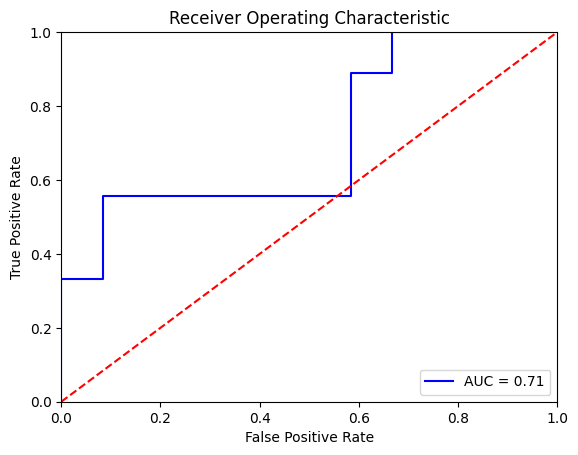

In [ ]:
xgb_fpr_test, xgb_tpr_test, xgb_threshold_test = roc_curve(y_test, probs_xgb_test)
xgb_roc_auc_test = auc(xgb_fpr_test, xgb_tpr_test)

plt.title('Receiver Operating Characteristic')
plt.plot(xgb_fpr_test, xgb_tpr_test, 'b', label = 'AUC = %0.2f' % xgb_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
accs,aucs = XGB_2C(X,y,ts = 0.2,ne = 10, md = 5, nr = 1000)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

0.5085238095238095
0.09377397199185523


Text(0.5, 0, 'ACCURACY')

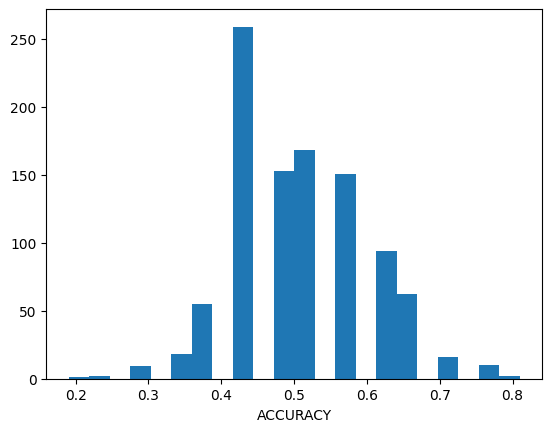

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')
plt.xlabel('ACCURACY')

0.607638888888889
0.11435724046382921


Text(0.5, 0, 'AUC')

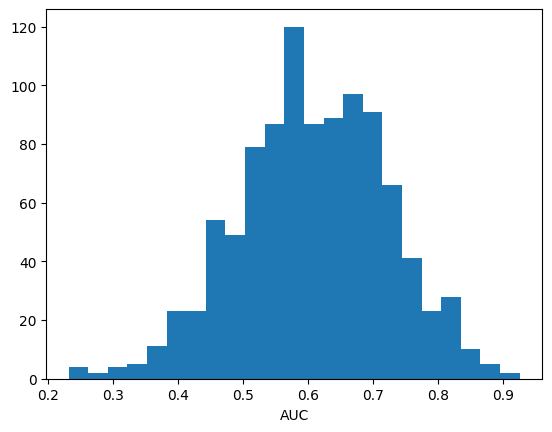

In [ ]:
print(np.mean(aucs))
print(np.sqrt(np.var(aucs)))
plt.hist(aucs,bins='auto')
plt.xlabel('AUC')

In [ ]:
mne = 10
mmd = 10
nr0 = 100
matriz_acc, matriz_auc = Optimize_XGB(X,y,test_size=0.2,max_ne=mne,max_md = mmd, nr = nr0)


Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with s

Text(0.5, 1.0, 'MEAN ACCURACY')

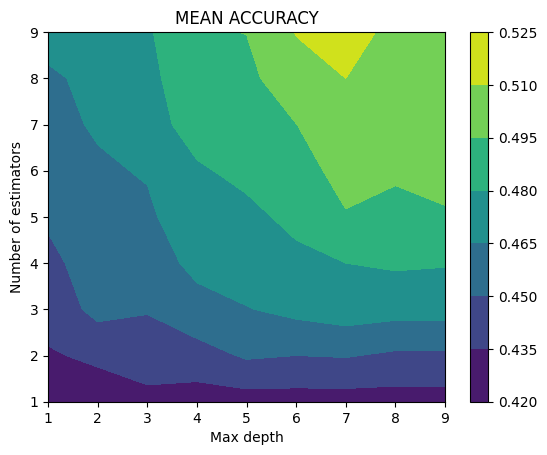

In [ ]:
plt.contourf(range(1,mmd),range(1,mne),matriz_acc)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')

Text(0.5, 1.0, 'MEAN AUC')

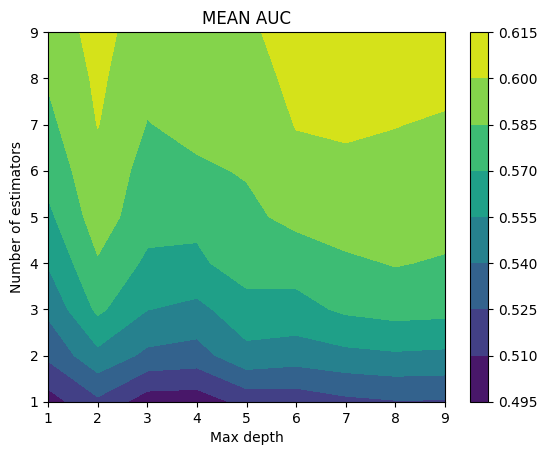

In [ ]:
plt.contourf(range(1,mmd),range(1,mne),matriz_auc)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN AUC')

NOT GOOD, MAX ACCURACY OF 0.53

#### NN

In [ ]:
X.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  DAYS_SINCE_SRS      WBRT  \
34     0.003549           0.002341     0.044735        0.145098  0.003922   
58     0.002325           0.001938     0.023846        0.031373  0.003922   
62     0.003018           0.001920     0.031510        0.207843  0.003922   
63     0.003150           0.002037     0.067905        0.196078  0.003922   
116    0.001100           0.002287     0.008718        0.121569  0.000000   

     DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS       TS1  TS1_DAYS       GPA  \
34          2.584314               0.270588  0.000000  0.000000  0.003922   
58          0.741176               0.176471  0.027451  0.176471  0.003922   
62          0.917647               0.282353  0.027451  0.282353  0.003922   
63          0.917647               0.282353  0.027451  0.282353  0.003922   
116         0.000000               0.239216  0.035294  0.239216  0.007843   

          SEX       AGE  
34   0.007843  0.262745  
58   0.007843  0.250980  
62   0.007843  0.250980  
63   0.007843  0.250980  
116  0.003922  0.239216

Epoch 1/3
2/2 [==============================] - 1s 181ms/step - loss: 0.6931 - accuracy: 0.4933 - val_loss: 0.6926 - val_accuracy: 0.5556
Epoch 2/3
2/2 [==============================] - 0s 33ms/step - loss: 0.6922 - accuracy: 0.5733 - val_loss: 0.6920 - val_accuracy: 0.5556
Epoch 3/3
1/1 [==============================] - 0s 26ms/step - loss: 0.6925 - accuracy: 0.5238
Test Accuracy: 0.523809552192688
1/1 [==============================] - 0s 58ms/step


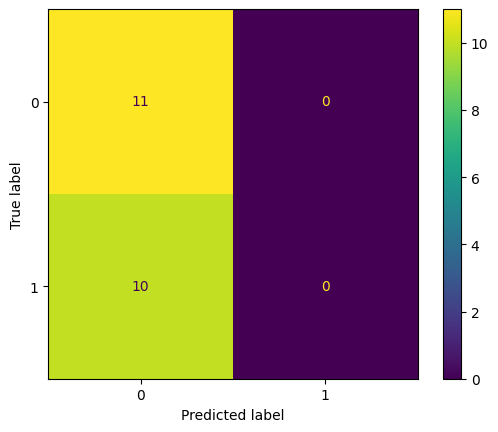

In [ ]:
# Normalize the data if needed
X = X / 255.0 if X.max().max() > 1 else X



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

# Check the shape of your input data
input_shape = X_train.shape[1]

# Build the model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Output the accuracy
print(f'Test Accuracy: {test_accuracy}')


y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

In [ ]:
accs = NN_2C(X,y,test_size=0.2,nr = 100,epochs=5)

Epoch 1/5
2/2 [==============================] - 1s 184ms/step - loss: 0.6933 - accuracy: 0.3600 - val_loss: 0.6932 - val_accuracy: 0.4444
Epoch 2/5
2/2 [==============================] - 0s 32ms/step - loss: 0.6929 - accuracy: 0.6267 - val_loss: 0.6932 - val_accuracy: 0.4444
Epoch 3/5
2/2 [==============================] - 0s 32ms/step - loss: 0.6929 - accuracy: 0.6400 - val_loss: 0.6933 - val_accuracy: 0.4444
Epoch 4/5
2/2 [==============================] - 0s 32ms/step - loss: 0.6927 - accuracy: 0.6000 - val_loss: 0.6935 - val_accuracy: 0.4444
Epoch 5/5
1/1 [==============================] - 0s 35ms/step - loss: 0.6928 - accuracy: 0.5238
Epoch 1/5
2/2 [==============================] - 1s 184ms/step - loss: 0.6930 - accuracy: 0.5600 - val_loss: 0.6912 - val_accuracy: 0.6667
Epoch 2/5
2/2 [==============================] - 0s 32ms/step - loss: 0.6924 - accuracy: 0.5733 - val_loss: 0.6898 - val_accuracy: 0.6667
Epoch 3/5
2/2 [==============================] - 0s 31ms/step - loss: 0.69

0.5352381128072738
0.09526666775128988


(array([ 9., 10., 15., 23., 16., 14.,  8.,  5.]),
 array([0.33333334, 0.38690477, 0.4404762 , 0.49404763, 0.54761906,
        0.60119049, 0.65476192, 0.70833335, 0.76190478]),
 <BarContainer object of 8 artists>)

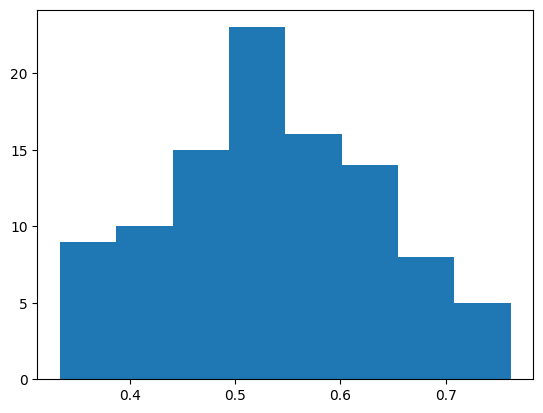

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

STILL BAD RESULTS

### MULTICLASS: RELAPSE OR NOT, OR IMPROVEMENT

In [ ]:
df_Relapse4 = df_Relapse.copy()
df_Relapse4['CRECIMIENTO_VOLUMEN'] = 100 * (df_Relapse4['FUTURE_TOTALVOLUME'] - df_Relapse4['TOTALVOLUME']) / df_Relapse4['TOTALVOLUME']

In [ ]:
for index, row in df_Relapse4.iterrows():
    patient = row['PATIENT']
    rows_for_this_patient = df_CD2.loc[df_CD2['ID'] == patient]
    # select the rows for this patient in CC so we can extract his patient data
    row_for_this_patient = rows_for_this_patient.iloc[0]

    df_Relapse4.loc[index, 'GPA'] = row_for_this_patient['GPA']
    df_Relapse4.loc[index, 'SEX'] = row_for_this_patient['SEX']
    df_Relapse4.loc[index, 'AGE'] = row_for_this_patient['AGE']

df_Relapse4 = df_Relapse4.fillna(media_gpa)

In [ ]:
df_Relapse4 = df_Relapse4[df_Relapse4['SRS']!=0]
df_Relapse4 = df_Relapse4.drop('SRS',axis=1)

In [ ]:
X = df_Relapse4.drop(['PATIENT','LESION','TIME POINT','FUTURE_TOTALVOLUME','CRECIMIENTO_VOLUMEN'],axis=1)
X.head()

CERIMWIDTH  SURFACEREGULARITY  TOTALVOLUME  DAYS_SINCE_SRS  WBRT  \
34     0.904911           0.596867    11.407531            37.0   1.0   
58     0.592862           0.494146     6.080795             8.0   1.0   
62     0.769549           0.489527     8.034930            53.0   1.0   
63     0.803346           0.519313    17.315839            50.0   1.0   
116    0.280601           0.583214     2.223163            31.0   0.0   

     DAYS_SINCE_WBRT  TIME_TO_NEXT_ANALYSIS  TS1  TS1_DAYS  GPA  SEX   AGE  
34             659.0                   69.0  0.0       0.0  1.0  2.0  67.0  
58             189.0                   45.0  7.0      45.0  1.0  2.0  64.0  
62             234.0                   72.0  7.0      72.0  1.0  2.0  64.0  
63             234.0                   72.0  7.0      72.0  1.0  2.0  64.0  
116              0.0                   61.0  9.0      61.0  2.0  1.0  61.0

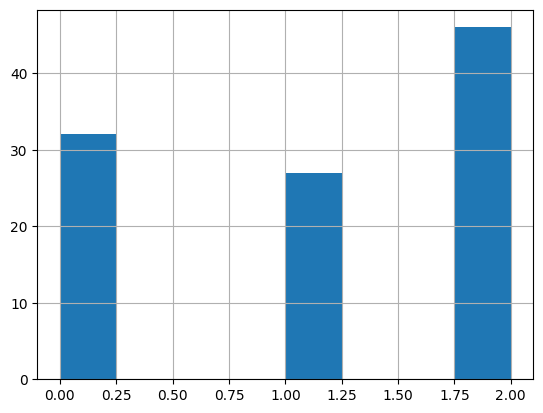

In [ ]:
y = df_Relapse4['CRECIMIENTO_VOLUMEN']


yy =[]

for i in y:
  if i<0:
    yy.append(0)
  elif i>=0 and i<30:
    yy.append(1)
  elif i>30:
    yy.append(2)
y = pd.DataFrame(yy)[0]
plt.hist(y,bins='auto')
plt.grid()

####LOGISTIC REGRESSION

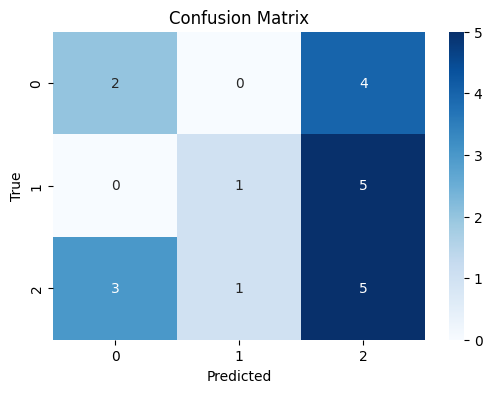

THE ACCURACY IS 0.38095238095238093


In [ ]:
# A FIRST EXAMPLE

xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.20, stratify=y, random_state=1)


logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
logreg.fit(xtrain, ytrain)


# Create the confusion matrix from true values and predictions on test dataset
predictions = logreg.predict(xtest)
cm = confusion_matrix(ytest, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('THE ACCURACY IS '+str(accuracy_score(ytest,predictions)))

0.3960666666666666
0.0873268580452453


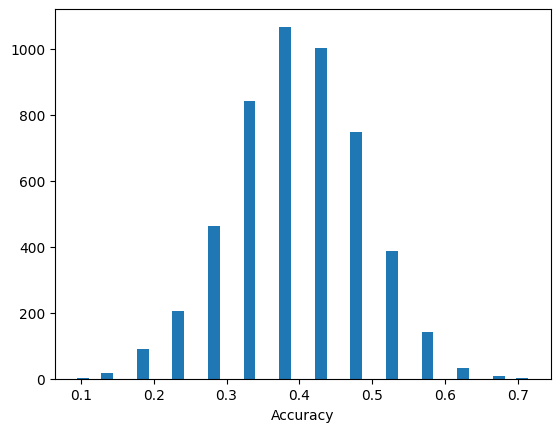

In [ ]:
LogRegMC(X,y,5000)

ACCURACY AROUND 0.4

#### DECISION TREE CLASSIFIER

Accuracy: 0.43
Confusion Matrix: 
 [[0 1 5]
 [0 4 2]
 [1 3 5]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.67      0.57         6
           2       0.42      0.56      0.48         9

    accuracy                           0.43        21
   macro avg       0.31      0.41      0.35        21
weighted avg       0.32      0.43      0.37        21



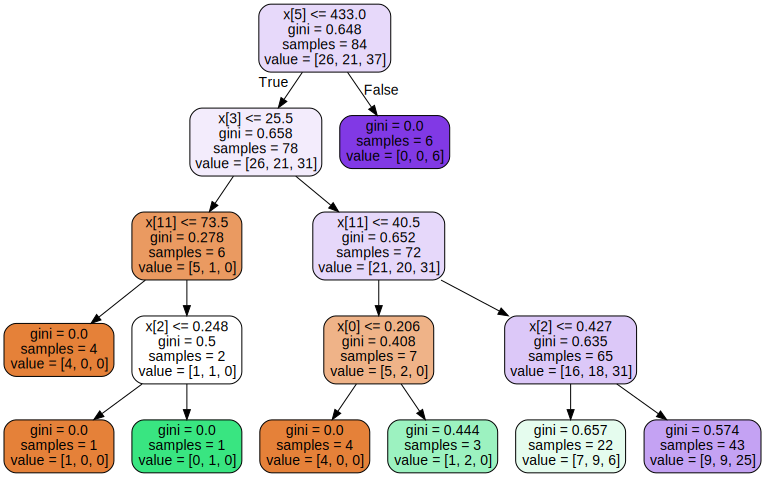

In [ ]:
#AN EXAMPLE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

classifier = DecisionTreeClassifier(max_depth=4, random_state=42)
classifier.fit(X_train, y_train)

y_pred_test =classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_test,y_pred_test)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred_test))

# Visualize the tree by graphiz
feature_names = ['SEX','AGE', 'GPA', 'NLESIONS', 'TYPE']
class_names = ['LESS THAN 500D','500-1500D','>1500D']
dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True)
graph = graphviz.Source(dot_data)
graph

2
-----------
0.38123809523809526
0.08534263342178444
-----------
3
-----------
0.3721428571428571
0.0848204051734419
-----------
4
-----------
0.35919047619047617
0.09020197794614498
-----------
5
-----------
0.3615238095238095
0.09328395195107236
-----------
6
-----------
0.3589047619047619
0.09000668909382598
-----------
7
-----------
0.36861904761904757
0.09304521856824616
-----------


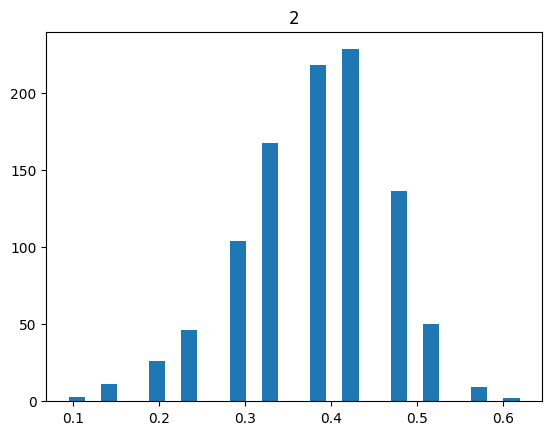

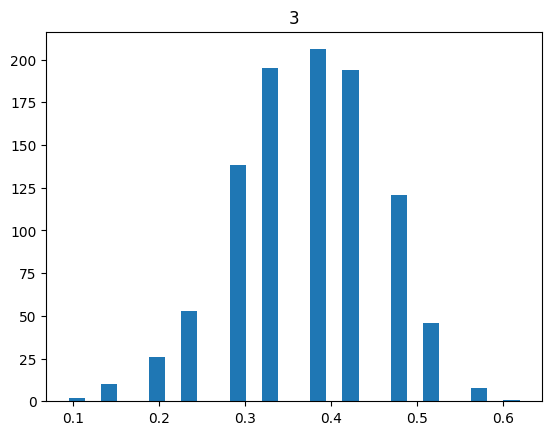

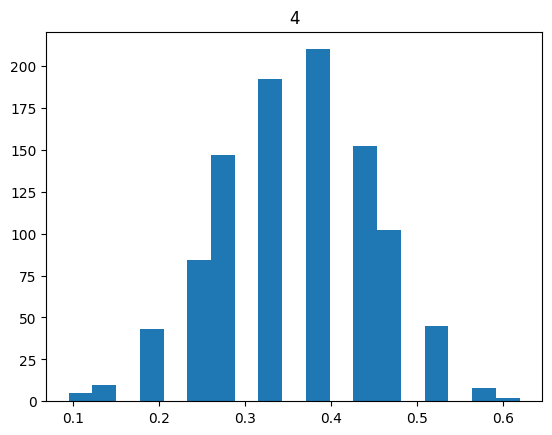

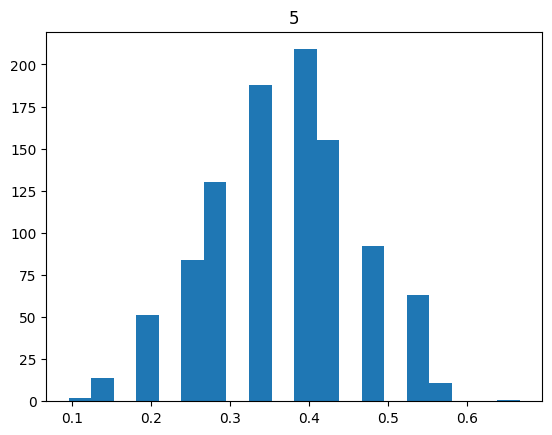

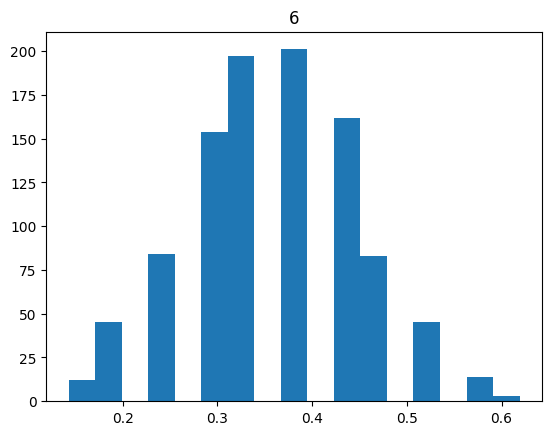

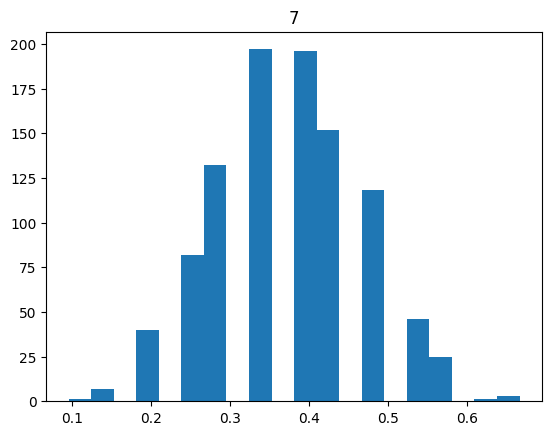

In [ ]:
#OPTIMIZE DEPTH TREE

for j in range(2,8):
  acc = []
  for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

    classifier = DecisionTreeClassifier(max_depth=j, random_state=i)
    classifier.fit(X_train, y_train)

    y_pred_test =classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    cm=confusion_matrix(y_test,y_pred_test)
    acc.append(accuracy)

  print(j)
  print('-----------')
  print(np.mean(acc))
  print(np.sqrt(np.var(acc)))
  print('-----------')
  plt.figure()
  plt.title(j)
  plt.hist(acc,bins='auto')

0.38119047619047614
0.08405323961601414


(array([  9.,   0.,   0.,  31.,   0.,   0.,   0.,  64.,   0.,   0., 159.,
          0.,   0.,   0., 307.,   0.,   0.,   0., 471.,   0.,   0., 710.,
          0.,   0.,   0., 662.,   0.,   0.,   0., 406.,   0.,   0., 158.,
          0.,   0.,   0.,  21.,   0.,   0.,   2.]),
 array([0.0952381 , 0.10833333, 0.12142857, 0.13452381, 0.14761905,
        0.16071429, 0.17380952, 0.18690476, 0.2       , 0.21309524,
        0.22619048, 0.23928571, 0.25238095, 0.26547619, 0.27857143,
        0.29166667, 0.3047619 , 0.31785714, 0.33095238, 0.34404762,
        0.35714286, 0.3702381 , 0.38333333, 0.39642857, 0.40952381,
        0.42261905, 0.43571429, 0.44880952, 0.46190476, 0.475     ,
        0.48809524, 0.50119048, 0.51428571, 0.52738095, 0.54047619,
        0.55357143, 0.56666667, 0.5797619 , 0.59285714, 0.60595238,
        0.61904762]),
 <BarContainer object of 40 artists>)

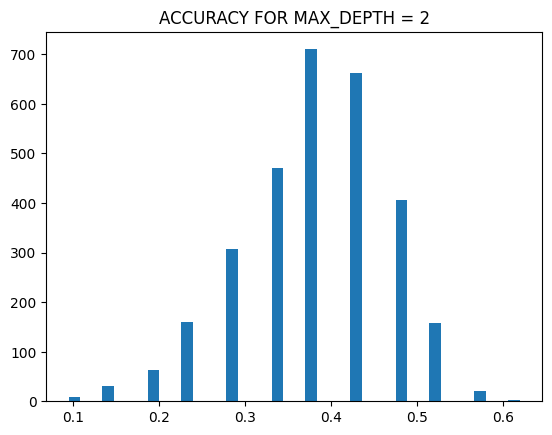

In [ ]:
acc = []
for i in range(3000):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

  classifier = DecisionTreeClassifier(max_depth=2, random_state=i)
  classifier.fit(X_train, y_train)

  y_pred_test =classifier.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred_test)
  cm=confusion_matrix(y_test,y_pred_test)
  acc.append(accuracy)

print(np.mean(acc))
print(np.sqrt(np.var(acc)))
plt.figure()
plt.title('ACCURACY FOR MAX_DEPTH = 2')
plt.hist(acc,bins='auto')

MAX ACC OF 0.38

#### RANDOM FOREST

0.40128571428571425


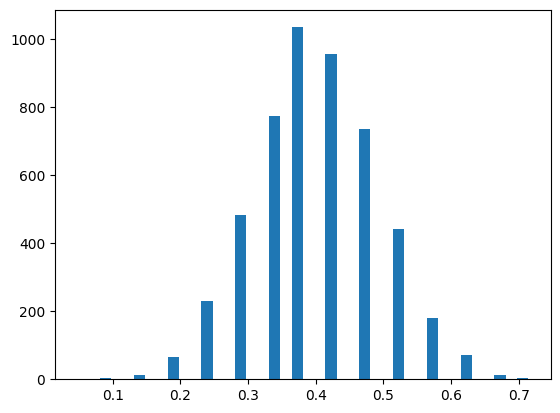

In [ ]:
Random_Tree_MC(X,y)

ACC OF 0.4

#### XGB

In [ ]:
# A FIRST TRY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

# Supongamos que ya tienes los conjuntos de datos divididos
# X_train, X_test, y_train, y_test

# Crear el DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configuración de los parámetros del modelo
param = {
    'objective': 'multi:softmax',  # Objetivo de clasificación multiclase
    'num_class': len(set(y_train)),  # Número de clases
    'eval_metric': 'mlogloss',  # Métrica de evaluación
    'max_depth': 6,  # Profundidad máxima de los árboles
    'eta': 0.3,  # Tasa de aprendizaje
    'seed': 42  # Semilla para reproducibilidad
}

# Número de rondas de boosting
num_round = 200

# Entrenar el modelo
bst = xgb.train(param, dtrain, num_round)

# Predecir en el conjunto de prueba
y_pred = bst.predict(dtest)

# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Mostrar un reporte de clasificación
print(classification_report(y_test, y_pred))

Accuracy: 0.3333
              precision    recall  f1-score   support

           0       0.29      0.33      0.31         6
           1       0.00      0.00      0.00         6
           2       0.45      0.56      0.50         9

    accuracy                           0.33        21
   macro avg       0.25      0.30      0.27        21
weighted avg       0.28      0.33      0.30        21



In [ ]:
accs = XGB_MC(X,y)

0.43919047619047613
0.10252228340270378


(array([  1.,   3.,   0.,   4.,   0.,  27.,  63.,   0., 119.,   0., 167.,
        168.,   0., 167.,   0., 134.,  88.,   0.,  35.,   0.,  17.,   4.,
          0.,   2.,   1.]),
 array([0.0952381 , 0.12380952, 0.15238095, 0.18095238, 0.20952381,
        0.23809524, 0.26666667, 0.2952381 , 0.32380952, 0.35238095,
        0.38095238, 0.40952381, 0.43809524, 0.46666667, 0.4952381 ,
        0.52380952, 0.55238095, 0.58095238, 0.60952381, 0.63809524,
        0.66666667, 0.6952381 , 0.72380952, 0.75238095, 0.78095238,
        0.80952381]),
 <BarContainer object of 25 artists>)

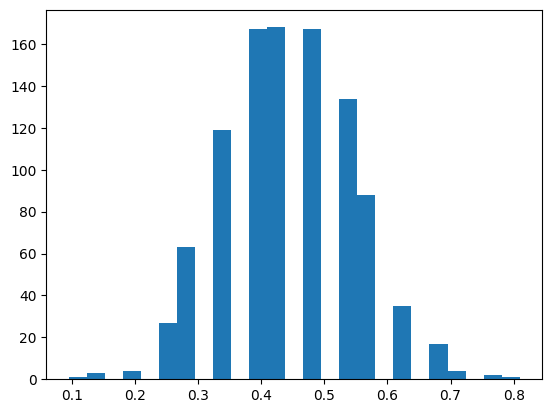

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

In [ ]:
mmd = 5
mnr = 10
nr0 = 20

matriz = Optimize_XGB_MC(X,y,test_size = 0.2, max_md = mmd, max_nround = mnr, nr = nr0)

Text(0.5, 1.0, 'MEAN ACCURACY')

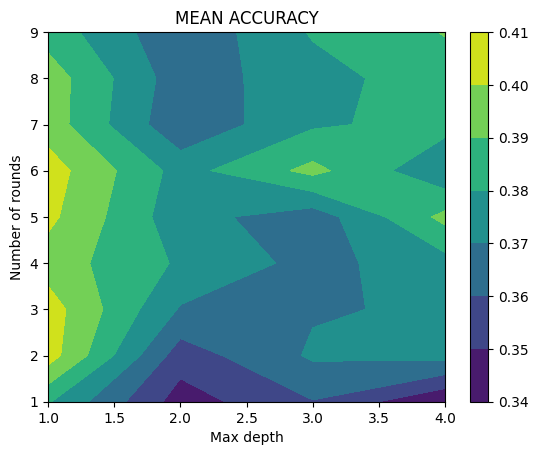

In [ ]:
plt.contourf(range(1,mmd),range(1,mnr),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of rounds')
plt.title('MEAN ACCURACY')

SAME RESULTS

#### NN

In [ ]:
 # Normalize the data if needed
X = X / 255.0 if X.max().max() > 1 else X


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

# Check the shape of your input data
input_shape = X_train.shape[1]

# Determine the number of classes
num_classes = len(np.unique(y))

# Build the model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # For multiclass classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/3
2/2 [==============================] - 1s 187ms/step - loss: 1.1093 - accuracy: 0.2800 - val_loss: 1.1185 - val_accuracy: 0.2222
Epoch 2/3
2/2 [==============================] - 0s 32ms/step - loss: 1.1001 - accuracy: 0.3067 - val_loss: 1.1163 - val_accuracy: 0.2222
Epoch 3/3
1/1 [==============================] - 0s 27ms/step - loss: 1.0815 - accuracy: 0.5714
Test Accuracy: 0.5714285969734192


In [ ]:
accs = NN_MC(X,y,test_size=0.2,nr = 500,epochs = 3)

Epoch 1/3
2/2 [==============================] - 1s 185ms/step - loss: 1.0987 - accuracy: 0.2667 - val_loss: 1.0990 - val_accuracy: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 0s 31ms/step - loss: 1.0975 - accuracy: 0.4800 - val_loss: 1.1000 - val_accuracy: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 1.0975 - accuracy: 0.2857
Epoch 1/3
2/2 [==============================] - 1s 184ms/step - loss: 1.0987 - accuracy: 0.3200 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/3
2/2 [==============================] - 0s 31ms/step - loss: 1.0976 - accuracy: 0.4267 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 1.0933 - accuracy: 0.5238
Epoch 1/3
2/2 [==============================] - 1s 182ms/step - loss: 1.0986 - accuracy: 0.2933 - val_loss: 1.0943 - val_accuracy: 0.6667
Epoch 2/3
2/2 [==============================] - 0s 31ms/step - loss: 1.0973 - accuracy: 0.4267 - val_loss:

0.4297142966836691
0.10046856746654831


(array([ 1.,  6.,  4., 17.,  0., 25., 59., 84.,  0., 93., 83.,  0., 68.,
        40., 19.,  1.]),
 array([0.0952381 , 0.13095238, 0.16666667, 0.20238096, 0.23809524,
        0.27380953, 0.30952382, 0.3452381 , 0.38095239, 0.41666668,
        0.45238097, 0.48809525, 0.52380954, 0.55952383, 0.59523811,
        0.6309524 , 0.66666669]),
 <BarContainer object of 16 artists>)

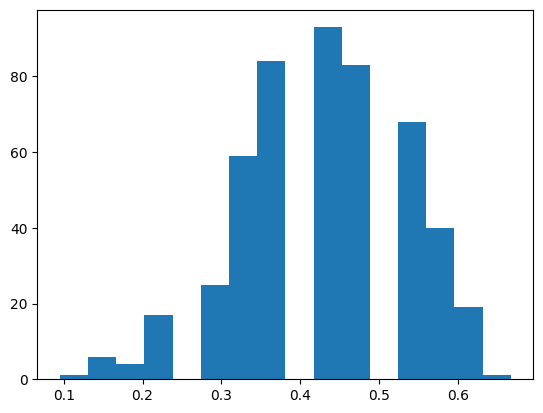

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

A LITTLE BETTER: 0.43

# SUMMARY OF RESULTS


WHEN TRYING TO PREDICT SURVIVAL TIME, THE RESULTS ARE PROMISING. WITH JUST 75 PATIENTS AND BASIC INFORMATION LIKE AGE,SEX,GPA... WE HAVE BEEN ABLE TO PREDICT WITH A 75% ACCURACY IF A PATIENT WOULD SURVIVE MORE OR LESS THAN 500 DAYS.

WHEN TRYING TO PREDICT RELAPSES, NO APPROACH SEEMS TO BE EFFECTIVE. THERE IS NO SUBSTANTIAL DIFFERENCE WHEN CONSIDERING ONLY THE PATIENTS THAT HAVE BEEN TREATED WITH SRS. MULTICLASS OFFERS BETTER RESULTS, AS IT GETS FURTHER AWAY FROM THE RANDOM ACCURACY. MOREOVER, IT IS A BETTER APPROACH IN TERMS OF INTERPRETABILITY.